# 环境导入


In [2]:
# 导入库
import sys
import os

# 添加项目根目录到 sys.path
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(project_root)

cotta_root = os.path.join(project_root, "baseline_code/cotta-main/cifar")
sys.path.append(cotta_root)

plf_root = os.path.join(project_root, "baseline_code/PLF-main/cifar")
sys.path.append(plf_root)


import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm, trange
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import math

from core_model.custom_model import ClassifierWrapper, load_custom_model
from core_model.dataset import get_dataset_loader
from core_model.train_test import model_test
from core_model.lip_teacher import SimpleLipNet

from configs import settings


import pandas as pd


import cotta
import plf

import torch.optim as optim

from cfgs.conf_cotta import cfg as cfg_cotta
from cfgs.conf_plf import cfg as cfg_plf


from args_paser import parse_args


# sys.argv = ['', '--dataset','cifar-10', '--model', 'cifar-resnet18']
# custom_args = parse_args()
# custom_args

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 通用函数


### setup components for testing TTA methods

cotta and plf


In [4]:
def setup_cotta(model, args):
    """Set up tent adaptation.

    Configure the model for training + feature modulation by batch statistics,
    collect the parameters for feature modulation by gradient optimization,
    set up the optimizer, and then tent the model.
    """

    def setup_optimizer(params):
        """Set up optimizer for tent adaptation.

        Tent needs an optimizer for test-time entropy minimization.
        In principle, tent could make use of any gradient optimizer.
        In practice, we advise choosing Adam or SGD+momentum.
        For optimization settings, we advise to use the settings from the end of
        trainig, if known, or start with a low learning rate (like 0.001) if not.

        For best results, try tuning the learning rate and batch size.
        """
        if cfg_cotta.OPTIM.METHOD == "Adam":
            return optim.Adam(
                params,
                lr=cfg_cotta.OPTIM.LR,
                betas=(cfg_cotta.OPTIM.BETA, 0.999),
                weight_decay=cfg_cotta.OPTIM.WD,
            )
        elif cfg_cotta.OPTIM.METHOD == "SGD":
            return optim.SGD(
                params,
                lr=cfg_cotta.OPTIM.LR,
                momentum=cfg_cotta.OPTIM.MOMENTUM,
                dampening=cfg_cotta.OPTIM.DAMPENING,
                weight_decay=cfg_cotta.OPTIM.WD,
                nesterov=cfg_cotta.OPTIM.NESTEROV,
            )
        else:
            raise NotImplementedError

    model = cotta.configure_model(model)
    params, param_names = cotta.collect_params(model)
    optimizer = setup_optimizer(params)
    cotta_model = cotta.CoTTA(
        model,
        optimizer,
        args,
        steps=cfg_cotta.OPTIM.STEPS,
        episodic=cfg_cotta.MODEL.EPISODIC,
        mt_alpha=cfg_cotta.OPTIM.MT,
        rst_m=cfg_cotta.OPTIM.RST,
        ap=cfg_cotta.OPTIM.AP,
    )
    return cotta_model


def setup_plf(model, custom_args, num_classes):
    """Set up tent adaptation.

    Configure the model for training + feature modulation by batch statistics,
    collect the parameters for feature modulation by gradient optimization,
    set up the optimizer, and then tent the model.
    """

    def setup_optimizer(params):
        """Set up optimizer for tent adaptation.

        Tent needs an optimizer for test-time entropy minimization.
        In principle, tent could make use of any gradient optimizer.
        In practice, we advise choosing Adam or SGD+momentum.
        For optimization settings, we advise to use the settings from the end of
        trainig, if known, or start with a low learning rate (like 0.001) if not.

        For best results, try tuning the learning rate and batch size.
        """
        if cfg_plf.OPTIM.METHOD == "Adam":
            return optim.Adam(
                params,
                lr=cfg_plf.OPTIM.LR,
                betas=(cfg_plf.OPTIM.BETA, 0.999),
                weight_decay=cfg_plf.OPTIM.WD,
            )
        elif cfg_plf.OPTIM.METHOD == "SGD":
            return optim.SGD(
                params,
                lr=cfg_plf.OPTIM.LR,
                momentum=cfg_plf.OPTIM.MOMENTUM,
                dampening=cfg_plf.OPTIM.DAMPENING,
                weight_decay=cfg_plf.OPTIM.WD,
                nesterov=cfg_plf.OPTIM.NESTEROV,
            )
        else:
            raise NotImplementedError

    model = plf.configure_model(model)
    params, param_names = plf.collect_params(model)
    optimizer = setup_optimizer(params)
    plf_model = plf.PLF(
        model,
        optimizer,
        custom_args,
        steps=cfg_plf.OPTIM.STEPS,
        episodic=cfg_plf.MODEL.EPISODIC,
        mt_alpha=cfg_plf.OPTIM.MT,
        rst_m=cfg_plf.OPTIM.RST,
        ap=cfg_plf.OPTIM.AP,
        num_classes=num_classes,
    )
    return plf_model


def clean_accuracy(
    model: nn.Module,
    x: torch.Tensor,
    y: torch.Tensor,
    batch_size: int = 100,
    device: torch.device = None,
):
    if device is None:
        device = x.device
    acc = 0.0
    n_batches = math.ceil(x.shape[0] / batch_size)
    with torch.no_grad():
        for counter in trange(n_batches):
            x_curr = x[counter * batch_size : (counter + 1) * batch_size].to(device)
            y_curr = y[counter * batch_size : (counter + 1) * batch_size].to(device)

            # print(f'Batch with sample num: {len(x_curr)}')
            output = model(x_curr)
            corrected_num = (output.max(1)[1] == y_curr).float().sum()
            acc += corrected_num

            # [2024-10-10 sunzekun] 屏蔽了结果输出，保持界面整洁
            # print('batch %d, corrected_num: %d' % (counter, corrected_num.item()))
        # save step model_tta
    return acc.item() / x.shape[0]

### func: get_test_acc


In [5]:
def get_test_acc(test_loader, model, device):

    # Run-Experiment代码里的评估代码。
    # 只能测试总体的test_acc
    # 放在这里只是为了检查一下错误是不是发生在eva中。实际上可能不用。
    criterion = nn.CrossEntropyLoss()
    model.eval().to(device)
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        with tqdm(total=len(test_loader), desc=f"Testing") as pbar:
            for test_inputs, test_targets in test_loader:
                test_inputs, test_targets = test_inputs.to(device), test_targets.to(
                    device
                )
                test_outputs = model(test_inputs)
                loss = criterion(test_outputs, test_targets)
                _, predicted_test = torch.max(test_outputs, 1)
                total_test += test_targets.size(0)
                correct_test += (predicted_test == test_targets).sum().item()

                # 更新进度条
                pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
                pbar.update(1)

    test_accuracy = 100 * correct_test / total_test
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy


class BaseTensorDataset(Dataset):

    # Run-Experiment代码里的自定义数据集。
    # 放在这里只是为了检查一下错误是不是发生在数据集中。实际上可能不用。

    def __init__(self, data, labels, transforms=None, device=None):
        self.data = torch.as_tensor(data, device=device)
        self.labels = torch.as_tensor(labels, device=device)
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        if self.transforms is not None:
            self.transforms(data)

        return data, self.labels[index]

### func: get_suffix


In [6]:
def get_suffix(method, step):
    # 不同的method有不同的后缀
    # 例如，contra有restore和tta的，我们在综合测评中应该只考虑tta
    # 并且根据step还有所不同。step0的情况下，所有的suffix都为worker_restore.
    # 因此，需要一个函数专门处理各种情况
    # # Step-0

    if step == 0:
        # [24-10-11 sunzekun] 只是为了检测一下contra-teacher的性能临时加的代码
        # if method == 'contra':
        #     return 'teacher_restore'
        # else:
        #     return "worker_restore"
        return "worker_restore"

    # Step-1,2,3
    if method in ["cotta", "plf", "contra"]:
        return "worker_tta"
    else:
        return "worker_restore"

    # ================================================================= #
    # [24-10-14 sunzekun] 单独为ablation-study写的get_suffix
    # 因为区别只是在后缀上精细控制，所以不改eva_系列的函数
    # 仅在该函数中进行手动切换，使用的时候需要特别注意

    # if step == 0:
    #     return "worker_restore"

    # # Step-1,2,3
    # if method == 'contra_tta_only':
    #     # return "worker_restore"
    #     return "worker_tta"
    # else: # method = 'contra'
    #     return "worker_tta"
    #     # return "worker_restore"

### func: eva_test_acc


In [7]:
def eva_test_acc(
    dataset_name,
    model_name,
    noise_type="symmetric",
    noise_ratio=0.5,
    methods=None,
    steps=None,
    results_dir=None,
):
    """
    核心代码，用来评估指定dataset任务下的所有方法的step0~4的测试准确率
    """

    # case = settings.get_case(
    #     noise_ratio=noise_ratio, noise_type=noise_type, balanced=True
    # )

    case = settings.get_case(
        noise_ratio=noise_ratio,
        noise_type=noise_type,
    )
    mean, std = None, None
    num_classes = settings.num_classes_dict[dataset_name]
    print(f"目前测试的数据集：{dataset_name}, case模式：{case}")

    # 读入测试数据集
    # core.py中使用的数据集读入代码

    # batch_size = 128

    batch_size = 64

    # PET-37的cotta方法,batch_size要设置的特别小
    # batch_size = 1
    test_data, test_labels, test_dataloader = get_dataset_loader(
        dataset_name,
        "test",
        case,
        None,
        mean,
        std,
        batch_size=batch_size,
        shuffle=False,
        num_workers=8,
    )

    # run_experiment.py中的代码, 用于对比验证效果。
    # print(f'Targeted dataset: {settings.get_dataset_path(dataset_name, case, "test_data")}')

    # D_test_data = np.load(
    #     settings.get_dataset_path(dataset_name, case, "test_data")
    # )
    # D_test_labels = np.load(
    #     settings.get_dataset_path(dataset_name, case, "test_label")
    # )
    # test_dataset = BaseTensorDataset(D_test_data, D_test_labels, device=device)
    # test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    # [Debug用]-检查一下数据
    # x, y = next(iter(test_dataloader))
    # print(x[0])

    #
    # steps = [f'step_{i}' for i in range(4)]
    assert methods is not None, "请指定要评估的方法"
    assert steps is not None, "请指定要评估的step(实验组)"
    assert methods is not None, "请指定评估结果保存的目录"
    os.makedirs(results_dir, exist_ok=True)

    df = pd.DataFrame(index=methods, columns=steps)

    # for method in tqdm(methods):

    for method in methods:
        for step in steps:
            # 先确定一下模型的suffix
            model_suffix = get_suffix(method, step)
            # 读入模型架构
            # 放到循环里边，每次都要重新新建一个模型。
            # 牺牲了一些速度，但是好处是防止cotta和plf把模型架构更改了，导致repair类的模型出问题
            model = load_custom_model(model_name, num_classes, load_pretrained=False)
            model = ClassifierWrapper(model, num_classes)

            # 按照模型名和step数读入模型参数
            model_repair_save_path = settings.get_ckpt_path(
                dataset_name,
                case,
                model_name,
                model_suffix=model_suffix,
                step=step,
                unique_name=method,
            )
            """
            专为测试lipNet性能的代码
            """
            # model = load_custom_model(model_name, num_classes, load_pretrained=True)
            # features = model.fc.in_features
            # model = nn.Sequential(*list(model.children())[:-1], nn.Flatten())
            # model = SimpleLipNet(model, features, num_classes)
            # model_repair_save_path = '/nvme/sunzekun/Projects/tta-mr/ckpt/cifar-10/pretrain/step_0/cifar-resnet18_teacher_restore.pth'
            # model_repair_save_path = '/nvme/szh/code/tta-mr/ckpt/cifar-10/pretrain/step_0/cifar-resnet18_teacher_restore.pth'
            # model_repair_save_path = '/nvme/szh/code/tta-mr/ckpt/cifar-10/pretrain/step_0/cifar-resnet18_worker_restore.pth'
            # model_repair_save_path = '/nvme/sunzekun/Projects/tta-mr/ckpt/cifar-100/pretrain/step_0/cifar-wideresnet40_teacher_restore.pth'
            # model_repair_save_path = '/nvme/sunzekun/Projects/tta-mr/ckpt/cifar-100/pretrain/step_0/cifar-wideresnet40_worker_restore.pth'
            # model_repair_save_path = '/nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/pretrain/step_0/wideresnet50_teacher_restore.pth'
            # model_repair_save_path = '/nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/pretrain/step_0/wideresnet50_worker_restore.pth'

            print(f"Evaluating {model_repair_save_path}")

            # checkpoint = torch.load(model_repair_save_path)
            try:
                checkpoint = torch.load(model_repair_save_path)
            except:
                print(
                    f"Cannot find the weight file at {model_repair_save_path}. Just SKIP."
                )
                continue
            model.load_state_dict(checkpoint, strict=False)

            # [24-10-10 sunzekun] 有两个特殊的tta模型：cotta和plf，不仅改了参数，而且使用了特定的模型架构来进行推断。
            # (即，不仅有test-time Adaptation，还有Augmentation)
            # 所以对这两种需要另外写代码实现。
            # 注意，contra没有这个特殊过程。
            if method == "cotta" or method == "plf":
                # if (method == 'cotta' or method == 'plf') and dataset_name != 'pet-37':
                # if (method == 'cotta' or method == 'plf') and dataset_name == 'cifar-10':
                # 由于测试代码的jupyternotebook 构建命令行参数很麻烦
                # 这里暂时去掉了dataset，model这两个必选参数的required = True
                # 而是直接在使用的时候复制。
                sys.argv = [
                    "",
                    "--dataset",
                    dataset_name,
                    "--model",
                    model_name,
                    "--uni_name",
                    method,
                    "--noise_type",
                    noise_type,
                    "--balanced",
                ]
                custom_args = parse_args()
                model.eval().to(device)
                if method == "cotta":
                    model_aug = setup_cotta(model, custom_args)
                else:
                    model_aug = setup_plf(model, custom_args, num_classes)

                try:
                    model_aug.reset()
                except:
                    print(f"Failed to reset")

                x_test = torch.from_numpy(test_data)
                y_test = torch.from_numpy(test_labels)
                x_test, y_test = x_test.to(device), y_test.to(device)

                test_acc = clean_accuracy(
                    model_aug, x_test, y_test, batch_size=batch_size, device=device
                )
                # print(test_acc)
            else:
                test_acc = model_test(test_dataloader, model, device=device)
                # print(test_acc)
                test_acc = test_acc["global"]

            print(f"测试集Acc：{test_acc}")
            df.loc[method, step] = test_acc
            # test_acc = get_test_acc(test_dataloader, model, device=device)
            # df.loc[method, step] = test_acc

    # 保留参考代码，万一想用excel保存结果的时候用下面的
    # results_file_name = f'{dataset_name}.xlsx'
    # results_file_dir = os.path.join(results_dir, results_file_name)
    # with pd.ExcelWriter(results_file_dir, engine='openpyxl') as writer:
    #     df.to_excel(writer)
    # for tab, df in dfs.items():

    # cls: 分类任务
    # rtv: 检索任务
    mission_type = "cls" if noise_type == "symmetric" else "rtv"
    results_file_name = f"{dataset_name}_{mission_type}.csv"
    results_file_dir = os.path.join(results_dir, results_file_name)
    df.to_csv(results_file_dir)

### icde_func: eva_map


In [8]:
def eva_map(
    dataset_name,
    model_name,
    noise_type="asymmetric",
    noise_ratio=0.5,
    top_k=10,
    methods=None,
    steps=None,
    results_dir=None,
):
    """
    核心代码，用来评估指定dataset任务下的所有方法的step0~4的map，检索任务专用
    """

    case = settings.get_case(
        noise_ratio=noise_ratio, noise_type=noise_type, balanced=True
    )
    mean, std = None, None
    num_classes = settings.num_classes_dict[dataset_name]
    print(f"目前测试的数据集：{dataset_name}, case模式：{case}")

    # ------------------------------------------------------------------------------------ #
    # 读入测试数据集
    # core.py中使用的数据集读入代码
    # train_data, train_labels, train_dataloader = get_dataset_loader(
    #     dataset_name, "train", case, None, mean, std, batch_size=128, shuffle=False, num_workers=8
    # )

    # test_data, test_labels, test_dataloader = get_dataset_loader(
    #     dataset_name, "test", case, None, mean, std, batch_size=128, shuffle=False, num_workers=8
    # )

    # [24-10-14 数据集存放位置有变化，现在train和test的data已经独立于case了，所以去掉]
    train_data, train_labels, train_dataloader = get_dataset_loader(
        dataset_name,
        "train",
        None,
        None,
        mean,
        std,
        batch_size=128,
        shuffle=False,
        num_workers=8,
    )

    test_data, test_labels, test_dataloader = get_dataset_loader(
        dataset_name,
        "test",
        None,
        None,
        mean,
        std,
        batch_size=128,
        shuffle=False,
        num_workers=8,
    )

    # ------------------------------------------------------------------------------------ #

    # run_experiment.py中的代码, 用于对比验证效果。
    # print(f'Targeted dataset: {settings.get_dataset_path(dataset_name, case, "test_data")}')

    # D_test_data = np.load(
    #     settings.get_dataset_path(dataset_name, case, "test_data")
    # )
    # D_test_labels = np.load(
    #     settings.get_dataset_path(dataset_name, case, "test_label")
    # )
    # test_dataset = BaseTensorDataset(D_test_data, D_test_labels, device=device)
    # test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    # [Debug用]-检查一下数据
    # x, y = next(iter(test_dataloader))
    # print(x[0])

    assert methods is not None, "请指定要评估的方法"
    assert steps is not None, "请指定要评估的step(实验组)"
    assert methods is not None, "请指定评估结果保存的目录"
    os.makedirs(results_dir, exist_ok=True)

    df = pd.DataFrame(index=methods, columns=steps)

    # for method in tqdm(methods):

    for method in methods:
        for step in steps:
            # 先确定一下模型的suffix
            model_suffix = get_suffix(method, step)
            # 读入模型架构
            # 放到循环里边，每次都要重新新建一个模型。
            # 牺牲了一些速度，但是好处是防止cotta和plf把模型架构更改了，导致repair类的模型出问题
            model = load_custom_model(model_name, num_classes, load_pretrained=False)
            model = ClassifierWrapper(model, num_classes)

            # 按照模型名和step数读入模型参数
            model_repair_save_path = settings.get_ckpt_path(
                dataset_name,
                case,
                model_name,
                model_suffix=model_suffix,
                step=step,
                unique_name=method,
            )
            print(f"Evaluating {model_repair_save_path}")

            # checkpoint = torch.load(model_repair_save_path)
            try:
                checkpoint = torch.load(model_repair_save_path)
            except:
                print(
                    f"Cannot find the weight file at {model_repair_save_path}. Just SKIP."
                )
                continue
            model.load_state_dict(checkpoint, strict=False)

            # [24-10-10 sunzekun] 有两个特殊的tta模型：cotta和plf，不仅改了参数，而且使用了特定的模型架构来进行推断。
            # (即，不仅有test-time Adaptation，还有Augmentation)
            # 所以对这两种需要另外写代码实现。
            # 注意，contra没有这个特殊过程。

            # [24-10-11 sunzekun] 对于两个带tta的模型，这里不再做单独的增强了，因为增强和检索比较难适配。
            # 直接

            mAP = get_map(model, train_dataloader, test_dataloader, top_k)
            print(f"测试mAP：{mAP}")

            df.loc[method, step] = mAP
            # test_acc = get_test_acc(test_dataloader, model, device=device)
            # df.loc[method, step] = test_acc

    # 保留参考代码，万一想用excel保存结果的时候用下面的
    # results_file_name = f'{dataset_name}.xlsx'
    # results_file_dir = os.path.join(results_dir, results_file_name)
    # with pd.ExcelWriter(results_file_dir, engine='openpyxl') as writer:
    #     df.to_excel(writer)
    # for tab, df in dfs.items():

    # cls: 分类任务
    # rtv: 检索任务
    mission_type = "cls" if noise_type == "symmetric" else "rtv"
    results_file_name = f"{dataset_name}_{mission_type}.csv"
    results_file_dir = os.path.join(results_dir, results_file_name)
    df.to_csv(results_file_dir)


# 特征提取函数
def extract_features(feature_extractor, data_loader):
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in tqdm(data_loader):
            images = images.to(device)
            outputs = feature_extractor(images)
            outputs = outputs.view(outputs.size(0), -1)
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels


def retrieve(gallery_feats, query_feats, top_k=10):
    sims = cosine_similarity(query_feats, gallery_feats)
    indices = np.argsort(-sims, axis=1)[:, :top_k]
    sim_scores = np.take_along_axis(sims, indices, axis=1)
    return indices, sim_scores


def calculate_map(indices, gallery_labels, query_labels):
    num_queries = query_labels.shape[0]
    ap_list = []
    for i in range(num_queries):
        query_label = query_labels[i]
        retrieved_labels = gallery_labels[indices[i]]
        relevant = (retrieved_labels == query_label).astype(int)
        num_relevant = relevant.sum()
        if num_relevant == 0:
            ap_list.append(0)
            continue
        cumulative_precision = np.cumsum(relevant) / (np.arange(len(relevant)) + 1)
        ap = (cumulative_precision * relevant).sum() / num_relevant
        ap_list.append(ap)
    mAP = np.mean(ap_list)
    return mAP


def get_map(model, train_loader, test_loader, top_k):
    model.to(device)
    model.eval()
    feature_extractor = nn.Sequential(*list(model.children())[:-1])
    feature_extractor = feature_extractor.to(device)
    feature_extractor.eval()

    # 提取特征
    g_features, g_labels = extract_features(feature_extractor, train_loader)
    q_features, q_labels = extract_features(feature_extractor, test_loader)
    indices, _ = retrieve(g_features, q_features, top_k=top_k)
    mAP = calculate_map(indices, g_labels, q_labels)

    return mAP

### icde_func: eva_retrieval


In [9]:
def eva_retrieval(
    dataset_name,
    model_name,
    noise_type="asymmetric",
    noise_ratio=0.5,
    methods=None,
    steps=None,
    top_k=5,
    query_indices=[0],
    use_cache=False,
):
    """
    核心代码，用来展示任意模型的检索结果，检索任务专用
    重要参数：top_k, 用于确定一次输出多少张图片
    """

    case = settings.get_case(
        noise_ratio=noise_ratio, noise_type=noise_type, balanced=True
    )
    mean, std = None, None
    num_classes = settings.num_classes_dict[dataset_name]
    print(f"目前测试的数据集：{dataset_name}, case模式：{case}")

    # 读入测试数据集
    # core.py中使用的数据集读入代码
    # train_data, train_labels, train_dataloader = get_dataset_loader(
    #     dataset_name, "train", case, None, mean, std, batch_size=128, shuffle=False
    # )

    # # TODO-仅用来测试一下数据集的归一化和恢复，以及展示情况
    # # print(train_data[0].shape)
    # # print(train_data[0])
    # # return
    # # img = recover_img(train_data[0], dataset_name)
    # # print(img.max(), img.min())
    # # plt.figure()
    # # plt.imshow(np.transpose(img, (1, 2, 0)))
    # # plt.show()
    # # return

    # test_data, test_labels, test_dataloader = get_dataset_loader(
    #     dataset_name, "test", case, None, mean, std, batch_size=128, shuffle=False
    # )

    train_data, train_labels, train_dataloader = get_dataset_loader(
        dataset_name, "train", None, None, mean, std, batch_size=128, shuffle=False
    )

    test_data, test_labels, test_dataloader = get_dataset_loader(
        dataset_name, "test", None, None, mean, std, batch_size=128, shuffle=False
    )

    # run_experiment.py中的代码, 用于对比验证效果。
    # print(f'Targeted dataset: {settings.get_dataset_path(dataset_name, case, "test_data")}')

    # D_test_data = np.load(
    #     settings.get_dataset_path(dataset_name, case, "test_data")
    # )
    # D_test_labels = np.load(
    #     settings.get_dataset_path(dataset_name, case, "test_label")
    # )
    # test_dataset = BaseTensorDataset(D_test_data, D_test_labels, device=device)
    # test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    # [Debug用]-检查一下数据
    # x, y = next(iter(test_dataloader))
    # print(x[0])

    assert methods is not None, "请指定要评估的方法"
    assert steps is not None, "请指定要评估的step(实验组)"

    # for method in tqdm(methods):

    for method in methods:
        for step in steps:
            # 先确定一下模型的suffix
            model_suffix = get_suffix(method, step)
            # 读入模型架构
            # 放到循环里边，每次都要重新新建一个模型。
            # 牺牲了一些速度，但是好处是防止cotta和plf把模型架构更改了，导致repair类的模型出问题
            model = load_custom_model(model_name, num_classes, load_pretrained=False)
            model = ClassifierWrapper(model, num_classes)

            # 按照模型名和step数读入模型参数
            model_repair_save_path = settings.get_ckpt_path(
                dataset_name,
                case,
                model_name,
                model_suffix=model_suffix,
                step=step,
                unique_name=method,
            )
            print(f"Evaluating {model_repair_save_path}")

            # checkpoint = torch.load(model_repair_save_path)
            try:
                checkpoint = torch.load(model_repair_save_path)
            except:
                print(
                    f"Cannot find the weight file at {model_repair_save_path}. Just SKIP."
                )
                continue
            model.load_state_dict(checkpoint, strict=False)

            # [24-10-10 sunzekun] 有两个特殊的tta模型：cotta和plf，不仅改了参数，而且使用了特定的模型架构来进行推断。
            # (即，不仅有test-time Adaptation，还有Augmentation)
            # 所以对这两种需要另外写代码实现。
            # 注意，contra没有这个特殊过程。

            # [24-10-11 sunzekun] 对于两个带tta的模型，这里不再做单独的增强了，因为增强和检索比较难适配。
            # 直接

            cache_path = get_cache_path(
                dataset_name=dataset_name,
                case=case,
                step=step,
                unique_name=method,
                top_k=top_k,
            )
            # print(cache_path)
            # return
            if use_cache:
                try:
                    data = np.load(cache_path)
                except:
                    print(
                        "未读取到对应的相似分数缓存。首次评估某个模型时，请先使用use_cache=False"
                    )
                    continue

                print(f"读取缓存的相似度分数记录：{cache_path}")
                indices = data["indices"]
                sim_scores = data["sim_scores"]
            else:
                indices, sim_scores = get_sim_scores(
                    model, train_dataloader, test_dataloader, top_k
                )
                np.savez(cache_path, indices=indices, sim_scores=sim_scores)
            # print(indices, sim_scores)
            # print(f'Length of retrived indices: {len(indices)}')
            # return
            for query_idx in query_indices:
                print(f"展示Query图片-idx-{query_idx}的搜索结果")
                display_image_grid(
                    test_data,
                    test_labels,
                    train_data,
                    train_labels,
                    query_idx,
                    indices[query_idx],
                    sim_scores[query_idx],
                    save_path=None,  # 如果需要保存图像，设置保存路径
                    dataset_name=dataset_name,  # 用于读取图片的归一化参数，执行‘反归一化’
                )


def get_sim_scores(model, train_loader, test_loader, top_k):
    model.to(device)
    model.eval()
    feature_extractor = nn.Sequential(*list(model.children())[:-1])
    feature_extractor = feature_extractor.to(device)
    feature_extractor.eval()

    # 提取特征
    g_features, g_labels = extract_features(feature_extractor, train_loader)
    q_features, q_labels = extract_features(feature_extractor, test_loader)
    indices, sim_scores = retrieve(g_features, q_features, top_k=top_k)

    return indices, sim_scores


def draw_box(ax, img, color="red"):

    # TODO- Pet37的参数
    # border_width = 6  # 边框的宽度
    # # adjust = border_width /2 + 1
    # adjust = 2

    # TODO- Cifar100的参数
    border_width = 6  # 边框的宽度
    # adjust = border_width /2 + 1
    adjust = 0

    _, height, width = img.shape
    # rect = Rectangle((-adjust + 1 + border_width, -adjust + 1 + border_width), width - 2 * border_width + adjust + 1 , height - 2 * border_width + adjust  + 1 ,
    #                 fill=False, edgecolor=color, linewidth=border_width)
    # rect = Rectangle((-adjust + border_width, -adjust + border_width), width - 2 * border_width + adjust, height - 2 * border_width + adjust,
    #             fill=False, edgecolor=color, linewidth=border_width)

    rect = Rectangle(
        (0, 0),
        width - 1,
        height - 1,
        fill=False,
        edgecolor=color,
        linewidth=border_width,
    )
    ax.add_patch(rect)


box_color = {
    # 'query' : '#FA9248',
    "query": "purple",
    "correct": "#4DA764",
    "wrong": "#E05757",
}


# box_color = {
#     'query' : 'purple',
#     'correct': 'green',
#     'wrong': 'red'
# }


def display_image_grid(
    query_data,
    query_labels,
    gallery_data,
    gallery_labels,
    query_index,
    retrieved_indices,
    sim_scores,
    save_path=None,
    dataset_name=None,
):
    assert dataset_name is not None, "请指明数据集名称，用于恢复对应的归一化后的图片"

    # 读入class_names，用于展示在图片上
    if dataset_name == "cifar-100":
        class_names = load_classes_from_file("../configs/classes/cifar_100_classes.txt")
    elif dataset_name == "pet-37":
        class_names = load_classes_from_file("../configs/classes/pet_37_classes.txt")
    else:
        raise NotImplementedError

    title_fs = 15  # 标题的字号大小

    K = len(retrieved_indices)
    plt.style.use("default")
    fig, axs = plt.subplots(1, K + 1, figsize=(15, 3))
    # 显示查询图像
    query_img = query_data[query_index]
    query_img = recover_img(query_img, dataset_name)

    axs[0].imshow(np.transpose(query_img, (1, 2, 0)))

    query_label = query_labels[query_index]
    query_class_name = class_names[query_label]
    axs[0].set_title(
        query_class_name,
        fontsize=title_fs,
        fontfamily="serif",
        weight="bold",
        color=box_color["query"],
    )
    axs[0].axis("off")

    draw_box(axs[0], query_img, color=box_color["query"])

    print(f"查询图片label：{query_label}-{query_class_name}")

    # 显示检索结果
    for i, idx in enumerate(retrieved_indices):
        img = gallery_data[idx]
        img = recover_img(img, dataset_name)
        axs[i + 1].imshow(np.transpose(img, (1, 2, 0)))

        label = gallery_labels[idx]
        class_name = class_names[label]
        # TODO [24-10-14 sunzekun] 增加相似度分数显示
        class_name = f"{class_name} ({sim_scores[i]:.2f})"

        # axs[i + 1].set_title(class_name, fontsize=title_fs, fontfamily="serif", weight="bold")
        # axs[i + 1].set_title(f"Sim: {sim_scores[i]:.2f}")
        axs[i + 1].axis("off")

        if label == query_label:
            draw_box(axs[i + 1], img, color=box_color["correct"])
            axs[i + 1].set_title(
                class_name,
                fontsize=title_fs,
                fontfamily="serif",
                weight="bold",
                color=box_color["correct"],
            )
        else:
            draw_box(axs[i + 1], img, color=box_color["wrong"])
            axs[i + 1].set_title(
                class_name,
                fontsize=title_fs,
                fontfamily="serif",
                weight="bold",
                color=box_color["wrong"],
            )

    if save_path:
        plt.savefig(save_path)

    plt.gca().set_axis_off()
    plt.subplots_adjust(
        left=0, right=1, top=1, bottom=0, wspace=0.02, hspace=0
    )  # 适配top-5
    # plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.035, hspace=0)  # top-10
    # plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.0, hspace=0)  # 移除所有边缘空白
    # plt.tight_layout()
    plt.margins(0, 0)
    plt.show()


def recover_img(img, dataset_name):
    if dataset_name == "pet-37":
        means = np.array([0.485, 0.456, 0.406])[:, np.newaxis, np.newaxis]
        stds = np.array([0.229, 0.224, 0.225])[:, np.newaxis, np.newaxis]
    elif dataset_name == "cifar-100":

        means = np.array([0.5071, 0.4865, 0.4409])[:, np.newaxis, np.newaxis]
        stds = np.array([0.2673, 0.2564, 0.2762])[:, np.newaxis, np.newaxis]
    else:
        raise NotImplementedError
    return np.clip(img * stds + means, 0, 1)


def get_cache_path(dataset_name, case, step, unique_name, top_k):
    root_dir = os.path.abspath(os.path.join(os.getcwd(), os.path.pardir))

    path = os.path.join(
        root_dir,
        "result_analysis/results_main/rtv_cache",
        dataset_name,
        case,
        f"step_{step}",
        unique_name,
    )
    os.makedirs(path, exist_ok=True)

    return os.path.join(path, f"top_{top_k}.npz")


def load_classes_from_file(file_path):
    """从文件中读取类别列表"""
    with open(file_path, "r") as f:
        classes = [line.strip() for line in f.readlines()]
    return classes

In [2]:
# PET-37的归一化参数（从gen_pet37的代码里找到）
# import torchvision
# torchvision.models.ResNet18_Weights.DEFAULT.transforms()

# 1、主实验


## 主实验表

### sym-cifar10 all in one


In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from core_model.custom_model import ClassifierWrapper, load_custom_model
from configs import settings
import logging

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 设置GPU设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 设置日志输出格式
logging.basicConfig(
    level=logging.INFO,
    format="\033[1;36m%(asctime)s - %(levelname)s - %(message)s\033[0m",
)
logger = logging.getLogger(__name__)

def get_test_acc(test_loader, model, device):
    """
    计算模型在测试集上的准确率。
    """
    criterion = nn.CrossEntropyLoss()
    model.eval().to(device)
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        with tqdm(total=len(test_loader), desc="Testing") as pbar:
            for test_inputs, test_targets in test_loader:
                test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)
                test_outputs = model(test_inputs)
                loss = criterion(test_outputs, test_targets)
                _, predicted_test = torch.max(test_outputs, 1)
                total_test += test_targets.size(0)
                correct_test += (predicted_test == test_targets).sum().item()

                # 更新进度条
                pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
                pbar.update(1)

    test_accuracy = 100 * correct_test / total_test
    return test_accuracy

class BaseTensorDataset(Dataset):
    def __init__(self, data, labels, transforms=None, device=None):
        self.data = torch.as_tensor(data, device=device)
        self.labels = torch.as_tensor(labels, device=device)
        self.transforms = transforms
        logger.info(f"Dataset initialized with data shape: {data.shape} and labels shape: {labels.shape}")

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        if self.transforms is not None:
            self.transforms(data)
        return data, self.labels[index]

def get_model_path(dataset_name, model_name, method, noise_ratio, noise_type="symmetric"):
    """
    根据数据集名称、模型名称、方法、噪声比例和类型生成模型路径。
    """
    mission_type = "symmetric" if noise_type == "symmetric" else "asymmetric"
    base_ckpt_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_{noise_ratio}_nt_{mission_type}_cvpr"

    # 根据不同的方法选择不同的路径
    if method == "pretrain":
        path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/pretrain/{model_name}_pretrain.pth"
    elif method == "inc_train":
        path = os.path.join(base_ckpt_path, f"{model_name}_inc_train.pth")
    else:
        path = os.path.join(base_ckpt_path, method, f"{model_name}_restore.pth")

    if not os.path.exists(path):
        logger.warning(f"Expected file at {path} not found.")
    return path

def eva_test_acc(dataset_name, model_name, noise_type="symmetric", noise_ratio=0.5, methods=None, results_dir=None, device="cuda"):
    """
    评估指定数据集和方法的测试准确率。
    """
    assert methods is not None, "请指定要评估的方法。"
    assert results_dir is not None, "请指定保存结果的目录。"
    os.makedirs(results_dir, exist_ok=True)

    num_classes = settings.num_classes_dict[dataset_name]
    logger.info(f"Currently testing dataset: {dataset_name} with {num_classes} classes.")

    # 加载测试数据集
    batch_size = 64
    test_data_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_data.npy"
    test_label_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_label.npy"

    try:
        logger.info(f"Loading test data from: {test_data_path}")
        test_data = np.load(test_data_path)
        test_labels = np.load(test_label_path)
        logger.info(f"Test data loaded with shape: {test_data.shape}, Test labels loaded with shape: {test_labels.shape}")
        test_dataset = BaseTensorDataset(test_data, test_labels, device=device)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    except FileNotFoundError as e:
        logger.error(f"Error loading test dataset: {e}")
        return

    # 初始化结果 DataFrame
    df = pd.DataFrame(index=["accuracy"], columns=methods)

    for method in methods:
        # 跳过 finetune 方法
        if method == "finetune":
            continue

        model_path = get_model_path(dataset_name, model_name, method, noise_ratio, noise_type)
        logger.info(f"Evaluating model from path: {model_path}")

        # 加载模型结构和权重
        model = load_custom_model(model_name, num_classes, load_pretrained=False)
        model = ClassifierWrapper(model, num_classes)
        try:
            checkpoint = torch.load(model_path, map_location=device)
            logger.info(f"Loaded model checkpoint from {model_path}")
        except FileNotFoundError:
            logger.error(f"Cannot find the weight file at {model_path}. Skipping.")
            continue
        model.load_state_dict(checkpoint, strict=False)

        # 评估模型
        logger.info(f"Starting evaluation for method: {method}")
        test_acc = get_test_acc(test_dataloader, model, device)

        logger.info(f"Test Accuracy for {method}: {test_acc:.2f}%")
        df.loc["accuracy", method] = test_acc

    # 保存结果到 CSV
    mission_type = "sym" if noise_type == "symmetric" else "asym"
    results_file_name = f"{dataset_name}_nr{noise_ratio}_{mission_type}.csv"
    results_file_dir = os.path.join(results_dir, results_file_name)
    df.to_csv(results_file_dir)
    logger.info(f"Results saved to {results_file_dir}")

# 示例用法
if __name__ == "__main__":
    dataset_name = "cifar-10"
    model_name = "efficientnet_s"
    noise_types = ["symmetric", "asymmetric"]
    noise_ratios = [0.1, 0.25, 0.5, 0.75, 0.9]
    methods = [
        "pretrain",
        "inc_train",
        "Coteaching",
        "Coteachingplus",
        "JoCoR",
        "Decoupling",
        "NegativeLearning",
        "PENCIL",
        "GA",
        "GA_l1",
        "FT",
        "wfisher",
        "CRUL",
    ]
    results_dir = "./results_cvpr/main"

    for noise_type in noise_types:
        for noise_ratio in noise_ratios:
            eva_test_acc(
                dataset_name,
                model_name,
                noise_type,
                noise_ratio,
                methods=methods,
                results_dir=results_dir,
            )


2024-11-10 23:25:48,205 - INFO - Currently testing dataset: cifar-10 with 10 classes.
2024-11-10 23:25:48,206 - INFO - Loading test data from: /nvme/szh/code/tta-mr/data/cifar-10/gen/test_data.npy
2024-11-10 23:25:48,246 - INFO - Test data loaded with shape: (10000, 3, 32, 32), Test labels loaded with shape: (10000,)
2024-11-10 23:25:48,258 - INFO - Dataset initialized with data shape: (10000, 3, 32, 32) and labels shape: (10000,)


2024-11-10 23:25:48,261 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/cifar-10/pretrain/efficientnet_s_pretrain.pth
2024-11-10 23:25:48,831 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/cifar-10/pretrain/efficientnet_s_pretrain.pth
2024-11-10 23:25:48,875 - INFO - Starting evaluation for method: pretrain
Testing: 100%|██████████| 157/157 [00:02<00:00, 54.93it/s, Loss=1.3328]
2024-11-10 23:25:51,773 - INFO - Test Accuracy for pretrain: 84.85%
2024-11-10 23:25:51,774 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/cifar-10/nr_0.1_nt_symmetric_cvpr/efficientnet_s_inc_train.pth
2024-11-10 23:25:52,197 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/cifar-10/nr_0.1_nt_symmetric_cvpr/efficientnet_s_inc_train.pth
2024-11-10 23:25:52,254 - INFO - Starting evaluation for method: inc_train
Testing: 100%|██████████| 157/157 [00:03<00:00, 52.04it/s, Loss=1.3061]
2024-11-10 23:25:55,310 - INFO - Test Accuracy for inc_train: 84.82

In [18]:
import os
import pandas as pd

def merge_results_to_dataframe(results_dir, output_file, dataset_name="cifar-10"):
    """
    将指定目录中的所有结果文件合并为一个完整的 DataFrame，并保存为 CSV。

    参数:
    - results_dir: 包含结果 CSV 文件的目录。
    - output_file: 合并结果的输出 CSV 文件路径。
    - dataset_name: 数据集名称，将作为第一列添加到结果中。
    """
    # 初始化一个空的 DataFrame，用于合并
    combined_df = pd.DataFrame()

    # 遍历结果目录中的所有 CSV 文件
    for file_name in os.listdir(results_dir):
        if file_name.endswith(".csv"):
            # 解析文件名，提取噪声比例和类型
            file_path = os.path.join(results_dir, file_name)
            noise_info = file_name.replace("cifar-10_", "").replace(".csv", "")
            
            # 检查文件名格式是否正确
            if "_" in noise_info:
                noise_ratio, noise_type = noise_info.split("_")
            else:
                print(f"Skipping file with unexpected name format: {file_name}")
                continue

            # 读取文件并添加数据集名称、噪声比例和类型作为新列
            df = pd.read_csv(file_path, index_col=0)

            # 插入列并避免重复
            if "dataset_name" not in df.columns:
                df.insert(0, "dataset_name", dataset_name)
            if "noise_type" not in df.columns:
                df.insert(1, "noise_type", noise_type)
            if "noise_ratio" not in df.columns:
                df.insert(2, "noise_ratio", noise_ratio)

            # 将当前文件的内容追加到合并 DataFrame
            combined_df = pd.concat([combined_df, df])

    # 重置索引，便于查看
    combined_df.reset_index(drop=True, inplace=True)

    # 保存合并后的 DataFrame
    combined_df.to_csv(output_file, index=False)
    print(f"Results merged and saved to {output_file}")

# 用法示例
results_dir = "./results_cvpr/main"
output_file = "./results_cvpr/main/merged_results_cifar10.csv"
merge_results_to_dataframe(results_dir, output_file)


Results merged and saved to ./results_cvpr/main/merged_results_cifar10.csv


In [14]:
# !ls 

### sym-Flower-102 all in one


In [19]:
import warnings
warnings.filterwarnings("ignore")

import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from core_model.custom_model import ClassifierWrapper, load_custom_model
from configs import settings
import logging

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 设置日志输出格式
logging.basicConfig(
    level=logging.INFO,
    format="\033[1;36m%(asctime)s - %(levelname)s - %(message)s\033[0m",
)
logger = logging.getLogger(__name__)

def get_test_acc(test_loader, model, device):
    """
    计算模型在测试集上的准确率。
    """
    criterion = nn.CrossEntropyLoss()
    model.eval().to(device)
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        with tqdm(total=len(test_loader), desc="Testing") as pbar:
            for test_inputs, test_targets in test_loader:
                test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)
                test_outputs = model(test_inputs)
                loss = criterion(test_outputs, test_targets)
                _, predicted_test = torch.max(test_outputs, 1)
                total_test += test_targets.size(0)
                correct_test += (predicted_test == test_targets).sum().item()

                # 更新进度条
                pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
                pbar.update(1)

    test_accuracy = 100 * correct_test / total_test
    return test_accuracy

class BaseTensorDataset(Dataset):
    def __init__(self, data, labels, transforms=None, device=None):
        self.data = torch.as_tensor(data, device=device)
        self.labels = torch.as_tensor(labels, device=device)
        self.transforms = transforms
        logger.info(f"Dataset initialized with data shape: {data.shape} and labels shape: {labels.shape}")

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        if self.transforms is not None:
            self.transforms(data)
        return data, self.labels[index]

def get_model_path(dataset_name, model_name, method, noise_ratio, noise_type="symmetric"):
    """
    根据数据集名称、模型名称、方法、噪声比例和类型生成模型路径。
    """
    mission_type = "symmetric" if noise_type == "symmetric" else "asymmetric"
    base_ckpt_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_{noise_ratio}_nt_{mission_type}_cvpr"

    # 根据不同的方法选择不同的路径
    if method == "pretrain":
        path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/pretrain/{model_name}_pretrain.pth"
    elif method == "inc_train":
        path = os.path.join(base_ckpt_path, f"{model_name}_inc_train.pth")
    else:
        path = os.path.join(base_ckpt_path, method, f"{model_name}_restore.pth")

    if not os.path.exists(path):
        logger.warning(f"Expected file at {path} not found.")
    return path

def eva_test_acc(dataset_name, model_name, noise_type="symmetric", noise_ratio=0.5, methods=None, results_dir=None, device="cuda"):
    """
    评估指定数据集和方法的测试准确率。
    """
    assert methods is not None, "请指定要评估的方法。"
    assert results_dir is not None, "请指定保存结果的目录。"
    os.makedirs(results_dir, exist_ok=True)

    num_classes = settings.num_classes_dict[dataset_name]
    logger.info(f"Currently testing dataset: {dataset_name} with {num_classes} classes.")

    # 加载测试数据集
    batch_size = 64
    test_data_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_data.npy"
    test_label_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_label.npy"

    try:
        logger.info(f"Loading test data from: {test_data_path}")
        test_data = np.load(test_data_path)
        test_labels = np.load(test_label_path)
        logger.info(f"Test data loaded with shape: {test_data.shape}, Test labels loaded with shape: {test_labels.shape}")
        test_dataset = BaseTensorDataset(test_data, test_labels, device=device)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    except FileNotFoundError as e:
        logger.error(f"Error loading test dataset: {e}")
        return

    # 初始化结果 DataFrame
    df = pd.DataFrame(index=["accuracy"], columns=methods)

    for method in methods:
        # 跳过 finetune 方法
        if method == "finetune":
            continue

        model_path = get_model_path(dataset_name, model_name, method, noise_ratio, noise_type)
        logger.info(f"Evaluating model from path: {model_path}")

        # 加载模型结构和权重
        model = load_custom_model(model_name, num_classes, load_pretrained=False)
        model = ClassifierWrapper(model, num_classes)
        try:
            checkpoint = torch.load(model_path, map_location=device)
            logger.info(f"Loaded model checkpoint from {model_path}")
        except FileNotFoundError:
            logger.error(f"Cannot find the weight file at {model_path}. Skipping.")
            continue
        model.load_state_dict(checkpoint, strict=False)

        # 评估模型
        logger.info(f"Starting evaluation for method: {method}")
        test_acc = get_test_acc(test_dataloader, model, device)

        logger.info(f"Test Accuracy for {method}: {test_acc:.2f}%")
        df.loc["accuracy", method] = test_acc

    # 保存结果到 CSV
    mission_type = "sym" if noise_type == "symmetric" else "asym"
    results_file_name = f"{dataset_name}_nr{noise_ratio}_{mission_type}.csv"
    results_file_dir = os.path.join(results_dir, results_file_name)
    df.to_csv(results_file_dir)
    logger.info(f"Results saved to {results_file_dir}")

# 示例用法
if __name__ == "__main__":
    dataset_name = "flower-102"
    model_name = "wideresnet50"
    noise_types = ["symmetric"]
    noise_ratios = [0.0, 0.1, 0.25, 0.5, 0.75, 0.9]
    methods = [
        "pretrain",
        "inc_train",
        # LNL方法
        "Coteaching",
        "Coteachingplus",
        "JoCoR",
        "Decoupling",
        "NegativeLearning",
        "PENCIL",
        # MU 方法
        "GA",
        "GA_l1",
        "FT",
        "wfisher",
        "FT_prune",
        "retrain",
        "CRUL",
    ]
    results_dir = "./results_cvpr/main"

    for noise_type in noise_types:
        for noise_ratio in noise_ratios:
            eva_test_acc(
                dataset_name,
                model_name,
                noise_type,
                noise_ratio,
                methods=methods,
                results_dir=results_dir,
            )


2024-11-11 00:02:28,415 - INFO - Currently testing dataset: flower-102 with 102 classes.
2024-11-11 00:02:28,416 - INFO - Loading test data from: /nvme/szh/code/tta-mr/data/flower-102/gen/test_data.npy
2024-11-11 00:02:28,564 - INFO - Test data loaded with shape: (1020, 3, 224, 224), Test labels loaded with shape: (1020,)
2024-11-11 00:02:28,606 - INFO - Dataset initialized with data shape: (1020, 3, 224, 224) and labels shape: (1020,)
2024-11-11 00:02:28,609 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/flower-102/pretrain/wideresnet50_pretrain.pth
2024-11-11 00:02:29,438 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/flower-102/pretrain/wideresnet50_pretrain.pth
2024-11-11 00:02:29,480 - INFO - Starting evaluation for method: pretrain
Testing: 100%|██████████| 16/16 [00:00<00:00, 29.21it/s, Loss=0.3155]
2024-11-11 00:02:30,074 - INFO - Test Accuracy for pretrain: 91.08%
2024-11-11 00:02:30,075 - INFO - Evaluating model from path: /nvme/szh/code/tta

In [23]:
import os
import pandas as pd

def merge_results_to_dataframe(results_dir, output_file, dataset_name="flower-102"):
    """
    将指定目录中的所有结果文件合并为一个完整的 DataFrame，并保存为 CSV。

    参数:
    - results_dir: 包含结果 CSV 文件的目录。
    - output_file: 合并结果的输出 CSV 文件路径。
    - dataset_name: 数据集名称，将作为第一列添加到结果中。
    """
    # 初始化一个空的 DataFrame，用于合并
    combined_df = pd.DataFrame()

    # 遍历结果目录中的所有 CSV 文件
    for file_name in os.listdir(results_dir):
        if file_name.endswith(".csv"):
            # 解析文件名，提取噪声比例和类型
            file_path = os.path.join(results_dir, file_name)
            noise_info = file_name.replace(f"{dataset_name}_", "").replace(".csv", "")
            
            # 按照 "_" 分割并获取前两个部分
            split_info = noise_info.split("_")
            if len(split_info) == 3:  # 处理 nr_0.1_nt_symmetric 格式
                noise_ratio, noise_type = split_info[0], split_info[2]
            elif len(split_info) == 2:  # 处理 nr_0.1 或 nt_symmetric 格式
                noise_ratio, noise_type = split_info[0], split_info[1]
            else:
                print(f"Skipping file with unexpected name format: {file_name}")
                continue

            # 读取文件并添加数据集名称、噪声比例和类型作为新列
            df = pd.read_csv(file_path, index_col=0)

            # 插入列并避免重复
            if "dataset_name" not in df.columns:
                df.insert(0, "dataset_name", dataset_name)
            if "noise_type" not in df.columns:
                df.insert(1, "noise_type", noise_type)
            if "noise_ratio" not in df.columns:
                df.insert(2, "noise_ratio", noise_ratio)

            # 将当前文件的内容追加到合并 DataFrame
            combined_df = pd.concat([combined_df, df])

    # 重置索引，便于查看
    combined_df.reset_index(drop=True, inplace=True)

    # 保存合并后的 DataFrame
    combined_df.to_csv(output_file, index=False)
    print(f"Results merged and saved to {output_file}")

# 用法示例
results_dir = "./results_cvpr/main"
output_file = "./results_cvpr/main/merged_results_flower102.csv"
merge_results_to_dataframe(results_dir, output_file)


Results merged and saved to ./results_cvpr/main/merged_results_flower102.csv


### asym-cifar100 all in one


In [24]:
import warnings
warnings.filterwarnings("ignore")

import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from core_model.custom_model import ClassifierWrapper, load_custom_model
from configs import settings
import logging

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 设置日志输出格式
logging.basicConfig(
    level=logging.INFO,
    format="\033[1;36m%(asctime)s - %(levelname)s - %(message)s\033[0m",
)
logger = logging.getLogger(__name__)

def get_test_acc(test_loader, model, device):
    """
    计算模型在测试集上的准确率。
    """
    criterion = nn.CrossEntropyLoss()
    model.eval().to(device)
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        with tqdm(total=len(test_loader), desc="Testing") as pbar:
            for test_inputs, test_targets in test_loader:
                test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)
                test_outputs = model(test_inputs)
                loss = criterion(test_outputs, test_targets)
                _, predicted_test = torch.max(test_outputs, 1)
                total_test += test_targets.size(0)
                correct_test += (predicted_test == test_targets).sum().item()

                # 更新进度条
                pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
                pbar.update(1)

    test_accuracy = 100 * correct_test / total_test
    return test_accuracy

class BaseTensorDataset(Dataset):
    def __init__(self, data, labels, transforms=None, device=None):
        self.data = torch.as_tensor(data, device=device)
        self.labels = torch.as_tensor(labels, device=device)
        self.transforms = transforms
        logger.info(f"Dataset initialized with data shape: {data.shape} and labels shape: {labels.shape}")

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        if self.transforms is not None:
            self.transforms(data)
        return data, self.labels[index]

def get_model_path(dataset_name, model_name, method, noise_ratio, noise_type="asymmetric"):
    """
    根据数据集名称、模型名称、方法、噪声比例和类型生成模型路径。
    """
    mission_type = "symmetric" if noise_type == "symmetric" else "asymmetric"
    base_ckpt_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_{noise_ratio}_nt_{mission_type}_cvpr"

    # 根据不同的方法选择不同的路径
    if method == "pretrain":
        path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/pretrain/{model_name}_pretrain.pth"
    elif method == "inc_train":
        path = os.path.join(base_ckpt_path, f"{model_name}_inc_train.pth")
    else:
        path = os.path.join(base_ckpt_path, method, f"{model_name}_restore.pth")

    if not os.path.exists(path):
        logger.warning(f"Expected file at {path} not found.")
    return path

def eva_test_acc(dataset_name, model_name, noise_type="asymmetric", noise_ratio=0.5, methods=None, results_dir=None, device="cuda"):
    """
    评估指定数据集和方法的测试准确率。
    """
    assert methods is not None, "请指定要评估的方法。"
    assert results_dir is not None, "请指定保存结果的目录。"
    os.makedirs(results_dir, exist_ok=True)

    num_classes = settings.num_classes_dict[dataset_name]
    logger.info(f"Currently testing dataset: {dataset_name} with {num_classes} classes.")

    # 加载测试数据集
    batch_size = 64
    test_data_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_data.npy"
    test_label_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_label.npy"

    try:
        logger.info(f"Loading test data from: {test_data_path}")
        test_data = np.load(test_data_path)
        test_labels = np.load(test_label_path)
        logger.info(f"Test data loaded with shape: {test_data.shape}, Test labels loaded with shape: {test_labels.shape}")
        test_dataset = BaseTensorDataset(test_data, test_labels, device=device)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    except FileNotFoundError as e:
        logger.error(f"Error loading test dataset: {e}")
        return

    # 初始化结果 DataFrame
    df = pd.DataFrame(index=["accuracy"], columns=methods)

    for method in methods:
        # 跳过 finetune 方法
        if method == "finetune":
            continue

        model_path = get_model_path(dataset_name, model_name, method, noise_ratio, noise_type)
        logger.info(f"Evaluating model from path: {model_path}")

        # 加载模型结构和权重
        model = load_custom_model(model_name, num_classes, load_pretrained=False)
        model = ClassifierWrapper(model, num_classes)
        try:
            checkpoint = torch.load(model_path, map_location=device)
            logger.info(f"Loaded model checkpoint from {model_path}")
        except FileNotFoundError:
            logger.error(f"Cannot find the weight file at {model_path}. Skipping.")
            continue
        model.load_state_dict(checkpoint, strict=False)

        # 评估模型
        logger.info(f"Starting evaluation for method: {method}")
        test_acc = get_test_acc(test_dataloader, model, device)
        logger.info(f"Test Accuracy for {method}: {test_acc:.2f}%")
        df.loc["accuracy", method] = test_acc

    # 保存结果到 CSV
    mission_type = "sym" if noise_type == "symmetric" else "asym"
    results_file_name = f"{dataset_name}_nr{noise_ratio}_{mission_type}.csv"
    results_file_dir = os.path.join(results_dir, results_file_name)
    df.to_csv(results_file_dir)
    logger.info(f"Results saved to {results_file_dir}")

# 示例用法
if __name__ == "__main__":
    dataset_name = "cifar-100"
    model_name = "efficientnet_s"
    noise_types = ["asymmetric"]
    noise_ratios = [0.1, 0.25, 0.5, 0.75, 0.9]
    methods = [
        "pretrain",
        "inc_train",
        # LNL方法
        "Coteaching",
        "Coteachingplus",
        "JoCoR",
        "Decoupling",
        "NegativeLearning",
        "PENCIL",
        # MU 方法
        "GA",
        "GA_l1",
        "FT",
        "wfisher",
        "FT_prune",
        "retrain",
        "CRUL",
    ]
    results_dir = "./results_cvpr/main"

    for noise_type in noise_types:
        for noise_ratio in noise_ratios:
            eva_test_acc(
                dataset_name,
                model_name,
                noise_type,
                noise_ratio,
                methods=methods,
                results_dir=results_dir,
            )


2024-11-11 00:11:49,231 - INFO - Currently testing dataset: cifar-100 with 100 classes.
2024-11-11 00:11:49,233 - INFO - Loading test data from: /nvme/szh/code/tta-mr/data/cifar-100/gen/test_data.npy
2024-11-11 00:11:49,282 - INFO - Test data loaded with shape: (10000, 3, 32, 32), Test labels loaded with shape: (10000,)
2024-11-11 00:11:49,293 - INFO - Dataset initialized with data shape: (10000, 3, 32, 32) and labels shape: (10000,)
2024-11-11 00:11:49,295 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/cifar-100/pretrain/efficientnet_s_pretrain.pth
2024-11-11 00:11:49,681 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/cifar-100/pretrain/efficientnet_s_pretrain.pth
2024-11-11 00:11:49,724 - INFO - Starting evaluation for method: pretrain
Testing: 100%|██████████| 157/157 [00:02<00:00, 57.75it/s, Loss=1.0994]
2024-11-11 00:11:52,478 - INFO - Test Accuracy for pretrain: 65.16%
2024-11-11 00:11:52,478 - INFO - Evaluating model from path: /nvme/szh/code/t

In [26]:
import os
import pandas as pd

def merge_results_to_dataframe(results_dir, output_file, dataset_name="cifar-100"):
    """
    将指定目录中的所有结果文件合并为一个完整的 DataFrame，并保存为 CSV。

    参数:
    - results_dir: 包含结果 CSV 文件的目录。
    - output_file: 合并结果的输出 CSV 文件路径。
    - dataset_name: 数据集名称，将作为第一列添加到结果中。
    """
    # 初始化一个空的 DataFrame，用于合并
    combined_df = pd.DataFrame()

    # 遍历结果目录中的所有 CSV 文件
    for file_name in os.listdir(results_dir):
        if file_name.endswith(".csv"):
            # 解析文件名，提取噪声比例和类型
            file_path = os.path.join(results_dir, file_name)
            noise_info = file_name.replace(f"{dataset_name}_", "").replace(".csv", "")
            
            # 按照 "_" 分割并获取噪声信息
            split_info = noise_info.split("_")
            if len(split_info) == 3:  # 处理文件名格式如 nr_0.1_nt_asymmetric
                noise_ratio, noise_type = split_info[0], split_info[2]
            elif len(split_info) == 2:  # 处理文件名格式如 nr_0.1 或 nt_asymmetric
                noise_ratio, noise_type = split_info[0], split_info[1]
            else:
                print(f"Skipping file with unexpected name format: {file_name}")
                continue

            # 读取文件并添加数据集名称、噪声比例和类型作为新列
            df = pd.read_csv(file_path, index_col=0)

            # 插入列并避免重复
            if "dataset_name" not in df.columns:
                df.insert(0, "dataset_name", dataset_name)
            if "noise_type" not in df.columns:
                df.insert(1, "noise_type", noise_type)
            if "noise_ratio" not in df.columns:
                df.insert(2, "noise_ratio", noise_ratio)

            # 将当前文件的内容追加到合并 DataFrame
            combined_df = pd.concat([combined_df, df])

    # 重置索引，便于查看
    combined_df.reset_index(drop=True, inplace=True)

    # 保存合并后的 DataFrame
    combined_df.to_csv(output_file, index=False)
    print(f"Results merged and saved to {output_file}")

# 用法示例
results_dir = "./results_cvpr/main"
output_file = "./results_cvpr/main/merged_results_cifar100.csv"
merge_results_to_dataframe(results_dir, output_file)


Results merged and saved to ./results_cvpr/main/merged_results_cifar100.csv


### asym-pet37 all in one


In [27]:
import warnings
warnings.filterwarnings("ignore")

import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from core_model.custom_model import ClassifierWrapper, load_custom_model
from configs import settings
import logging

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 设置日志输出格式
logging.basicConfig(
    level=logging.INFO,
    format="\033[1;36m%(asctime)s - %(levelname)s - %(message)s\033[0m",
)
logger = logging.getLogger(__name__)

def get_test_acc(test_loader, model, device):
    """
    计算模型在测试集上的准确率。
    """
    criterion = nn.CrossEntropyLoss()
    model.eval().to(device)
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        with tqdm(total=len(test_loader), desc="Testing") as pbar:
            for test_inputs, test_targets in test_loader:
                test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)
                test_outputs = model(test_inputs)
                loss = criterion(test_outputs, test_targets)
                _, predicted_test = torch.max(test_outputs, 1)
                total_test += test_targets.size(0)
                correct_test += (predicted_test == test_targets).sum().item()

                # 更新进度条
                pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
                pbar.update(1)

    test_accuracy = 100 * correct_test / total_test
    return test_accuracy

class BaseTensorDataset(Dataset):
    def __init__(self, data, labels, transforms=None, device=None):
        self.data = torch.as_tensor(data, device=device)
        self.labels = torch.as_tensor(labels, device=device)
        self.transforms = transforms
        logger.info(f"Dataset initialized with data shape: {data.shape} and labels shape: {labels.shape}")

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        if self.transforms is not None:
            self.transforms(data)
        return data, self.labels[index]

def get_model_path(dataset_name, model_name, method, noise_ratio, noise_type="asymmetric"):
    """
    根据数据集名称、模型名称、方法、噪声比例和类型生成模型路径。
    """
    mission_type = "symmetric" if noise_type == "symmetric" else "asymmetric"
    base_ckpt_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_{noise_ratio}_nt_{mission_type}_cvpr"

    # 根据不同的方法选择不同的路径
    if method == "pretrain":
        path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/pretrain/{model_name}_pretrain.pth"
    elif method == "inc_train":
        path = os.path.join(base_ckpt_path, f"{model_name}_inc_train.pth")
    else:
        path = os.path.join(base_ckpt_path, method, f"{model_name}_restore.pth")

    if not os.path.exists(path):
        logger.warning(f"Expected file at {path} not found.")
    return path

def eva_test_acc(dataset_name, model_name, noise_type="asymmetric", noise_ratio=0.5, methods=None, results_dir=None, device="cuda"):
    """
    评估指定数据集和方法的测试准确率。
    """
    assert methods is not None, "请指定要评估的方法。"
    assert results_dir is not None, "请指定保存结果的目录。"
    os.makedirs(results_dir, exist_ok=True)

    num_classes = settings.num_classes_dict[dataset_name]
    logger.info(f"Currently testing dataset: {dataset_name} with {num_classes} classes.")

    # 加载测试数据集
    batch_size = 64
    test_data_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_data.npy"
    test_label_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_label.npy"

    try:
        logger.info(f"Loading test data from: {test_data_path}")
        test_data = np.load(test_data_path)
        test_labels = np.load(test_label_path)
        logger.info(f"Test data loaded with shape: {test_data.shape}, Test labels loaded with shape: {test_labels.shape}")
        test_dataset = BaseTensorDataset(test_data, test_labels, device=device)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    except FileNotFoundError as e:
        logger.error(f"Error loading test dataset: {e}")
        return

    # 初始化结果 DataFrame
    df = pd.DataFrame(index=["accuracy"], columns=methods)

    for method in methods:
        # 跳过 finetune 方法
        if method == "finetune":
            continue

        model_path = get_model_path(dataset_name, model_name, method, noise_ratio, noise_type)
        logger.info(f"Evaluating model from path: {model_path}")

        # 加载模型结构和权重
        model = load_custom_model(model_name, num_classes, load_pretrained=False)
        model = ClassifierWrapper(model, num_classes)
        try:
            checkpoint = torch.load(model_path, map_location=device)
            logger.info(f"Loaded model checkpoint from {model_path}")
        except FileNotFoundError:
            logger.error(f"Cannot find the weight file at {model_path}. Skipping.")
            continue
        model.load_state_dict(checkpoint, strict=False)

        # 评估模型
        logger.info(f"Starting evaluation for method: {method}")
        test_acc = get_test_acc(test_dataloader, model, device)
        logger.info(f"Test Accuracy for {method}: {test_acc:.2f}%")
        df.loc["accuracy", method] = test_acc

    # 保存结果到 CSV
    mission_type = "sym" if noise_type == "symmetric" else "asym"
    results_file_name = f"{dataset_name}_nr{noise_ratio}_{mission_type}.csv"
    results_file_dir = os.path.join(results_dir, results_file_name)
    df.to_csv(results_file_dir)
    logger.info(f"Results saved to {results_file_dir}")

# 示例用法
if __name__ == "__main__":
    dataset_name = "pet-37"
    model_name = "wideresnet50"
    noise_types = ["asymmetric", "symmetric"]
    noise_ratios = [0.0, 0.1, 0.25, 0.5, 0.65, 0.75, 0.9]
    methods = [
        "pretrain",
        "inc_train",
        # LNL方法
        "Coteaching",
        "Coteachingplus",
        "JoCoR",
        "Decoupling",
        "NegativeLearning",
        "PENCIL",
        # MU 方法
        "GA",
        "GA_l1",
        "FT",
        "wfisher",
        "FT_prune",
        "retrain",
        "CRUL",
    ]
    results_dir = "./results_cvpr/main"

    for noise_type in noise_types:
        for noise_ratio in noise_ratios:
            eva_test_acc(
                dataset_name,
                model_name,
                noise_type,
                noise_ratio,
                methods=methods,
                results_dir=results_dir,
            )


2024-11-11 00:16:18,854 - INFO - Currently testing dataset: pet-37 with 37 classes.
2024-11-11 00:16:18,855 - INFO - Loading test data from: /nvme/szh/code/tta-mr/data/pet-37/gen/test_data.npy
2024-11-11 00:16:19,452 - INFO - Test data loaded with shape: (3669, 3, 224, 224), Test labels loaded with shape: (3669,)
2024-11-11 00:16:19,607 - INFO - Dataset initialized with data shape: (3669, 3, 224, 224) and labels shape: (3669,)
2024-11-11 00:16:19,609 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/pet-37/pretrain/wideresnet50_pretrain.pth
2024-11-11 00:16:20,432 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/pet-37/pretrain/wideresnet50_pretrain.pth
2024-11-11 00:16:20,475 - INFO - Starting evaluation for method: pretrain
Testing: 100%|██████████| 58/58 [00:01<00:00, 30.87it/s, Loss=0.3145]
2024-11-11 00:16:22,408 - INFO - Test Accuracy for pretrain: 89.26%
2024-11-11 00:16:22,408 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/pet-37/n

In [28]:
import os
import pandas as pd

def merge_results_to_dataframe(results_dir, output_file, dataset_name="pet-37"):
    """
    将指定目录中的所有结果文件合并为一个完整的 DataFrame，并保存为 CSV。

    参数:
    - results_dir: 包含结果 CSV 文件的目录。
    - output_file: 合并结果的输出 CSV 文件路径。
    - dataset_name: 数据集名称，将作为第一列添加到结果中。
    """
    # 初始化一个空的 DataFrame，用于合并
    combined_df = pd.DataFrame()

    # 遍历结果目录中的所有 CSV 文件
    for file_name in os.listdir(results_dir):
        if file_name.endswith(".csv"):
            # 解析文件名，提取噪声比例和类型
            file_path = os.path.join(results_dir, file_name)
            noise_info = file_name.replace(f"{dataset_name}_", "").replace(".csv", "")
            
            # 按照 "_" 分割并获取噪声信息
            split_info = noise_info.split("_")
            if len(split_info) == 3:  # 处理文件名格式如 nr_0.1_nt_asymmetric
                noise_ratio, noise_type = split_info[0], split_info[2]
            elif len(split_info) == 2:  # 处理文件名格式如 nr_0.1 或 nt_asymmetric
                noise_ratio, noise_type = split_info[0], split_info[1]
            else:
                print(f"Skipping file with unexpected name format: {file_name}")
                continue

            # 读取文件并添加数据集名称、噪声比例和类型作为新列
            df = pd.read_csv(file_path, index_col=0)

            # 插入列并避免重复
            if "dataset_name" not in df.columns:
                df.insert(0, "dataset_name", dataset_name)
            if "noise_type" not in df.columns:
                df.insert(1, "noise_type", noise_type)
            if "noise_ratio" not in df.columns:
                df.insert(2, "noise_ratio", noise_ratio)

            # 将当前文件的内容追加到合并 DataFrame
            combined_df = pd.concat([combined_df, df])

    # 重置索引，便于查看
    combined_df.reset_index(drop=True, inplace=True)

    # 保存合并后的 DataFrame
    combined_df.to_csv(output_file, index=False)
    print(f"Results merged and saved to {output_file}")

# 用法示例
results_dir = "./results_cvpr/main"
output_file = "./results_cvpr/main/merged_results_pet37.csv"
merge_results_to_dataframe(results_dir, output_file)


Results merged and saved to ./results_cvpr/main/merged_results_pet37.csv


### 合并四个数据集的结果

In [16]:
import pandas as pd
import os

file_folder  = "./results_cvpr/main"
# file_names = ['cifar-10_sym.csv', 'cifar-100_sym.csv']

dataset_names = ['cifar-10_sym', 'cifar-100_asym', 'flower-102_sym', 'pet-37_asym']

columns_to_keep = ['pretrain', 'inc_train', 'finetune', 
                   'Coteaching', 'Coteachingplus', 'Decoupling', 'NegativeLearning', 'PENCIL',
                   'raw', 'GA', 'FT', 'FT_l1', 'FT_prune', 'retrain', 'retrain_ls', 'retrain_sam',
                   'CRUL'
                   ]

# 创建一个空的 DataFrame 来存储合并结果
combined_df = pd.DataFrame(index=dataset_names, columns=columns_to_keep)

for dataset_name in dataset_names:
    file_path = os.path.join(file_folder, dataset_name + '.csv')
    df = pd.read_csv(file_path)
    selected_df = df[columns_to_keep].copy()
    combined_df.loc[dataset_name, columns_to_keep] = selected_df.values[0]


results_file_name = f"merged.csv"
results_file_dir = os.path.join(file_folder, results_file_name)
combined_df.to_csv(results_file_dir)
print(f"Results saved to {results_file_dir}")


Results saved to ./results_cvpr/main/merged.csv


### disused-pet37(sym) all in one


In [ ]:
import warnings

warnings.filterwarnings("ignore")

import os
import sys

# 添加项目根目录到 sys.path
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(project_root)

cotta_root = os.path.join(project_root, "baseline_code/cotta-main/cifar")
sys.path.append(cotta_root)

plf_root = os.path.join(project_root, "baseline_code/PLF-main/cifar")
sys.path.append(plf_root)


import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from core_model.custom_model import ClassifierWrapper, load_custom_model
from core_model.train_test import model_test
from configs import settings
import logging

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up logging for better visibility
logging.basicConfig(
    level=logging.INFO,
    format="\033[1;36m%(asctime)s - %(levelname)s - %(message)s\033[0m",
)
logger = logging.getLogger(__name__)


def get_test_acc(test_loader, model, device):
    """
    Evaluate the test accuracy of a given model using a test dataset.
    """
    criterion = nn.CrossEntropyLoss()
    model.eval().to(device)
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        with tqdm(total=len(test_loader), desc=f"Testing") as pbar:
            for test_inputs, test_targets in test_loader:
                test_inputs, test_targets = test_inputs.to(device), test_targets.to(
                    device
                )
                test_outputs = model(test_inputs)
                loss = criterion(test_outputs, test_targets)
                _, predicted_test = torch.max(test_outputs, 1)
                total_test += test_targets.size(0)
                correct_test += (predicted_test == test_targets).sum().item()

                # Update progress bar
                pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
                pbar.update(1)

    test_accuracy = 100 * correct_test / total_test
    logger.info(f"Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy


class BaseTensorDataset(Dataset):
    def __init__(self, data, labels, transforms=None, device=None):
        self.data = torch.as_tensor(data, device=device)
        self.labels = torch.as_tensor(labels, device=device)
        self.transforms = transforms
        logger.info(
            f"Dataset initialized with data shape: {data.shape} and labels shape: {labels.shape}"
        )

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        if self.transforms is not None:
            self.transforms(data)

        return data, self.labels[index]


def eva_test_acc(
    dataset_name,
    model_name,
    noise_type="symmetric",
    noise_ratio=0.5,
    methods=None,
    results_dir=None,
    device="cuda",
):
    """
    Evaluate test accuracy for a specified dataset and set of methods.
    """
    assert methods is not None, "Please specify the methods to evaluate."
    assert results_dir is not None, "Please specify the directory to save the results."
    os.makedirs(results_dir, exist_ok=True)

    num_classes = settings.num_classes_dict[dataset_name]
    logger.info(
        f"Currently testing dataset: {dataset_name} with {num_classes} classes."
    )

    # Load test dataset
    batch_size = 64
    test_data_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_data.npy"
    test_label_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_label.npy"

    try:
        logger.info(f"Loading test data from: {test_data_path}")
        test_data = np.load(test_data_path)
        test_labels = np.load(test_label_path)
        logger.info(
            f"Test data loaded with shape: {test_data.shape}, Test labels loaded with shape: {test_labels.shape}"
        )
        test_dataset = BaseTensorDataset(test_data, test_labels, device=device)
        test_dataloader = DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, num_workers=0
        )
    except FileNotFoundError as e:
        logger.error(f"Error loading test dataset: {e}")
        return

    # Initialize results DataFrame
    df = pd.DataFrame(index=methods, columns=["accuracy"])

    base_ckpt_path = (
        f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_0.5_nt_asymmetric_cvpr"
    )
    model_paths = {
        "pretrain": f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/pretrain/{model_name}_pretrain.pth",
        "inc_train": os.path.join(base_ckpt_path, f"{model_name}_inc_train.pth"),
        "finetune": os.path.join(
            base_ckpt_path, "finetune", f"{model_name}_finetune.pth"
        ),
        "retrain": os.path.join(base_ckpt_path, "retrain", f"{model_name}_retrain.pth"),
    }

    for method in methods:
        model_path = model_paths.get(method)
        if not model_path:
            logger.warning(f"Method {method} is not recognized. Skipping.")
            continue

        logger.info(f"Evaluating model from path: {model_path}")

        # Load model architecture and weights
        model = load_custom_model(model_name, num_classes, load_pretrained=False)
        model = ClassifierWrapper(model, num_classes)
        try:
            checkpoint = torch.load(model_path, map_location=device)
            logger.info(f"Loaded model checkpoint from {model_path}")
        except FileNotFoundError:
            logger.error(f"Cannot find the weight file at {model_path}. Skipping.")
            continue
        model.load_state_dict(checkpoint, strict=False)

        # Evaluate the model
        logger.info(f"Starting evaluation for method: {method}")
        test_acc = model_test(test_dataloader, model, device=device)
        test_acc = test_acc["global"]

        logger.info(f"Test Accuracy for {method}: {test_acc:.2f}%")
        df.loc[method, "accuracy"] = test_acc

    # Save results to CSV
    results_file_name = f"{dataset_name}_evaluation_results.csv"
    results_file_dir = os.path.join(results_dir, results_file_name)
    df.to_csv(results_file_dir)
    logger.info(f"Results saved to {results_file_dir}")


# Example usage
if __name__ == "__main__":
    dataset_name = "pet-37"
    model_name = "wideresnet50"
    noise_type = "symmetric"
    methods = ["pretrain", "inc_train", "finetune", "retrain"]
    results_dir = "./results_main"

    eva_test_acc(
        dataset_name,
        model_name,
        noise_type,
        methods=methods,
        results_dir=results_dir,
    )

2024-10-31 22:27:16,832 - INFO - Currently testing dataset: pet-37 with 37 classes.
2024-10-31 22:27:16,833 - INFO - Loading test data from: /nvme/szh/code/tta-mr/data/pet-37/gen/test_data.npy
2024-10-31 22:27:17,727 - INFO - Test data loaded with shape: (3669, 3, 224, 224), Test labels loaded with shape: (3669,)
2024-10-31 22:27:17,868 - INFO - Dataset initialized with data shape: (3669, 3, 224, 224) and labels shape: (3669,)
2024-10-31 22:27:17,871 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/pet-37/pretrain/wideresnet50_pretrain.pth
2024-10-31 22:27:18,739 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/pet-37/pretrain/wideresnet50_pretrain.pth
2024-10-31 22:27:18,774 - INFO - Starting evaluation for method: pretrain
2024-10-31 22:27:20,624 - INFO - Test Accuracy for pretrain: 0.91%
2024-10-31 22:27:20,625 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_cvpr/wideresnet50_inc_train.pth


test_acc: 90.60
label: 0, acc: 94.90
label: 1, acc: 95.00
label: 2, acc: 30.00
label: 3, acc: 75.00
label: 4, acc: 96.00
label: 5, acc: 90.00
label: 6, acc: 95.00
label: 7, acc: 98.86
label: 8, acc: 91.92
label: 9, acc: 72.00
label: 10, acc: 95.00
label: 11, acc: 92.78
label: 12, acc: 91.00
label: 13, acc: 97.00
label: 14, acc: 99.00
label: 15, acc: 92.00
label: 16, acc: 98.00
label: 17, acc: 100.00
label: 18, acc: 100.00
label: 19, acc: 95.00
label: 20, acc: 80.00
label: 21, acc: 91.00
label: 22, acc: 97.00
label: 23, acc: 86.00
label: 24, acc: 99.00
label: 25, acc: 100.00
label: 26, acc: 66.00
label: 27, acc: 94.00
label: 28, acc: 98.00
label: 29, acc: 99.00
label: 30, acc: 100.00
label: 31, acc: 98.00
label: 32, acc: 92.00
label: 33, acc: 93.00
label: 34, acc: 73.03
label: 35, acc: 89.00
label: 36, acc: 98.00


2024-10-31 22:27:21,477 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_cvpr/wideresnet50_inc_train.pth
2024-10-31 22:27:21,510 - INFO - Starting evaluation for method: inc_train
2024-10-31 22:27:23,326 - INFO - Test Accuracy for inc_train: 0.58%
2024-10-31 22:27:23,327 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_cvpr/finetune/wideresnet50_finetune.pth


test_acc: 57.56
label: 0, acc: 72.45
label: 1, acc: 53.00
label: 2, acc: 3.00
label: 3, acc: 31.00
label: 4, acc: 65.00
label: 5, acc: 73.00
label: 6, acc: 31.00
label: 7, acc: 27.27
label: 8, acc: 7.07
label: 9, acc: 82.00
label: 10, acc: 81.00
label: 11, acc: 75.26
label: 12, acc: 70.00
label: 13, acc: 77.00
label: 14, acc: 73.00
label: 15, acc: 6.00
label: 16, acc: 72.00
label: 17, acc: 46.00
label: 18, acc: 84.85
label: 19, acc: 49.00
label: 20, acc: 52.00
label: 21, acc: 65.00
label: 22, acc: 84.00
label: 23, acc: 63.00
label: 24, acc: 87.00
label: 25, acc: 70.00
label: 26, acc: 21.00
label: 27, acc: 66.00
label: 28, acc: 57.00
label: 29, acc: 68.00
label: 30, acc: 77.78
label: 31, acc: 65.00
label: 32, acc: 52.00
label: 33, acc: 73.00
label: 34, acc: 56.18
label: 35, acc: 22.00
label: 36, acc: 69.00


2024-10-31 22:27:24,150 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_cvpr/finetune/wideresnet50_finetune.pth
2024-10-31 22:27:24,183 - INFO - Starting evaluation for method: finetune
2024-10-31 22:27:25,995 - INFO - Test Accuracy for finetune: 0.87%
2024-10-31 22:27:25,996 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_cvpr/retrain/wideresnet50_retrain.pth


test_acc: 86.59
label: 0, acc: 70.41
label: 1, acc: 83.00
label: 2, acc: 36.00
label: 3, acc: 93.00
label: 4, acc: 93.00
label: 5, acc: 97.00
label: 6, acc: 78.00
label: 7, acc: 88.64
label: 8, acc: 91.92
label: 9, acc: 87.00
label: 10, acc: 94.00
label: 11, acc: 84.54
label: 12, acc: 90.00
label: 13, acc: 97.00
label: 14, acc: 96.00
label: 15, acc: 79.00
label: 16, acc: 90.00
label: 17, acc: 98.00
label: 18, acc: 98.99
label: 19, acc: 99.00
label: 20, acc: 54.00
label: 21, acc: 87.00
label: 22, acc: 96.00
label: 23, acc: 81.00
label: 24, acc: 92.00
label: 25, acc: 99.00
label: 26, acc: 68.00
label: 27, acc: 82.00
label: 28, acc: 92.00
label: 29, acc: 99.00
label: 30, acc: 96.97
label: 31, acc: 78.00
label: 32, acc: 87.00
label: 33, acc: 90.00
label: 34, acc: 68.54
label: 35, acc: 95.00
label: 36, acc: 92.00


2024-10-31 22:27:26,839 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_cvpr/retrain/wideresnet50_retrain.pth
2024-10-31 22:27:26,871 - INFO - Starting evaluation for method: retrain
2024-10-31 22:27:28,684 - INFO - Test Accuracy for retrain: 0.92%
2024-10-31 22:27:28,686 - INFO - Results saved to ./results_main/pet-37_evaluation_results.csv


test_acc: 91.74
label: 0, acc: 91.84
label: 1, acc: 95.00
label: 2, acc: 46.00
label: 3, acc: 88.00
label: 4, acc: 97.00
label: 5, acc: 95.00
label: 6, acc: 78.00
label: 7, acc: 97.73
label: 8, acc: 88.89
label: 9, acc: 86.00
label: 10, acc: 92.00
label: 11, acc: 92.78
label: 12, acc: 90.00
label: 13, acc: 98.00
label: 14, acc: 99.00
label: 15, acc: 95.00
label: 16, acc: 96.00
label: 17, acc: 100.00
label: 18, acc: 98.99
label: 19, acc: 99.00
label: 20, acc: 82.00
label: 21, acc: 92.00
label: 22, acc: 97.00
label: 23, acc: 85.00
label: 24, acc: 99.00
label: 25, acc: 99.00
label: 26, acc: 80.00
label: 27, acc: 84.00
label: 28, acc: 99.00
label: 29, acc: 100.00
label: 30, acc: 97.98
label: 31, acc: 98.00
label: 32, acc: 90.00
label: 33, acc: 97.00
label: 34, acc: 75.28
label: 35, acc: 96.00
label: 36, acc: 98.00


## （参考）主实验图形

In [33]:
file_path = './results_cvpr/main/merged.csv'
sheet1_df = pd.read_csv(file_path, index_col=0)
sheet1_df.index

Index(['cifar-10_sym', 'cifar-100_asym', 'flower-102_sym', 'pet-37_asym'], dtype='object')

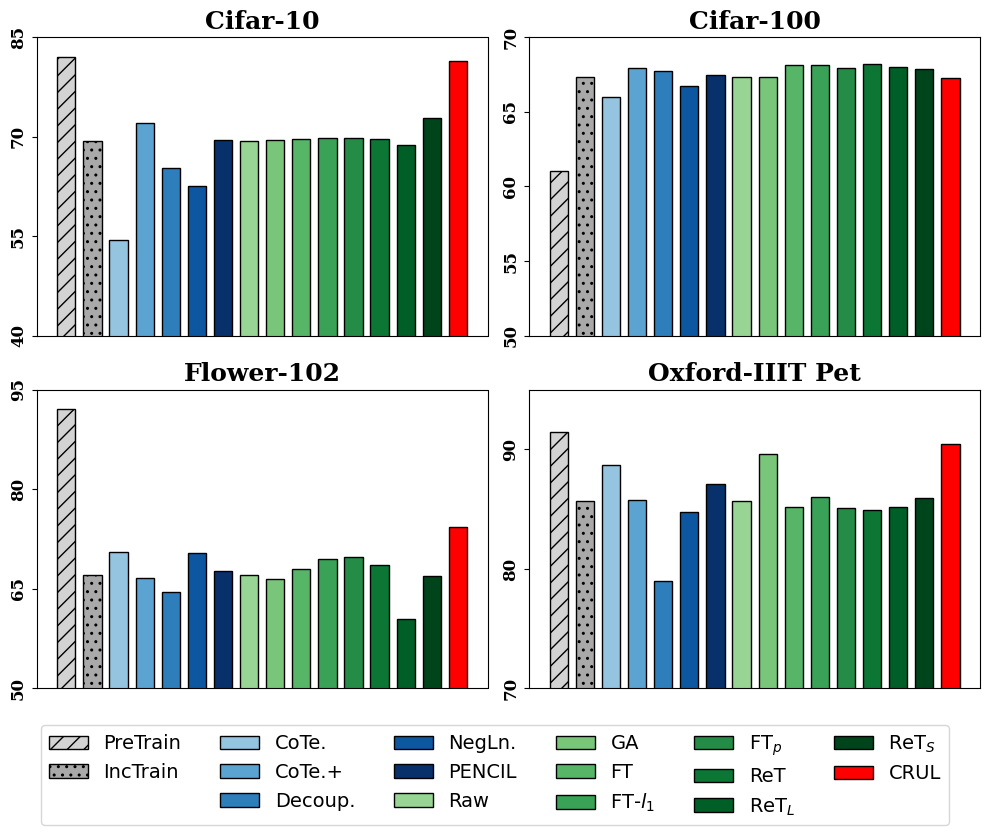

In [153]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from math import pi
import numpy as np

plt.style.use("default")

# # Load the Excel file to understand its content
# file_path = './test_data/main_result_demo.xlsx'
# xls = pd.ExcelFile(file_path)

# # Load the content of the first sheet to understand the data
# sheet1_df = pd.read_excel(xls, sheet_name='Sheet1')

# TODO-241108 [sunzekun] 更改为merged之后的csv文件
file_path = './results_cvpr/main/merged.csv'
sheet1_df = pd.read_csv(file_path, index_col=0)



# Defining method categories
lnl_methods = ['Coteaching', 'Coteachingplus', 'Decoupling', 'NegativeLearning', 'PENCIL']
unlearning_methods = ['raw', 'GA', 'FT', 'FT_l1', 'FT_prune', 'retrain', 'retrain_ls', 'retrain_sam']
# baseline_methods = ['pretrain', 'noise-train', 'finetune']
# baseline_methods = ['pretrain', 'inc_train', 'finetune']
baseline_methods = ['pretrain', 'inc_train']  # 24-11-08 仅保留pretrain 和 inc_train



# # Dataset names
# datasets = ['sym-cifar-10', 'asym-cifar-100', 'sym-flower-102', 'asym-pet-37']

# TODO-241108 [sunzekun] 先统一为merged.csv中的文件名格式。后续在图上显示的数据集名称会再用字典进行转换
# datasets = ['sym-cifar-10', 'asym-cifar-100', 'sym-flower-102', 'asym-pet-37']
datasets = ['cifar-10_sym', 'cifar-100_asym', 'flower-102_sym', 'pet-37_asym']
display_name_dataset = {
    'cifar-10_sym' : 'Cifar-10', 
    'cifar-100_asym': 'Cifar-100', 
    'flower-102_sym': 'Flower-102', 
    'pet-37_asym' : 'Oxford-IIIT Pet'
}

display_name_legend = {
    'pretrain' : 'PreTrain', 
    'inc_train' : 'IncTrain', 
    'finetune': 'FineTune', 
    'Coteaching' : 'CoTe.', 
    'Coteachingplus': 'CoTe.+', 
    'Decoupling': 'Decoup.', 
    'NegativeLearning' : 'NegLn.', 
    'PENCIL' : 'PENCIL', 
    'raw': 'Raw', 
    'GA': 'GA', 
    'FT': 'FT', 
    'FT_l1': 'FT-$l_{1}$', 
    'FT_prune' : 'FT$_p$', 
    'retrain' : 'ReT', 
    'retrain_ls' : 'ReT$_L$', 
    'retrain_sam' : 'ReT$_S$', 
    'CRUL' : 'CRUL'
}


# # Creating 2x2 subplots to organize all four radar charts for each dataset with improved visualization and labels
# fig, axes = plt.subplots(2, 2, figsize=(20, 16), subplot_kw=dict(polar=True))
# axes = axes.flatten()


# # Colors for categories
# lnl_color = 'dodgerblue'
# unlearning_color = 'forestgreen'
# baseline_color = 'darkorange'
# crul_color = 'red'
# noise_train_color = 'purple'


# for idx, dataset_name in enumerate(datasets):
#     # Preparing data for radar chart for each dataset
#     data_subset = sheet1_df[sheet1_df['dataset'] == dataset_name]

#     # Reorder categories to place 'CRUL' next to 'finetune'
#     reordered_columns = ['pretrain', 'noise-train', 'finetune', 'CRUL'] + [col for col in data_subset.columns[2:] if col not in ['pretrain', 'noise-train', 'finetune', 'CRUL']]
#     data_subset = data_subset[reordered_columns]

#     categories = list(data_subset.columns)  # Including all columns in new order
#     values = data_subset.iloc[0].tolist()
#     values += values[:1]  # Closing the circle for radar chart
    
#     # Number of variables
#     N = len(categories)
    
#     # Angle of each axis
#     angles = [n / float(N) * 2 * pi for n in range(N)]
#     angles += angles[:1]
    
#     ax = axes[idx]
    
#     # Plotting data for each dataset
#     ax.plot(angles, values, linewidth=2, linestyle='solid', color='gray')
#     ax.fill(angles, values, alpha=0.2, color='gray')
    
#     # Highlighting different method categories
#     for i, category in enumerate(categories):
#         if category in lnl_methods:
#             ax.plot([angles[i], angles[i]], [0, values[i]], color=lnl_color, linewidth=3)
#         elif category in unlearning_methods:
#             ax.plot([angles[i], angles[i]], [0, values[i]], color=unlearning_color, linewidth=3)
#         elif category == 'CRUL':
#             ax.plot([angles[i], angles[i]], [0, values[i]], color=crul_color, linewidth=4, linestyle='-', marker='o')
#         elif category == 'noise-train':
#             ax.plot([angles[i], angles[i]], [0, values[i]], color=noise_train_color, linewidth=3, linestyle='--', marker='s')
#         elif category in baseline_methods:
#             ax.plot([angles[i], angles[i]], [0, values[i]], color=baseline_color, linewidth=3, linestyle='--')
    
#     # Adding categories as labels
#     ax.set_xticks(angles[:-1])
#     ax.set_xticklabels(categories, fontsize=12)
    
#     # Adding dataset-specific title
#     ax.set_title(f'Dataset: {dataset_name}', size=16, y=1.1)

# # Adding a main title and adjusting layout
# fig.suptitle('Comparison of Methods Across Different Datasets', fontsize=20, y=1.05)
# fig.legend(['Label Noise Learning (LNL) Methods', 'Machine Unlearning Methods', 'Baseline Methods (Pretrain, Noise-Train, Finetune)', 'CRUL (Proposed Method)', 'Noise-Train (Repair Target)'],
#            loc='upper center', ncol=2, fontsize=14, frameon=False)

# plt.tight_layout(rect=[0, 0.05, 1, 0.95])
# plt.show()

# Creating a bar chart to compare accuracy across methods for each dataset
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
width = 0.7  # Increased the width of the bars for better visibility
tfs = 12 # x/y-ticks font size
title_size = 18 # Title font size
lfs = 14 # Legend-font-size

# Colors for different categories
baseline_colors = ['lightgrey', 'darkgrey', 'silver']
lnl_colors = plt.cm.Blues(np.linspace(0.4, 1, 5))
unlearning_colors = plt.cm.Greens(np.linspace(0.4, 1, 8))
crul_color = 'red'


# Plotting each dataset in a separate subplot
for idx, dataset in enumerate(datasets):
    ax = axes[idx]
    x = np.arange(len(baseline_methods) + len(lnl_methods) + len(unlearning_methods) + 1)  # the label locations
    
    # Plotting baseline methods (pretrain, noise-train, finetune)
    for i, method in enumerate(baseline_methods):
        # ax.bar(x[i], sheet1_df.loc[sheet1_df['dataset'] == dataset, method].values[0], width, label=method, color=baseline_colors[i], edgecolor='black', hatch=['//', '\\', '..'][i])
        # ax.bar(x[i], sheet1_df.loc[dataset, method], width, label=method, color=baseline_colors[i], edgecolor='black', hatch=['//', '\\', '..'][i])
        ax.bar(x[i], sheet1_df.loc[dataset, method], width, label=method, color=baseline_colors[i], edgecolor='black', hatch=['//', '..'][i]) # 仅保留 pretrain和inc_train

    # Plotting LNL methods
    for i, method in enumerate(lnl_methods):
        # ax.bar(x[len(baseline_methods) + i], sheet1_df.loc[sheet1_df['dataset'] == dataset, method].values[0], width, label=method, color=lnl_colors[i], edgecolor='black')
        ax.bar(x[len(baseline_methods) + i], sheet1_df.loc[dataset, method], width, label=method, color=lnl_colors[i], edgecolor='black')

    # Plotting Unlearning methods
    for i, method in enumerate(unlearning_methods):
        # ax.bar(x[len(baseline_methods) + len(lnl_methods) + i], sheet1_df.loc[sheet1_df['dataset'] == dataset, method].values[0], width, label=method, color=unlearning_colors[i], edgecolor='black')
        ax.bar(x[len(baseline_methods) + len(lnl_methods) + i], sheet1_df.loc[dataset, method], width, label=method, color=unlearning_colors[i], edgecolor='black')

    # Plotting CRUL method
    # ax.bar(x[-1], sheet1_df.loc[sheet1_df['dataset'] == dataset, 'CRUL'].values[0], width, label='CRUL', color=crul_color, edgecolor='black')
    ax.bar(x[-1], sheet1_df.loc[dataset, 'CRUL'], width, label='CRUL', color=crul_color, edgecolor='black')


    # Adding labels, title, and legend
    # ax.set_xlabel('Methods', fontsize=12)
    # ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title(f'{display_name_dataset[dataset]}', fontsize=title_size, fontfamily="serif", weight="bold")
    # ax.set_xticks(x)
    # ax.set_xticklabels(baseline_methods + lnl_methods + unlearning_methods + ['CRUL'], rotation=45, ha='right', fontsize=10)

    ax.set_xticks([]) # 关闭x轴显示


# --------------------------------------------------------------------------------- #
"""
手动修正四个子图各自的坐标值范围。
# """
# # Cifar-10
axes[0].set_ylim(40, 85)
axes[0].set_yticks(np.arange(40, 91, 15))
axes[0].set_yticklabels(
            np.arange(40, 91, 15),
            fontsize=tfs,
            rotation=90,
            va="center",
            fontfamily="serif",
            weight="bold",
        )


# Cifar-100
axes[1].set_ylim(50, 70)
axes[1].set_yticks(np.arange(50, 71, 5))
axes[1].set_yticklabels(
            np.arange(50, 71, 5),
            fontsize=tfs,
            rotation=90,
            va="center",
            fontfamily="serif",
            weight="bold",
        )

# Flower-102
axes[2].set_ylim(50, 95)
axes[2].set_yticks(np.arange(50, 96, 15))
axes[2].set_yticklabels(
            np.arange(50, 96, 15),
            fontsize=tfs,
            rotation=90,
            va="center",
            fontfamily="serif",
            weight="bold",
        )


# Pet-37
axes[3].set_ylim(70, 95)
axes[3].set_yticks(np.arange(70, 96, 10))
axes[3].set_yticklabels(
            np.arange(70, 96, 10),
            fontsize=tfs,
            rotation=90,
            va="center",
            fontfamily="serif",
            weight="bold",
        )


# --------------------------------------------------------------------------------- #
# Adding a main title and adjusting layout
# fig.suptitle('Bar Chart Comparison of Methods Across Different Datasets', fontsize=20, y=1.05)
# fig.tight_layout(rect=[0, 0.05, 1, 0.95])

handles, legend_labels = fig.axes[0].get_legend_handles_labels()

labels = [display_name_legend[ll] for ll in legend_labels]

# fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.1, 0.5))

legend_font_properties = fm.FontProperties(
                                        #    weight='bold', 
                                           size=lfs)

from matplotlib.lines import Line2D
empty_handle = Line2D([], [], color='none')  # 创建一个空的占位符

# 在第二个 legend 之后插入占位符
handles.insert(2, empty_handle)
labels.insert(2, '')  # 对应的标签留空


# # 在第二个 legend 之后插入占位符
# handles.insert(8, empty_handle)
# labels.insert(8, '')  # 对应的标签留空

# # 在第二个 legend 之后插入占位符
# handles.insert(17, empty_handle)
# labels.insert(17, '')  # 对应的标签留空

fig.legend(handles, labels, loc='lower center', 
           bbox_to_anchor=(0.5, -0.05), ncol=6,
           prop=legend_font_properties)

fig.tight_layout(rect=[0, 0.1, 1, 1])

plt.show()


## （参考）敏感度实验参考

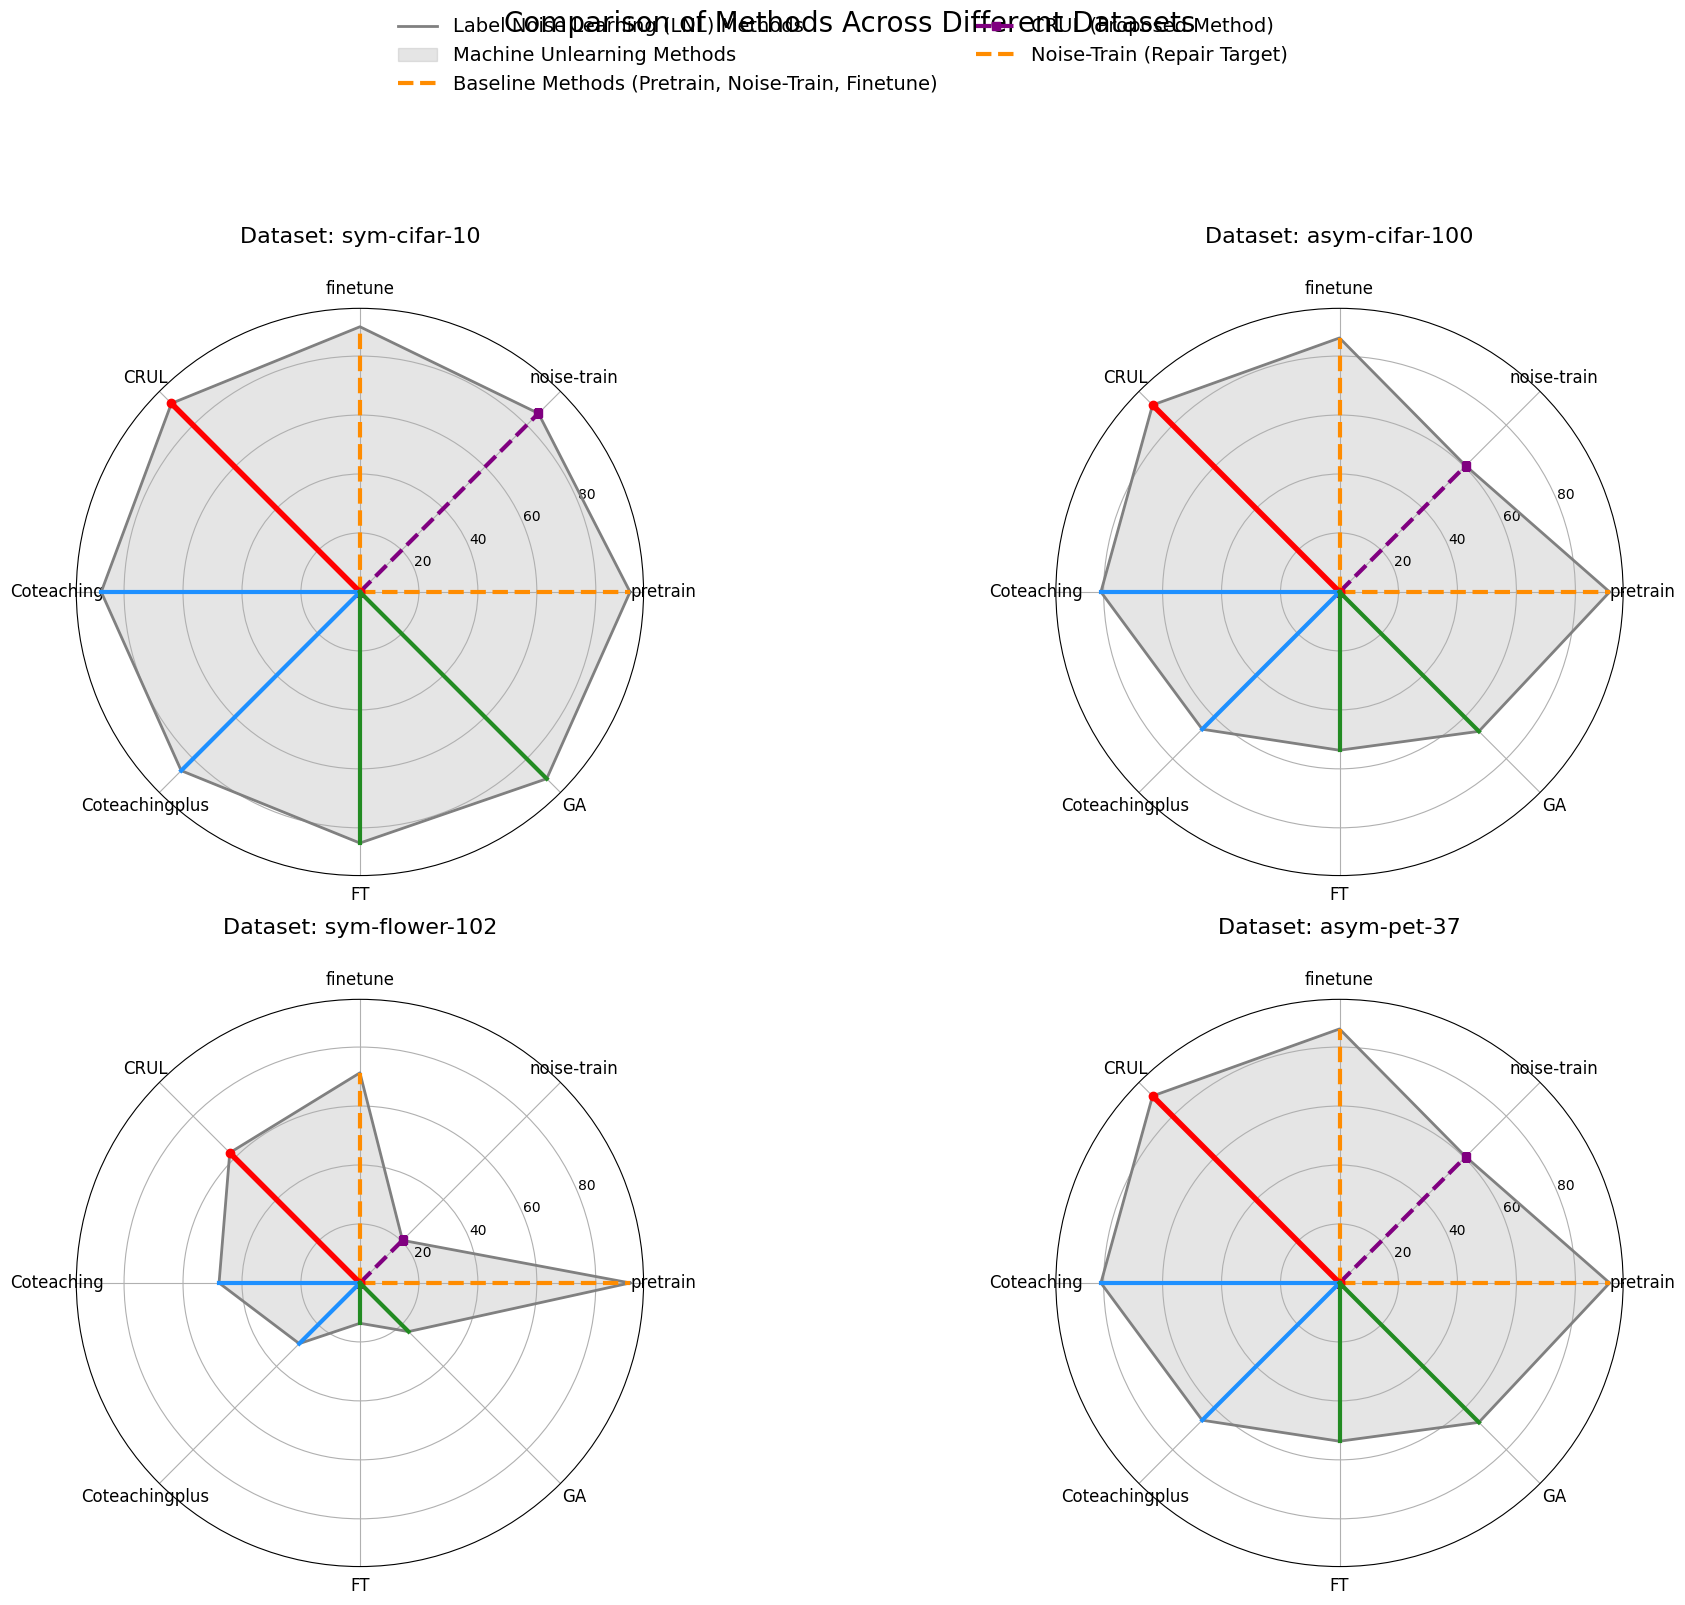

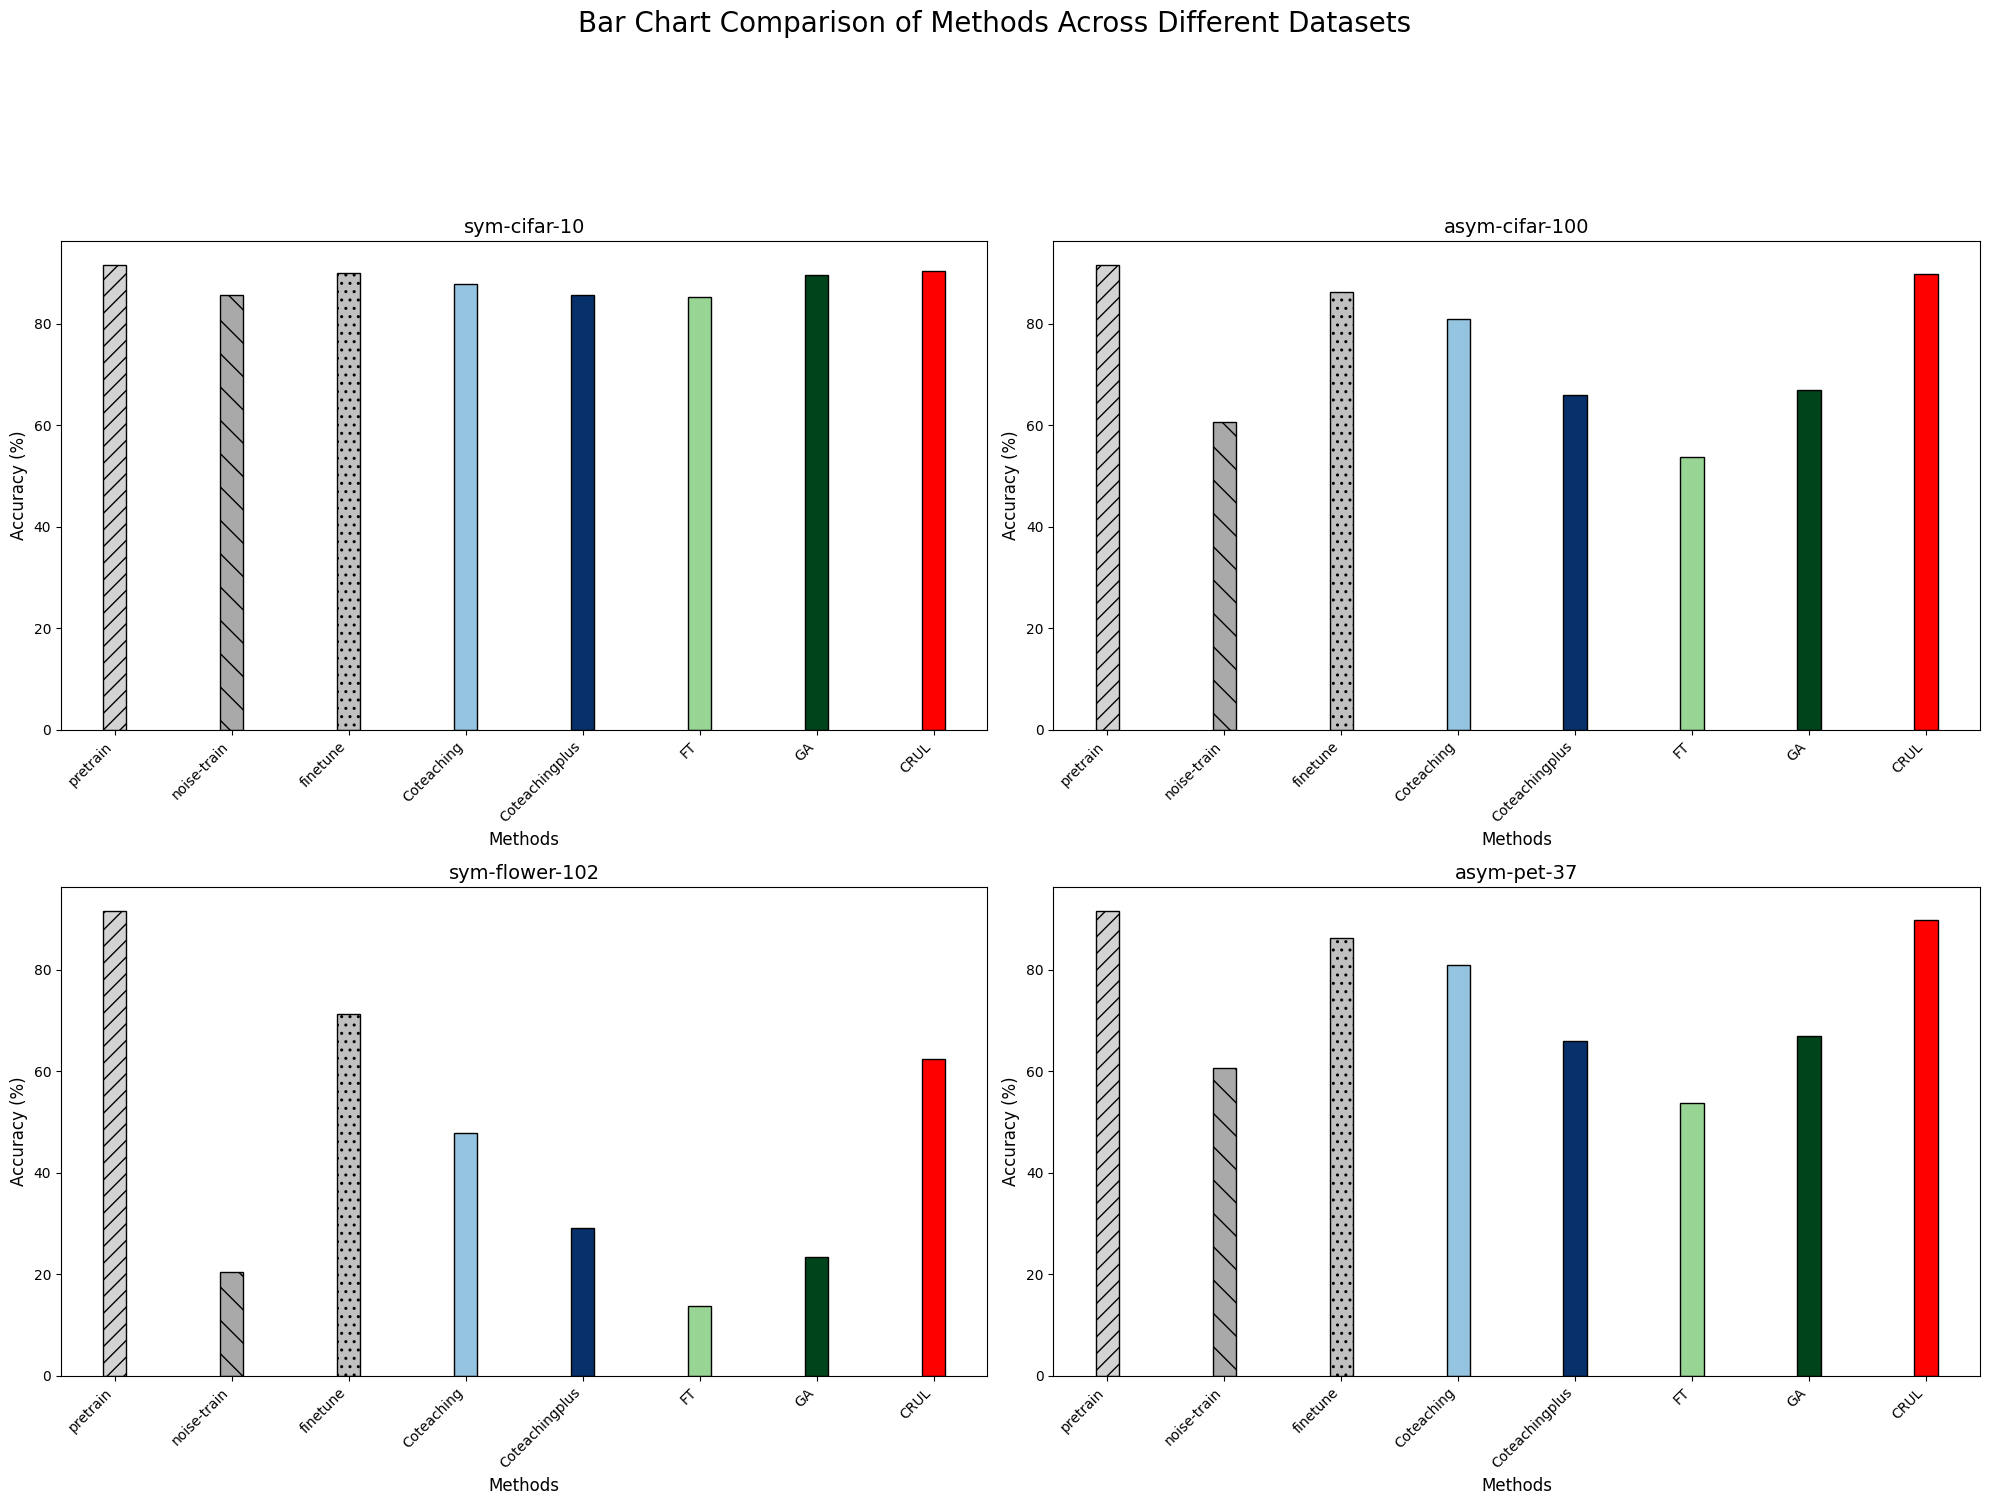

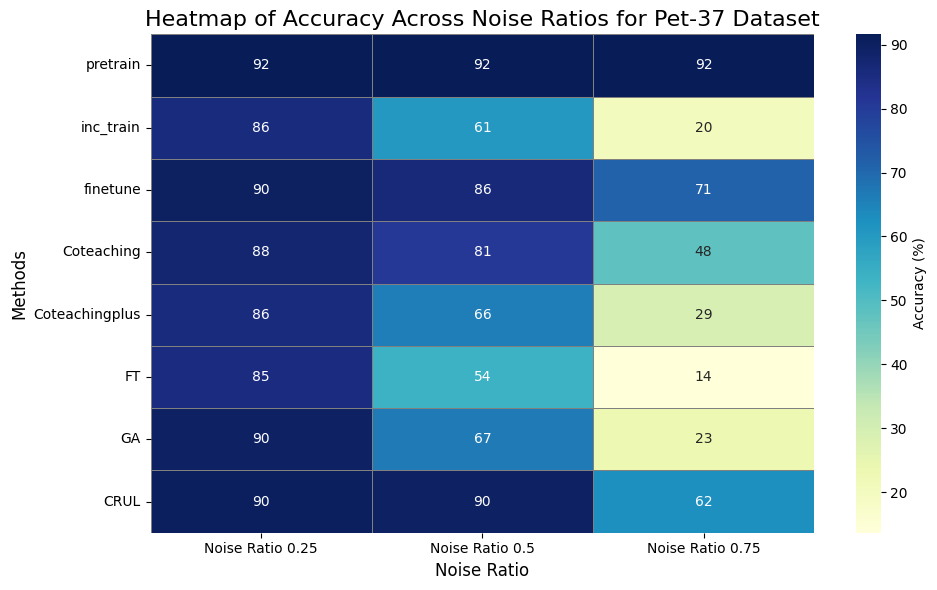

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
import numpy as np
import seaborn as sns

plt.style.use("default")

# Defining the dataset directly in the code
data = {
    'dataset': ['sym-cifar-10', 'asym-cifar-100', 'sym-flower-102', 'asym-pet-37'],
    'pretrain': [91.61, 91.61, 91.61, 91.61],
    'noise-train': [85.64, 60.53, 20.44, 60.53],
    'finetune': [89.94, 86.15, 71.27, 86.15],
    'Coteaching': [87.74, 80.92, 47.78, 80.92],
    'Coteachingplus': [85.72, 65.85, 29.11, 65.85],
    'FT': [85.17, 53.69, 13.68, 53.69],
    'GA': [89.59, 66.86, 23.33, 66.86],
    'CRUL': [90.43, 89.67, 62.44, 89.67]
}

# Creating DataFrame from the dictionary
sheet1_df = pd.DataFrame(data)

# Creating 2x2 subplots to organize all four radar charts for each dataset with improved visualization and labels
fig, axes = plt.subplots(2, 2, figsize=(20, 16), subplot_kw=dict(polar=True))
axes = axes.flatten()

# Defining method categories
lnl_methods = ['Coteaching', 'Coteachingplus']
unlearning_methods = ['FT', 'GA']
baseline_methods = ['pretrain', 'noise-train', 'finetune']

# Dataset names
datasets = ['sym-cifar-10', 'asym-cifar-100', 'sym-flower-102', 'asym-pet-37']

# Colors for categories
lnl_color = 'dodgerblue'
unlearning_color = 'forestgreen'
baseline_color = 'darkorange'
crul_color = 'red'
noise_train_color = 'purple'

for idx, dataset_name in enumerate(datasets):
    # Preparing data for radar chart for each dataset
    data_subset = sheet1_df[sheet1_df['dataset'] == dataset_name]

    # Reorder categories to place 'CRUL' next to 'finetune'
    reordered_columns = ['pretrain', 'noise-train', 'finetune', 'CRUL'] + [col for col in data_subset.columns[2:] if col not in ['pretrain', 'noise-train', 'finetune', 'CRUL']]
    data_subset = data_subset[reordered_columns]

    categories = list(data_subset.columns)  # Including all columns in new order
    values = data_subset.iloc[0].tolist()
    values += values[:1]  # Closing the circle for radar chart
    
    # Number of variables
    N = len(categories)
    
    # Angle of each axis
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    ax = axes[idx]
    
    # Plotting data for each dataset
    ax.plot(angles, values, linewidth=2, linestyle='solid', color='gray')
    ax.fill(angles, values, alpha=0.2, color='gray')
    
    # Highlighting different method categories
    for i, category in enumerate(categories):
        if category in lnl_methods:
            ax.plot([angles[i], angles[i]], [0, values[i]], color=lnl_color, linewidth=3)
        elif category in unlearning_methods:
            ax.plot([angles[i], angles[i]], [0, values[i]], color=unlearning_color, linewidth=3)
        elif category == 'CRUL':
            ax.plot([angles[i], angles[i]], [0, values[i]], color=crul_color, linewidth=4, linestyle='-', marker='o')
        elif category == 'noise-train':
            ax.plot([angles[i], angles[i]], [0, values[i]], color=noise_train_color, linewidth=3, linestyle='--', marker='s')
        elif category in baseline_methods:
            ax.plot([angles[i], angles[i]], [0, values[i]], color=baseline_color, linewidth=3, linestyle='--')
    
    # Adding categories as labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=12)
    
    # Adding dataset-specific title
    ax.set_title(f'Dataset: {dataset_name}', size=16, y=1.1)

# Adding a main title and adjusting layout
fig.suptitle('Comparison of Methods Across Different Datasets', fontsize=20, y=1.05)
fig.legend(['Label Noise Learning (LNL) Methods', 'Machine Unlearning Methods', 'Baseline Methods (Pretrain, Noise-Train, Finetune)', 'CRUL (Proposed Method)', 'Noise-Train (Repair Target)'],
           loc='upper center', ncol=2, fontsize=14, frameon=False)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

# Creating a bar chart to compare accuracy across methods for each dataset
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()
width = 0.2  # Increased the width of the bars for better visibility

# Colors for different categories
baseline_colors = ['lightgrey', 'darkgrey', 'silver']
lnl_colors = plt.cm.Blues(np.linspace(0.4, 1, len(lnl_methods)))
unlearning_colors = plt.cm.Greens(np.linspace(0.4, 1, len(unlearning_methods)))
crul_color = 'red'

# Plotting each dataset in a separate subplot
for idx, dataset in enumerate(datasets):
    ax = axes[idx]
    x = np.arange(len(baseline_methods) + len(lnl_methods) + len(unlearning_methods) + 1)  # the label locations
    
    # Plotting baseline methods (pretrain, noise-train, finetune)
    for i, method in enumerate(baseline_methods):
        ax.bar(x[i], sheet1_df.loc[sheet1_df['dataset'] == dataset, method].values[0], width, label=method, color=baseline_colors[i], edgecolor='black', hatch=['//', '\\', '..'][i])

    # Plotting LNL methods
    for i, method in enumerate(lnl_methods):
        ax.bar(x[len(baseline_methods) + i], sheet1_df.loc[sheet1_df['dataset'] == dataset, method].values[0], width, label=method, color=lnl_colors[i], edgecolor='black')

    # Plotting Unlearning methods
    for i, method in enumerate(unlearning_methods):
        ax.bar(x[len(baseline_methods) + len(lnl_methods) + i], sheet1_df.loc[sheet1_df['dataset'] == dataset, method].values[0], width, label=method, color=unlearning_colors[i], edgecolor='black')

    # Plotting CRUL method
    ax.bar(x[-1], sheet1_df.loc[sheet1_df['dataset'] == dataset, 'CRUL'].values[0], width, label='CRUL', color=crul_color, edgecolor='black')

    # Adding labels, title, and legend
    ax.set_xlabel('Methods', fontsize=12)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title(f'{dataset}', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(baseline_methods + lnl_methods + unlearning_methods + ['CRUL'], rotation=45, ha='right', fontsize=10)

# Adding a main title and adjusting layout
fig.suptitle('Bar Chart Comparison of Methods Across Different Datasets', fontsize=20, y=1.05)
fig.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

# Creating a heatmap for Pet-37 dataset across different noise ratios
heatmap_data = pd.DataFrame({
    'Noise Ratio 0.25': [91.61, 85.64, 89.94, 87.74, 85.72, 85.17, 89.59, 90.43],
    'Noise Ratio 0.5': [91.61, 60.53, 86.15, 80.92, 65.85, 53.69, 66.86, 89.67],
    'Noise Ratio 0.75': [91.61, 20.44, 71.27, 47.78, 29.11, 13.68, 23.33, 62.44]
},
    index=['pretrain', 'inc_train', 'finetune', 'Coteaching', 'Coteachingplus', 'FT', 'GA', 'CRUL']
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Accuracy (%)'})
plt.title('Heatmap of Accuracy Across Noise Ratios for Pet-37 Dataset', fontsize=16)
plt.xlabel('Noise Ratio', fontsize=12)
plt.ylabel('Methods', fontsize=12)
plt.tight_layout()
plt.show()


## TSNE 展示

### Pet37-asym


In [11]:
import json
from configs import settings
import numpy as np


def load_classes_from_file(file_path):
    """从文件中读取类别列表"""
    with open(file_path, "r") as f:
        classes = [line.strip() for line in f.readlines()]
    return classes


def load_pet37_superclass_mapping(file_path):
    """从JSON文件中加载 Oxford-Pets 的类别映射"""
    with open(file_path, "r") as f:
        pet37_superclass_to_child = json.load(f)
    return pet37_superclass_to_child


def build_asymmetric_mapping(superclass_mapping, classes, rng):
    """构建非对称标签映射，确保标签替换为同superclass内的其他类"""
    child_to_superclass_mapping = {}

    # 构建child class到superclass的反向映射
    for superclass, child_classes in superclass_mapping.items():
        for child_class in child_classes:
            child_to_superclass_mapping[child_class] = (superclass, child_classes)

    # 构建非对称映射表
    asymmetric_mapping = {}
    for class_name in classes:
        # 获取该类别所属的大类（superclass）以及该大类中的所有类别
        if class_name in child_to_superclass_mapping:
            superclass, child_classes = child_to_superclass_mapping[class_name]
            # 在同一superclass中随机选择一个不同的类别作为替换
            available_classes = [c for c in child_classes if c != class_name]
            if available_classes:
                new_class = rng.choice(available_classes)
                asymmetric_mapping[class_name] = new_class
            else:
                asymmetric_mapping[class_name] = (
                    class_name  # 如果没有其他类别，则保持原标签不变
                )
    return asymmetric_mapping


pet37_classes_file = os.path.join(
    settings.root_dir, "configs/classes/pet_37_classes.txt"
)
pet37_classes = load_classes_from_file(pet37_classes_file)

pet37_mapping_file = os.path.join(
    settings.root_dir, "configs/classes/pet_37_mapping.json"
)
pet37_superclass_mapping = load_pet37_superclass_mapping(pet37_mapping_file)

# print("PET-37 Classes:", pet37_classes)

rng = np.random.default_rng(42)

asymmetric_mapping = build_asymmetric_mapping(
    pet37_superclass_mapping, pet37_classes, rng
)
# print(asymmetric_mapping)
# print(pet37_superclass_mapping)

cat_index = []
for class_name in pet37_superclass_mapping["cat"]:
    # print(class_name)
    # print(pet37_classes.index(class_name))
    cat_index.append(pet37_classes.index(class_name))
print("Cat-index:", cat_index)

dog_index = []
for class_name in pet37_superclass_mapping["dog"]:
    # print(class_name)
    # print(pet37_classes.index(class_name))
    dog_index.append(pet37_classes.index(class_name))
print("Dog-index:", dog_index)

pair_index = []
for key, value in asymmetric_mapping.items():
    # print(key, value)
    pair_index.append(pet37_classes.index(key))
    pair_index.append(pet37_classes.index(value))
print("Pair-index:", pair_index)

Cat-index: [0, 5, 6, 7, 9, 11, 20, 23, 26, 27, 32, 33]
Dog-index: [1, 2, 3, 4, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 24, 25, 28, 29, 30, 31, 34, 35, 36]
Pair-index: [0, 5, 1, 29, 2, 24, 3, 17, 4, 17, 5, 32, 6, 0, 7, 26, 8, 10, 9, 5, 10, 19, 11, 33, 12, 28, 13, 29, 14, 28, 15, 29, 16, 19, 17, 4, 18, 31, 19, 16, 20, 11, 21, 14, 22, 8, 23, 33, 24, 29, 25, 22, 26, 9, 27, 32, 28, 19, 29, 16, 30, 16, 31, 10, 32, 5, 33, 20, 34, 31, 35, 2, 36, 30]


2024-11-09 17:03:23,736 - INFO - Loading test data from: /nvme/szh/code/tta-mr/data/pet-37/gen/test_data.npy


2024-11-09 17:03:24,329 - INFO - Test data loaded with shape: (3669, 3, 224, 224), Test labels loaded with shape: (3669,)
2024-11-09 17:03:24,460 - INFO - Dataset initialized with data shape: (3669, 3, 224, 224) and labels shape: (3669,)
2024-11-09 17:03:24,461 - INFO - Currently testing dataset: pet-37 with 37 classes.
2024-11-09 17:03:24,461 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/pet-37/pretrain/wideresnet50_pretrain.pth
2024-11-09 17:03:25,271 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/pet-37/pretrain/wideresnet50_pretrain.pth
2024-11-09 17:03:36,343 - INFO - Loading test data from: /nvme/szh/code/tta-mr/data/pet-37/gen/test_data.npy


缓存tsne结果至：/nvme/szh/code/tta-mr/result_analysis/results_cvpr/tsne/pet-37/asym/pretrain/tsne.npz


2024-11-09 17:03:36,943 - INFO - Test data loaded with shape: (3669, 3, 224, 224), Test labels loaded with shape: (3669,)
2024-11-09 17:03:37,073 - INFO - Dataset initialized with data shape: (3669, 3, 224, 224) and labels shape: (3669,)
2024-11-09 17:03:37,074 - INFO - Currently testing dataset: pet-37 with 37 classes.
2024-11-09 17:03:37,074 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_cvpr/wideresnet50_inc_train.pth
2024-11-09 17:03:37,912 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_cvpr/wideresnet50_inc_train.pth
2024-11-09 17:03:47,969 - INFO - Loading test data from: /nvme/szh/code/tta-mr/data/pet-37/gen/test_data.npy


缓存tsne结果至：/nvme/szh/code/tta-mr/result_analysis/results_cvpr/tsne/pet-37/asym/inc_train/tsne.npz


2024-11-09 17:03:48,553 - INFO - Test data loaded with shape: (3669, 3, 224, 224), Test labels loaded with shape: (3669,)
2024-11-09 17:03:48,684 - INFO - Dataset initialized with data shape: (3669, 3, 224, 224) and labels shape: (3669,)
2024-11-09 17:03:48,685 - INFO - Currently testing dataset: pet-37 with 37 classes.
2024-11-09 17:03:48,686 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_cvpr/Coteaching/wideresnet50_restore.pth
2024-11-09 17:03:49,508 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_cvpr/Coteaching/wideresnet50_restore.pth
2024-11-09 17:03:58,480 - INFO - Loading test data from: /nvme/szh/code/tta-mr/data/pet-37/gen/test_data.npy


缓存tsne结果至：/nvme/szh/code/tta-mr/result_analysis/results_cvpr/tsne/pet-37/asym/Coteaching/tsne.npz


2024-11-09 17:03:59,074 - INFO - Test data loaded with shape: (3669, 3, 224, 224), Test labels loaded with shape: (3669,)
2024-11-09 17:03:59,205 - INFO - Dataset initialized with data shape: (3669, 3, 224, 224) and labels shape: (3669,)
2024-11-09 17:03:59,206 - INFO - Currently testing dataset: pet-37 with 37 classes.
2024-11-09 17:03:59,206 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_cvpr/wfisher/wideresnet50_restore.pth
2024-11-09 17:04:00,055 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_cvpr/wfisher/wideresnet50_restore.pth
2024-11-09 17:04:11,211 - INFO - Loading test data from: /nvme/szh/code/tta-mr/data/pet-37/gen/test_data.npy


缓存tsne结果至：/nvme/szh/code/tta-mr/result_analysis/results_cvpr/tsne/pet-37/asym/wfisher/tsne.npz


2024-11-09 17:04:11,800 - INFO - Test data loaded with shape: (3669, 3, 224, 224), Test labels loaded with shape: (3669,)
2024-11-09 17:04:11,930 - INFO - Dataset initialized with data shape: (3669, 3, 224, 224) and labels shape: (3669,)
2024-11-09 17:04:11,931 - INFO - Currently testing dataset: pet-37 with 37 classes.
2024-11-09 17:04:11,931 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_cvpr/CRUL/wideresnet50_restore.pth
2024-11-09 17:04:12,722 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_cvpr/CRUL/wideresnet50_restore.pth


缓存tsne结果至：/nvme/szh/code/tta-mr/result_analysis/results_cvpr/tsne/pet-37/asym/CRUL/tsne.npz


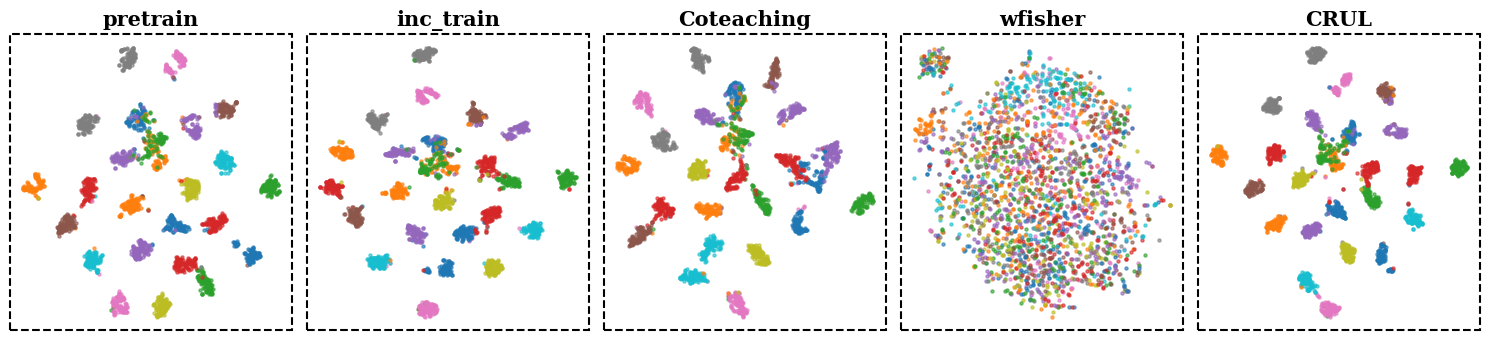

In [15]:
import warnings

warnings.filterwarnings("ignore")

import os
import sys

# 添加项目根目录到 sys.path
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(project_root)


import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from core_model.custom_model import ClassifierWrapper, load_custom_model
from configs import settings
import logging
from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as TSNE

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up logging for better visibility
logging.basicConfig(
    level=logging.INFO,
    format="\033[1;36m%(asctime)s - %(levelname)s - %(message)s\033[0m",
)
logger = logging.getLogger(__name__)


class BaseTensorDataset(Dataset):
    def __init__(self, data, labels, transforms=None, device=None):
        self.data = torch.as_tensor(data, device=device)
        self.labels = torch.as_tensor(labels, device=device)
        self.transforms = transforms
        logger.info(
            f"Dataset initialized with data shape: {data.shape} and labels shape: {labels.shape}"
        )

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        if self.transforms is not None:
            self.transforms(data)

        return data, self.labels[index]


def get_model_path(dataset_name, model_name, method):

    # TODO-241105 [sunzekun] 新的参数读取路径规则，先做初步测试用，对各个数据集需要分别根据文档的设定手写case（主要变的是noise_ratio)
    base_ckpt_path = (
        f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_0.5_nt_asymmetric_cvpr"
    )
    if method == "pretrain":
        return f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/pretrain/{model_name}_pretrain.pth"
    elif method == "inc_train":
        return os.path.join(base_ckpt_path, f"{model_name}_inc_train.pth")
    else:
        return os.path.join(base_ckpt_path, method, f"{model_name}_restore.pth")


def load_model_and_data(dataset_name, model_name, method):
    """
    加载模型及其对应的测试数据集，并返回模型和数据加载器
    """
    # 更改数据集为 pet-37
    # dataset_name = "pet-37"  # 使用 Oxford-IIIT Pet 数据集

    num_classes = settings.num_classes_dict[dataset_name]

    # 加载测试数据集
    # Load test dataset
    batch_size = 64
    test_data_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_data.npy"
    test_label_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_label.npy"

    try:
        logger.info(f"Loading test data from: {test_data_path}")
        test_data = np.load(test_data_path)
        test_labels = np.load(test_label_path)
        logger.info(
            f"Test data loaded with shape: {test_data.shape}, Test labels loaded with shape: {test_labels.shape}"
        )
        test_dataset = BaseTensorDataset(test_data, test_labels, device=device)
        test_dataloader = DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, num_workers=0
        )
    except FileNotFoundError as e:
        logger.error(f"Error loading test dataset: {e}")
        return

    # 加载模型
    num_classes = settings.num_classes_dict[dataset_name]
    logger.info(
        f"Currently testing dataset: {dataset_name} with {num_classes} classes."
    )

    model_path = get_model_path(dataset_name, model_name, method)
    logger.info(f"Evaluating model from path: {model_path}")

    # Load model architecture and weights
    model = load_custom_model(model_name, num_classes, load_pretrained=False)
    model = ClassifierWrapper(model, num_classes)
    try:
        checkpoint = torch.load(model_path, map_location=device)
        logger.info(f"Loaded model checkpoint from {model_path}")
    except FileNotFoundError:
        logger.error(f"Cannot find the weight file at {model_path}. Skipping.")
        return
    model.load_state_dict(checkpoint, strict=False)

    model.eval()
    model.to(device)

    return model, test_dataloader, test_labels


# 获取嵌入数据
def get_embeddings(model, dataloader, layer_name="feature_model"):
    """
    提取模型的嵌入层输出
    """
    embeddings = []
    labels = []

    # 注册hook来捕获指定层的输出
    def hook_fn(module, input, output):
        embeddings.append(output.detach().cpu().numpy())

    handle = model._modules.get(layer_name).register_forward_hook(hook_fn)

    # 进行前向传播以获取嵌入
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            model(inputs)
            labels.extend(targets.cpu().numpy())

    handle.remove()

    # 拼接所有批次的嵌入和标签
    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.array(labels)
    return embeddings, labels


def get_cache_path_tsne(dataset_name, case, unique_name):
    root_dir = os.path.abspath(os.path.join(os.getcwd(), os.path.pardir))

    path = os.path.join(
        root_dir,
        "result_analysis/results_cvpr/tsne",
        dataset_name,
        case,
        unique_name,
    )
    os.makedirs(path, exist_ok=True)

    return os.path.join(path, f"tsne.npz")


# 绘制 t-SNE
def get_tsne(model, dataloader, class_range=None):
    """
    绘制多个step的t-SNE结果，展示不同方法在不同步骤的嵌入变化
    """
    embeddings, labels = get_embeddings(model, dataloader)

    if class_range is not None:
        mask = np.isin(labels, class_range)
        embeddings = embeddings[mask]
        labels = labels[mask]

    # PCA 降维
    pca = PCA(n_components=50)
    
    # pca = PCA(n_components=100)
    pca_result = pca.fit_transform(embeddings)

    # t-SNE降维
    tsne = TSNE(n_components=2, n_jobs=8, random_state=42)
    tsne_result = tsne.fit_transform(pca_result)

    return tsne_result, labels


def plot_tsne(
    methods,
    dataset_name,
    model_name,
    noise_type,
    class_range=None,
    title=None,
    use_cache=False,
):
    # 本实验中简化了case的使用，直接改为由noise-type来决定特定的名字（有需要再换回去）
    case = "sym" if noise_type == "symmetric" else "asym"

    plt.style.use("default")
    fig, axs = plt.subplots(1, len(methods), figsize=(3 * len(methods), 3.5))
    fig.subplots_adjust(hspace=0.6, wspace=0.6)  # 增加子图之间的边距，保证美观

    tsne_results_all = {}

    for method in methods:
        model = None
        dataloader = None
        cache_path = get_cache_path_tsne(
            dataset_name=dataset_name, case=case, unique_name=method
        )
        if use_cache:
            try:
                data = np.load(cache_path)
                tsne = data["tsne"]
                labels = data["labels"]
                print(f"读取缓存的tsne记录：{cache_path}")
            except FileNotFoundError:
                print("未读取到对应的tsne。首次评估某个模型时，请先使用use_cache=False")
                if model is None or dataloader is None:
                    model, dataloader, _ = load_model_and_data(
                        dataset_name, model_name, method
                    )
                tsne, labels = get_tsne(model, dataloader, class_range)
                np.savez(cache_path, tsne=tsne, labels=labels)
                print(f"缓存tsne结果至：{cache_path}")
            tsne_results_all[method] = (tsne, labels)
        else:
            if model is None or dataloader is None:
                model, dataloader, _ = load_model_and_data(
                    dataset_name, model_name, method
                )
            tsne, labels = get_tsne(model, dataloader, class_range)
            np.savez(cache_path, tsne=tsne, labels=labels)
            print(f"缓存tsne结果至：{cache_path}")
            tsne_results_all[method] = (tsne, labels)

    # Plotting t-SNE results for the specified class range
    for method_idx, method in enumerate(methods):
        ax = axs[method_idx]
        tsne_result, labels = tsne_results_all.get(method, (None, None))
        if tsne_result is not None:
            unique_labels = np.unique(labels)
            for class_label in unique_labels:
                class_mask = labels == class_label
                ax.scatter(
                    tsne_result[class_mask, 0],
                    tsne_result[class_mask, 1],
                    s=5,
                    alpha=0.6,
                    label=f"Class {class_label}",
                )
            ax.set_title(f"{method}", fontsize=15, fontfamily="serif", weight="bold")
            ax.tick_params(axis="both", which="major", labelsize=15)
            ax.axis("off")
        else:
            ax.set_title(
                f"No data for {method}", fontsize=15, fontfamily="serif", weight="bold"
            )
            ax.axis("off")

    # Adding dashed black border around each subplot for visual distinction
    for ax in axs.flat:
        rect = plt.Rectangle(
            (0, 0),
            1,
            1,
            transform=ax.transAxes,
            color="black",
            linewidth=1.5,
            linestyle="--",
            fill=False,
            clip_on=False,
            zorder=10,
        )
        ax.add_patch(rect)

    if title:
        title_fs = 15  # 标题的字号大小
        plt.suptitle(title, fontsize=title_fs, fontfamily="serif", weight="bold")
    plt.tight_layout()
    # plt.savefig(f'tsne_visualization_{method}_step_{step}_{noise_type}_{class_type}.pdf', format='pdf', dpi=300)
    plt.show()


# # 通用配置字典
# def configure_plot(dataset_name, model_name, methods, steps, noise_type, noise_ratio, class_type):
#     if class_type == "forget":
#         class_range = list(range(18))
#         title = "t-SNE Visualization for Forget Classes"
#     elif class_type == "noise":
#         class_range = list(range(18, 28))
#         title = "t-SNE Visualization for Noise Classes"
#     else:  # full
#         class_range = None
#         title = "t-SNE Visualization for All Classes"
#     return class_range, title

# 执行 t-SNE 可视化

methods = [  # baseline方法，包括一些预训练，增量训练(raw, 仅在d1上训练) 和基础的baseline
    # 'pretrain', 'inc_train', 'finetune',
    "pretrain",
    "inc_train",
    # LNL方法
    # 'Coteaching', 'Coteachingplus', 'JoCoR', 'Decoupling', 'NegativeLearning', 'PENCIL',
    "Coteaching",
    # MU 方法
    # 'raw', 'GA', 'GA_l1', 'FT', 'FT_l1', 'fisher_new', 'wfisher', 'FT_prune', 'FT_prune_bi', 'retrain', 'retrain_ls', 'retrain_sam',
    "wfisher",
    # 我们的方法
    "CRUL",
]
dataset_name = "pet-37"  # 更改为 pet-37 数据集
noise_type = "asymmetric"
model_name = "wideresnet50"  # 确保模型适配 pet-37 数据集

# class_range = list(range(5, 15))  # 只展示前10个类
# class_range = [0, 5, 6, 7, 9, 11, 20, 23, 26, 27, 32, 33] # 猫的类别
# class_range = [

#     1,
#     2,
#     3,
#     4,
#     8,
#     10,
#     12,
#     13,
#     14,
#     15,
#     16,
#     17,
#     18,
#     19,
#     21,
#     22,
#     24,
#     25,
#     28,
#     29,
#     30,
#     31,
#     34,
#     35,
#     36,
# ]  # 狗的类别
class_range = [1, 2, 3, 4, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 24, 25, 28, 29, 30, 31, 34, 35, 36] # mapping 关系中，配对的label。选取了前5组。

'''
Cat-index: [0, 5, 6, 7, 9, 11, 20, 23, 26, 27, 32, 33]
Dog-index: [1, 2, 3, 4, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 24, 25, 28, 29, 30, 31, 34, 35, 36]
Pair-index: [0, 5, 1, 29, 2, 24, 3, 17, 4, 17, 5, 32, 6, 0, 7, 26, 8, 10, 9, 5, 10, 19, 11, 33, 12, 28, 13, 29, 14, 28, 15, 29, 16, 19, 17, 4, 18, 31, 19, 16, 20, 11, 21, 14, 22, 8, 23, 33, 24, 29, 25, 22, 26, 9, 27, 32, 28, 19, 29, 16, 30, 16, 31, 10, 32, 5, 33, 20, 34, 31, 35, 2, 36, 30]
'''
# class_range = None  # 只展示前10个类
title = None

plot_tsne(
    methods,
    dataset_name,
    model_name,
    noise_type,
    class_range=class_range,
    title=title,
    use_cache=False,
)

# plot_tsne(
#     methods, dataset_name, model_name, noise_type, class_range=class_range, title=title, use_cache=True
# )

### Cifar-10-sym


读取缓存的tsne记录：/nvme/sunzekun/Projects/tta-mr/result_analysis/results_cvpr/tsne/cifar-10/sym/pretrain/tsne.npz
读取缓存的tsne记录：/nvme/sunzekun/Projects/tta-mr/result_analysis/results_cvpr/tsne/cifar-10/sym/inc_train/tsne.npz
读取缓存的tsne记录：/nvme/sunzekun/Projects/tta-mr/result_analysis/results_cvpr/tsne/cifar-10/sym/Coteaching/tsne.npz
读取缓存的tsne记录：/nvme/sunzekun/Projects/tta-mr/result_analysis/results_cvpr/tsne/cifar-10/sym/wfisher/tsne.npz
读取缓存的tsne记录：/nvme/sunzekun/Projects/tta-mr/result_analysis/results_cvpr/tsne/cifar-10/sym/CRUL/tsne.npz


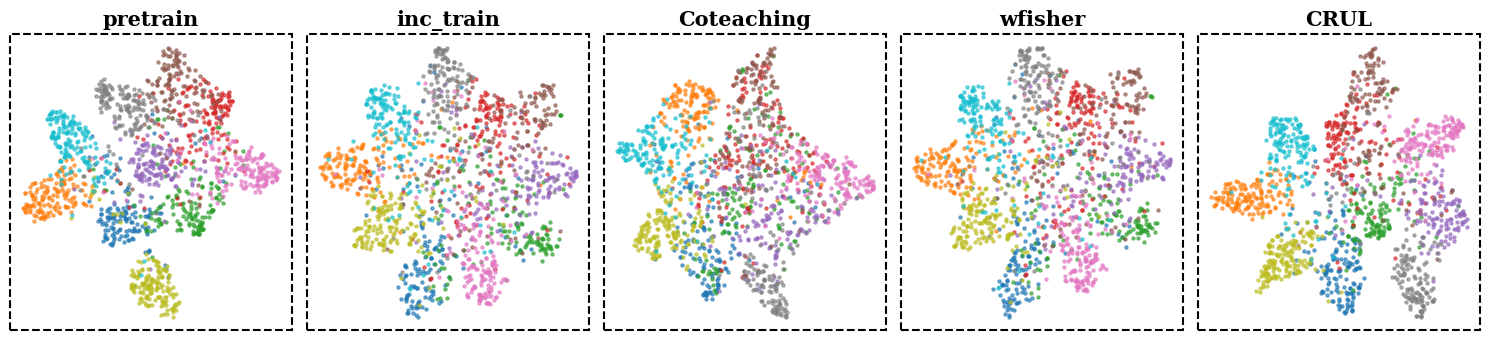

In [140]:
import warnings

warnings.filterwarnings("ignore")

import os
import sys

# 添加项目根目录到 sys.path
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(project_root)


import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from core_model.custom_model import ClassifierWrapper, load_custom_model
from configs import settings
import logging
from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as TSNE


os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up logging for better visibility
logging.basicConfig(
    level=logging.INFO,
    format="\033[1;36m%(asctime)s - %(levelname)s - %(message)s\033[0m",
)
logger = logging.getLogger(__name__)


class BaseTensorDataset(Dataset):
    def __init__(self, data, labels, transforms=None, device=None):
        self.data = torch.as_tensor(data, device=device)
        self.labels = torch.as_tensor(labels, device=device)
        self.transforms = transforms
        logger.info(
            f"Dataset initialized with data shape: {data.shape} and labels shape: {labels.shape}"
        )

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        if self.transforms is not None:
            self.transforms(data)

        return data, self.labels[index]


def get_model_path(dataset_name, model_name, method):

    # TODO-241105 [sunzekun] 新的参数读取路径规则，先做初步测试用，对各个数据集需要分别根据文档的设定手写case（主要变的是noise_ratio)
    base_ckpt_path = (
        f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_0.25_nt_symmetric_cvpr"
    )
    if method == "pretrain":
        return f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/pretrain/{model_name}_pretrain.pth"
    elif method == "inc_train":
        return os.path.join(base_ckpt_path, f"{model_name}_inc_train.pth")
    else:
        return os.path.join(base_ckpt_path, method, f"{model_name}_restore.pth")


def load_model_and_data(dataset_name, model_name, method):
    """
    加载模型及其对应的测试数据集，并返回模型和数据加载器
    """
    # 更改数据集为 pet-37
    # dataset_name = "pet-37"  # 使用 Oxford-IIIT Pet 数据集

    num_classes = settings.num_classes_dict[dataset_name]

    # 加载测试数据集
    # Load test dataset
    batch_size = 64
    test_data_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_data.npy"
    test_label_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_label.npy"

    try:
        logger.info(f"Loading test data from: {test_data_path}")
        test_data = np.load(test_data_path)
        test_labels = np.load(test_label_path)
        logger.info(
            f"Test data loaded with shape: {test_data.shape}, Test labels loaded with shape: {test_labels.shape}"
        )
        test_dataset = BaseTensorDataset(test_data, test_labels, device=device)
        test_dataloader = DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, num_workers=0
        )
    except FileNotFoundError as e:
        logger.error(f"Error loading test dataset: {e}")
        return

    # 加载模型
    num_classes = settings.num_classes_dict[dataset_name]
    logger.info(
        f"Currently testing dataset: {dataset_name} with {num_classes} classes."
    )

    model_path = get_model_path(dataset_name, model_name, method)
    logger.info(f"Evaluating model from path: {model_path}")

    # Load model architecture and weights
    model = load_custom_model(model_name, num_classes, load_pretrained=False)
    model = ClassifierWrapper(model, num_classes)
    try:
        checkpoint = torch.load(model_path, map_location=device)
        logger.info(f"Loaded model checkpoint from {model_path}")
    except FileNotFoundError:
        logger.error(f"Cannot find the weight file at {model_path}. Skipping.")
        return
    model.load_state_dict(checkpoint, strict=False)

    model.eval()
    model.to(device)

    return model, test_dataloader, test_labels


# 获取嵌入数据
def get_embeddings(model, dataloader, layer_name="feature_model"):
    """
    提取模型的嵌入层输出
    """
    embeddings = []
    labels = []

    # 注册hook来捕获指定层的输出
    def hook_fn(module, input, output):
        embeddings.append(output.detach().cpu().numpy())

    handle = model._modules.get(layer_name).register_forward_hook(hook_fn)

    # 进行前向传播以获取嵌入
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            model(inputs)
            labels.extend(targets.cpu().numpy())

    handle.remove()

    # 拼接所有批次的嵌入和标签
    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.array(labels)
    return embeddings, labels


def get_cache_path_tsne(dataset_name, case, unique_name):
    root_dir = os.path.abspath(os.path.join(os.getcwd(), os.path.pardir))

    path = os.path.join(
        root_dir,
        "result_analysis/results_cvpr/tsne",
        dataset_name,
        case,
        unique_name,
    )
    os.makedirs(path, exist_ok=True)

    return os.path.join(path, f"tsne.npz")


# 绘制 t-SNE
def get_tsne(model, dataloader, class_range=None):
    """
    绘制多个step的t-SNE结果，展示不同方法在不同步骤的嵌入变化
    """
    embeddings, labels = get_embeddings(model, dataloader)

    if class_range is not None:
        mask = np.isin(labels, class_range)
        embeddings = embeddings[mask]
        labels = labels[mask]

    # PCA 降维
    pca = PCA(n_components=50)
    pca_result = pca.fit_transform(embeddings)

    # t-SNE降维
    tsne = TSNE(n_components=2, n_jobs=8, random_state=42)
    tsne_result = tsne.fit_transform(pca_result)

    return tsne_result, labels


def plot_tsne(
    methods,
    dataset_name,
    model_name,
    noise_type,
    class_range=None,
    title=None,
    use_cache=False,
):
    # 本实验中简化了case的使用，直接改为由noise-type来决定特定的名字（有需要再换回去）
    case = "sym" if noise_type == "symmetric" else "asym"

    plt.style.use("default")
    fig, axs = plt.subplots(1, len(methods), figsize=(3 * len(methods), 3.5))
    fig.subplots_adjust(hspace=0.6, wspace=0.6)  # 增加子图之间的边距，保证美观

    tsne_results_all = {}

    for method in methods:
        model = None
        dataloader = None
        cache_path = get_cache_path_tsne(
            dataset_name=dataset_name, case=case, unique_name=method
        )
        if use_cache:
            try:
                data = np.load(cache_path)
                tsne = data["tsne"]
                labels = data["labels"]
                print(f"读取缓存的tsne记录：{cache_path}")
            except FileNotFoundError:
                print("未读取到对应的tsne。首次评估某个模型时，请先使用use_cache=False")
                if model is None or dataloader is None:
                    model, dataloader, _ = load_model_and_data(
                        dataset_name, model_name, method
                    )
                tsne, labels = get_tsne(model, dataloader, class_range)
                np.savez(cache_path, tsne=tsne, labels=labels)
                print(f"缓存tsne结果至：{cache_path}")
            tsne_results_all[method] = (tsne, labels)
        else:
            if model is None or dataloader is None:
                model, dataloader, _ = load_model_and_data(
                    dataset_name, model_name, method
                )
            tsne, labels = get_tsne(model, dataloader, class_range)
            np.savez(cache_path, tsne=tsne, labels=labels)
            print(f"缓存tsne结果至：{cache_path}")
            tsne_results_all[method] = (tsne, labels)

    # Plotting t-SNE results for the specified class range
    for method_idx, method in enumerate(methods):
        ax = axs[method_idx]
        tsne_result, labels = tsne_results_all.get(method, (None, None))
        # print(tsne_result.shape)

        # 尝试仅展示前k个点

        # k = 1000
        k = 1500
        tsne_result = tsne_result[:k]
        labels = labels[:k]

        if tsne_result is not None:
            unique_labels = np.unique(labels)
            for class_label in unique_labels:
                class_mask = labels == class_label
                ax.scatter(
                    tsne_result[class_mask, 0],
                    tsne_result[class_mask, 1],
                    s=5,
                    alpha=0.6,
                    label=f"Class {class_label}",
                )
            ax.set_title(f"{method}", fontsize=15, fontfamily="serif", weight="bold")
            ax.tick_params(axis="both", which="major", labelsize=15)
            ax.axis("off")
        else:
            ax.set_title(
                f"No data for {method}", fontsize=15, fontfamily="serif", weight="bold"
            )
            ax.axis("off")

    # Adding dashed black border around each subplot for visual distinction
    for ax in axs.flat:
        rect = plt.Rectangle(
            (0, 0),
            1,
            1,
            transform=ax.transAxes,
            color="black",
            linewidth=1.5,
            linestyle="--",
            fill=False,
            clip_on=False,
            zorder=10,
        )
        ax.add_patch(rect)

    if title:
        title_fs = 15  # 标题的字号大小
        plt.suptitle(title, fontsize=title_fs, fontfamily="serif", weight="bold")
    plt.tight_layout()
    # plt.savefig(f'tsne_visualization_{method}_step_{step}_{noise_type}_{class_type}.pdf', format='pdf', dpi=300)
    plt.show()


# # 通用配置字典
# def configure_plot(dataset_name, model_name, methods, steps, noise_type, noise_ratio, class_type):
#     if class_type == "forget":
#         class_range = list(range(18))
#         title = "t-SNE Visualization for Forget Classes"
#     elif class_type == "noise":
#         class_range = list(range(18, 28))
#         title = "t-SNE Visualization for Noise Classes"
#     else:  # full
#         class_range = None
#         title = "t-SNE Visualization for All Classes"
#     return class_range, title

# 执行 t-SNE 可视化

methods = [  # baseline方法，包括一些预训练，增量训练(raw, 仅在d1上训练) 和基础的baseline
    # 'pretrain', 'inc_train', 'finetune',
    "pretrain",
    "inc_train",
    # LNL方法
    # 'Coteaching', 'Coteachingplus', 'JoCoR', 'Decoupling', 'NegativeLearning', 'PENCIL',
    "Coteaching",
    # MU 方法
    # 'raw', 'GA', 'GA_l1', 'FT', 'FT_l1', 'fisher_new', 'wfisher', 'FT_prune', 'FT_prune_bi', 'retrain', 'retrain_ls', 'retrain_sam',
    "wfisher",
    # 我们的方法
    "CRUL",
]

dataset_name = "cifar-10"  # 更改为 pet-37 数据集
noise_type = "symmetric"
model_name = "cifar-resnet18"  # 确保模型适配 pet-37 数据集

# class_range = list(range(10, 20))  # 只展示前10个类
class_range = None  # 都展示
title = None

# plot_tsne(
#     methods, dataset_name, model_name, noise_type, class_range=class_range, title=title, use_cache=False
# )

plot_tsne(
    methods,
    dataset_name,
    model_name,
    noise_type,
    class_range=class_range,
    title=title,
    use_cache=True,
)

### Cifar-10-asym

读取缓存的tsne记录：/nvme/sunzekun/Projects/tta-mr/result_analysis/results_cvpr/tsne/cifar-10/asym/pretrain/tsne.npz
读取缓存的tsne记录：/nvme/sunzekun/Projects/tta-mr/result_analysis/results_cvpr/tsne/cifar-10/asym/inc_train/tsne.npz


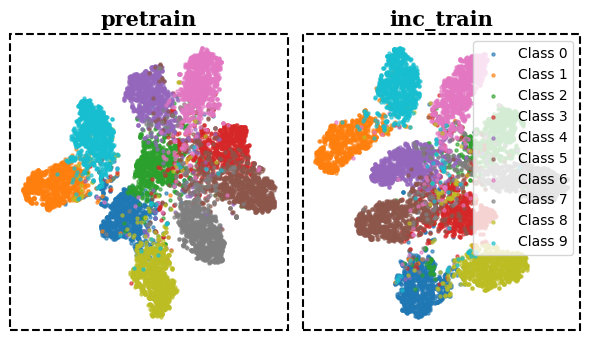

In [139]:
import warnings

warnings.filterwarnings("ignore")

import os
import sys

# 添加项目根目录到 sys.path
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(project_root)


import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from core_model.custom_model import ClassifierWrapper, load_custom_model
from configs import settings
import logging
from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as TSNE


os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up logging for better visibility
logging.basicConfig(
    level=logging.INFO,
    format="\033[1;36m%(asctime)s - %(levelname)s - %(message)s\033[0m",
)
logger = logging.getLogger(__name__)


class BaseTensorDataset(Dataset):
    def __init__(self, data, labels, transforms=None, device=None):
        self.data = torch.as_tensor(data, device=device)
        self.labels = torch.as_tensor(labels, device=device)
        self.transforms = transforms
        logger.info(
            f"Dataset initialized with data shape: {data.shape} and labels shape: {labels.shape}"
        )

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        if self.transforms is not None:
            self.transforms(data)

        return data, self.labels[index]


def get_model_path(dataset_name, model_name, method):

    # TODO-241105 [sunzekun] 新的参数读取路径规则，先做初步测试用，对各个数据集需要分别根据文档的设定手写case（主要变的是noise_ratio)
    base_ckpt_path = (
        f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_0.5_nt_asymmetric_cvpr"
    )
    if method == "pretrain":
        return f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/pretrain/{model_name}_pretrain.pth"
    elif method == "inc_train":
        return os.path.join(base_ckpt_path, f"{model_name}_inc_train.pth")
    else:
        return os.path.join(base_ckpt_path, method, f"{model_name}_restore.pth")


def load_model_and_data(dataset_name, model_name, method):
    """
    加载模型及其对应的测试数据集，并返回模型和数据加载器
    """
    # 更改数据集为 pet-37
    # dataset_name = "pet-37"  # 使用 Oxford-IIIT Pet 数据集

    num_classes = settings.num_classes_dict[dataset_name]

    # 加载测试数据集
    # Load test dataset
    batch_size = 64
    test_data_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_data.npy"
    test_label_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_label.npy"

    try:
        logger.info(f"Loading test data from: {test_data_path}")
        test_data = np.load(test_data_path)
        test_labels = np.load(test_label_path)
        logger.info(
            f"Test data loaded with shape: {test_data.shape}, Test labels loaded with shape: {test_labels.shape}"
        )
        test_dataset = BaseTensorDataset(test_data, test_labels, device=device)
        test_dataloader = DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, num_workers=0
        )
    except FileNotFoundError as e:
        logger.error(f"Error loading test dataset: {e}")
        return

    # 加载模型
    num_classes = settings.num_classes_dict[dataset_name]
    logger.info(
        f"Currently testing dataset: {dataset_name} with {num_classes} classes."
    )

    model_path = get_model_path(dataset_name, model_name, method)
    logger.info(f"Evaluating model from path: {model_path}")

    # Load model architecture and weights
    model = load_custom_model(model_name, num_classes, load_pretrained=False)
    model = ClassifierWrapper(model, num_classes)
    try:
        checkpoint = torch.load(model_path, map_location=device)
        logger.info(f"Loaded model checkpoint from {model_path}")
    except FileNotFoundError:
        logger.error(f"Cannot find the weight file at {model_path}. Skipping.")
        return
    model.load_state_dict(checkpoint, strict=False)

    model.eval()
    model.to(device)

    return model, test_dataloader, test_labels


# 获取嵌入数据
def get_embeddings(model, dataloader, layer_name="feature_model"):
    """
    提取模型的嵌入层输出
    """
    embeddings = []
    labels = []

    # 注册hook来捕获指定层的输出
    def hook_fn(module, input, output):
        embeddings.append(output.detach().cpu().numpy())

    handle = model._modules.get(layer_name).register_forward_hook(hook_fn)

    # 进行前向传播以获取嵌入
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            model(inputs)
            labels.extend(targets.cpu().numpy())

    handle.remove()

    # 拼接所有批次的嵌入和标签
    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.array(labels)
    return embeddings, labels


def get_cache_path_tsne(dataset_name, case, unique_name):
    root_dir = os.path.abspath(os.path.join(os.getcwd(), os.path.pardir))

    path = os.path.join(
        root_dir,
        "result_analysis/results_cvpr/tsne",
        dataset_name,
        case,
        unique_name,
    )
    os.makedirs(path, exist_ok=True)

    return os.path.join(path, f"tsne.npz")


# 绘制 t-SNE
def get_tsne(model, dataloader, class_range=None):
    """
    绘制多个step的t-SNE结果，展示不同方法在不同步骤的嵌入变化
    """
    embeddings, labels = get_embeddings(model, dataloader)

    if class_range is not None:
        mask = np.isin(labels, class_range)
        embeddings = embeddings[mask]
        labels = labels[mask]

    # PCA 降维
    pca = PCA(n_components=50)
    pca_result = pca.fit_transform(embeddings)

    # t-SNE降维
    tsne = TSNE(n_components=2, n_jobs=8, random_state=42)
    tsne_result = tsne.fit_transform(pca_result)

    return tsne_result, labels


def plot_tsne(
    methods,
    dataset_name,
    model_name,
    noise_type,
    class_range=None,
    title=None,
    use_cache=False,
):
    # 本实验中简化了case的使用，直接改为由noise-type来决定特定的名字（有需要再换回去）
    case = "sym" if noise_type == "symmetric" else "asym"

    plt.style.use("default")
    fig, axs = plt.subplots(1, len(methods), figsize=(3 * len(methods), 3.5))
    fig.subplots_adjust(hspace=0.6, wspace=0.6)  # 增加子图之间的边距，保证美观

    tsne_results_all = {}

    for method in methods:
        model = None
        dataloader = None
        cache_path = get_cache_path_tsne(
            dataset_name=dataset_name, case=case, unique_name=method
        )
        if use_cache:
            try:
                data = np.load(cache_path)
                tsne = data["tsne"]
                labels = data["labels"]
                print(f"读取缓存的tsne记录：{cache_path}")
            except FileNotFoundError:
                print("未读取到对应的tsne。首次评估某个模型时，请先使用use_cache=False")
                if model is None or dataloader is None:
                    model, dataloader, _ = load_model_and_data(
                        dataset_name, model_name, method
                    )
                tsne, labels = get_tsne(model, dataloader, class_range)
                np.savez(cache_path, tsne=tsne, labels=labels)
                print(f"缓存tsne结果至：{cache_path}")
            tsne_results_all[method] = (tsne, labels)
        else:
            if model is None or dataloader is None:
                model, dataloader, _ = load_model_and_data(
                    dataset_name, model_name, method
                )
            tsne, labels = get_tsne(model, dataloader, class_range)
            np.savez(cache_path, tsne=tsne, labels=labels)
            print(f"缓存tsne结果至：{cache_path}")
            tsne_results_all[method] = (tsne, labels)

    # Plotting t-SNE results for the specified class range
    for method_idx, method in enumerate(methods):
        ax = axs[method_idx]
        tsne_result, labels = tsne_results_all.get(method, (None, None))
        # print(tsne_result.shape)

        # 尝试仅展示前k个点

        # k = 1000
        k = 10000
        tsne_result = tsne_result[:k]
        labels = labels[:k]

        if tsne_result is not None:
            unique_labels = np.unique(labels)
            for class_label in unique_labels:
                class_mask = labels == class_label
                ax.scatter(
                    tsne_result[class_mask, 0],
                    tsne_result[class_mask, 1],
                    s=5,
                    alpha=0.6,
                    label=f"Class {class_label}",
                )
            ax.set_title(f"{method}", fontsize=15, fontfamily="serif", weight="bold")
            ax.tick_params(axis="both", which="major", labelsize=15)
            ax.axis("off")
        else:
            ax.set_title(
                f"No data for {method}", fontsize=15, fontfamily="serif", weight="bold"
            )
            ax.axis("off")

    # Adding dashed black border around each subplot for visual distinction
    for ax in axs.flat:
        rect = plt.Rectangle(
            (0, 0),
            1,
            1,
            transform=ax.transAxes,
            color="black",
            linewidth=1.5,
            linestyle="--",
            fill=False,
            clip_on=False,
            zorder=10,
        )
        ax.add_patch(rect)

    if title:
        title_fs = 15  # 标题的字号大小
        plt.suptitle(title, fontsize=title_fs, fontfamily="serif", weight="bold")
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f'tsne_visualization_{method}_step_{step}_{noise_type}_{class_type}.pdf', format='pdf', dpi=300)
    plt.show()


# # 通用配置字典
# def configure_plot(dataset_name, model_name, methods, steps, noise_type, noise_ratio, class_type):
#     if class_type == "forget":
#         class_range = list(range(18))
#         title = "t-SNE Visualization for Forget Classes"
#     elif class_type == "noise":
#         class_range = list(range(18, 28))
#         title = "t-SNE Visualization for Noise Classes"
#     else:  # full
#         class_range = None
#         title = "t-SNE Visualization for All Classes"
#     return class_range, title

# 执行 t-SNE 可视化

methods = [  # baseline方法，包括一些预训练，增量训练(raw, 仅在d1上训练) 和基础的baseline
    # 'pretrain', 'inc_train', 'finetune',
    "pretrain",
    "inc_train",
    # LNL方法
    # 'Coteaching', 'Coteachingplus', 'JoCoR', 'Decoupling', 'NegativeLearning', 'PENCIL',
    # "Coteaching",
    # MU 方法
    # 'raw', 'GA', 'GA_l1', 'FT', 'FT_l1', 'fisher_new', 'wfisher', 'FT_prune', 'FT_prune_bi', 'retrain', 'retrain_ls', 'retrain_sam',
    # "wfisher",
    # "GA",
    # 我们的方法
    # "CRUL",
]

dataset_name = "cifar-10"  # 更改为 pet-37 数据集
noise_type = "asymmetric"
model_name = "cifar-resnet18"  # 确保模型适配 pet-37 数据集

# class_range = list(range(10, 20))  # 只展示前10个类
class_range = None  # 都展示
title = None

# plot_tsne(
#     methods, dataset_name, model_name, noise_type, class_range=class_range, title=title, use_cache=False
# )

plot_tsne(
    methods,
    dataset_name,
    model_name,
    noise_type,
    class_range=class_range,
    title=title,
    use_cache=True,
)

# 2、敏感度实验


## sym - Flower-102


In [154]:
import warnings

warnings.filterwarnings("ignore")

import os
import sys

# 添加项目根目录到 sys.path
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(project_root)

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from core_model.custom_model import ClassifierWrapper, load_custom_model
from configs import settings
import logging

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up logging for better visibility
logging.basicConfig(
    level=logging.INFO,
    format="\033[1;36m%(asctime)s - %(levelname)s - %(message)s\033[0m",
)
logger = logging.getLogger(__name__)


def get_test_acc(test_loader, model, device):
    """
    Evaluate the test accuracy of a given model using a test dataset.
    """
    criterion = nn.CrossEntropyLoss()
    model.eval().to(device)
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        with tqdm(total=len(test_loader), desc=f"Testing") as pbar:
            for test_inputs, test_targets in test_loader:
                test_inputs, test_targets = test_inputs.to(device), test_targets.to(
                    device
                )
                test_outputs = model(test_inputs)
                loss = criterion(test_outputs, test_targets)
                _, predicted_test = torch.max(test_outputs, 1)
                total_test += test_targets.size(0)
                correct_test += (predicted_test == test_targets).sum().item()

                # Update progress bar
                pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
                pbar.update(1)

    test_accuracy = 100 * correct_test / total_test
    # logger.info(f"Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy


class BaseTensorDataset(Dataset):
    def __init__(self, data, labels, transforms=None, device=None):
        self.data = torch.as_tensor(data, device=device)
        self.labels = torch.as_tensor(labels, device=device)
        self.transforms = transforms
        logger.info(
            f"Dataset initialized with data shape: {data.shape} and labels shape: {labels.shape}"
        )

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        if self.transforms is not None:
            self.transforms(data)

        return data, self.labels[index]


def get_model_path(
    dataset_name, model_name, method, noise_ratio=0.5, noise_type="symmetric"
):

    # TODO-241105 [sunzekun] 新的参数读取路径规则，先做初步测试用，对各个数据集需要分别根据文档的设定手写case（主要变的是noise_ratio)
    base_ckpt_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_{noise_ratio}_nt_{noise_type}_cvpr"
    if method == "pretrain":
        return f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/pretrain/{model_name}_pretrain.pth"
    elif method == "inc_train":
        return os.path.join(base_ckpt_path, f"{model_name}_inc_train.pth")
    else:
        return os.path.join(base_ckpt_path, method, f"{model_name}_restore.pth")


def eva_test_acc_sensitivity(
    dataset_name,
    model_name,
    noise_type="symmetric",
    noise_ratios=[0.5],
    methods=None,
    results_dir=None,
    device="cuda",
):
    """
    Evaluate test accuracy for a specified dataset and set of methods.
    """
    assert methods is not None, "Please specify the methods to evaluate."
    assert results_dir is not None, "Please specify the directory to save the results."
    os.makedirs(results_dir, exist_ok=True)

    num_classes = settings.num_classes_dict[dataset_name]
    logger.info(
        f"Currently testing dataset: {dataset_name} with {num_classes} classes."
    )

    # Load test dataset
    batch_size = 64
    test_data_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_data.npy"
    test_label_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_label.npy"

    try:
        logger.info(f"Loading test data from: {test_data_path}")
        test_data = np.load(test_data_path)
        test_labels = np.load(test_label_path)
        logger.info(
            f"Test data loaded with shape: {test_data.shape}, Test labels loaded with shape: {test_labels.shape}"
        )
        test_dataset = BaseTensorDataset(test_data, test_labels, device=device)
        test_dataloader = DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, num_workers=0
        )
    except FileNotFoundError as e:
        logger.error(f"Error loading test dataset: {e}")
        return

    df = pd.DataFrame(index=methods, columns=noise_ratios)

    for method in methods:
        for noise_ratio in noise_ratios:
            model_path = get_model_path(
                dataset_name, model_name, method, noise_ratio, noise_type
            )
            logger.info(f"Evaluating model from path: {model_path}")

            # Load model architecture and weights
            model = load_custom_model(model_name, num_classes, load_pretrained=False)
            model = ClassifierWrapper(model, num_classes)
            try:
                checkpoint = torch.load(model_path, map_location=device)
                logger.info(f"Loaded model checkpoint from {model_path}")
            except FileNotFoundError:
                logger.error(f"Cannot find the weight file at {model_path}. Skipping.")
                continue
            model.load_state_dict(checkpoint, strict=False)

            # Evaluate the model
            logger.info(f"Starting evaluation for method: {method}")
            test_acc = get_test_acc(test_dataloader, model, device)

            logger.info(f"Test Accuracy for {method}: {test_acc:.2f}%")
            # TODO-241105 [sunzkeun] 更换为：行为acc，列为方法。方便和最后的总表对齐
            df.loc[method, noise_ratio] = test_acc

    # Save results to CSV
    mission_type = "sym" if noise_type == "symmetric" else "asym"
    results_file_name = f"{dataset_name}_{mission_type}.csv"
    results_file_dir = os.path.join(results_dir, results_file_name)
    df.to_csv(results_file_dir)
    logger.info(f"Results saved to {results_file_dir}")


# Example usage
if __name__ == "__main__":
    dataset_name = "flower-102"
    model_name = "wideresnet50"
    noise_type = "symmetric"

    methods = [  # baseline方法，包括一些预训练，增量训练(raw, 仅在d1上训练) 和基础的baseline
        "pretrain",
        "inc_train",
        "finetune",
        # LNL方法
        "Coteaching",
        "Coteachingplus",
        # MU 方法
        "FT",
        "GA",
        # 我们的方法
        "CRUL",
    ]

    noise_ratios = [0.25, 0.5, 0.75]
    results_dir = "./results_cvpr/sensitivity"

    eva_test_acc_sensitivity(
        dataset_name,
        model_name,
        noise_type,
        noise_ratios=noise_ratios,
        methods=methods,
        results_dir=results_dir,
    )

2024-11-08 17:20:32,035 - INFO - Currently testing dataset: flower-102 with 102 classes.
2024-11-08 17:20:32,035 - INFO - Loading test data from: /nvme/szh/code/tta-mr/data/flower-102/gen/test_data.npy


2024-11-08 17:20:32,187 - INFO - Test data loaded with shape: (1020, 3, 224, 224), Test labels loaded with shape: (1020,)
2024-11-08 17:20:32,224 - INFO - Dataset initialized with data shape: (1020, 3, 224, 224) and labels shape: (1020,)
2024-11-08 17:20:32,226 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/flower-102/pretrain/wideresnet50_pretrain.pth
2024-11-08 17:20:33,044 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/flower-102/pretrain/wideresnet50_pretrain.pth
2024-11-08 17:20:33,076 - INFO - Starting evaluation for method: pretrain
Testing: 100%|██████████| 16/16 [00:00<00:00, 25.67it/s, Loss=0.2299]
2024-11-08 17:20:33,738 - INFO - Test Accuracy for pretrain: 92.06%
2024-11-08 17:20:33,739 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/flower-102/pretrain/wideresnet50_pretrain.pth
2024-11-08 17:20:34,572 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/flower-102/pretrain/wideresnet50_pretrain.pth
2024-11-08 1

## asym - Pet-37


In [155]:
import warnings

warnings.filterwarnings("ignore")

import os
import sys

# 添加项目根目录到 sys.path
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(project_root)

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from core_model.custom_model import ClassifierWrapper, load_custom_model
from configs import settings
import logging

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up logging for better visibility
logging.basicConfig(
    level=logging.INFO,
    format="\033[1;36m%(asctime)s - %(levelname)s - %(message)s\033[0m",
)
logger = logging.getLogger(__name__)


def get_test_acc(test_loader, model, device):
    """
    Evaluate the test accuracy of a given model using a test dataset.
    """
    criterion = nn.CrossEntropyLoss()
    model.eval().to(device)
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        with tqdm(total=len(test_loader), desc=f"Testing") as pbar:
            for test_inputs, test_targets in test_loader:
                test_inputs, test_targets = test_inputs.to(device), test_targets.to(
                    device
                )
                test_outputs = model(test_inputs)
                loss = criterion(test_outputs, test_targets)
                _, predicted_test = torch.max(test_outputs, 1)
                total_test += test_targets.size(0)
                correct_test += (predicted_test == test_targets).sum().item()

                # Update progress bar
                pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
                pbar.update(1)

    test_accuracy = 100 * correct_test / total_test
    # logger.info(f"Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy


class BaseTensorDataset(Dataset):
    def __init__(self, data, labels, transforms=None, device=None):
        self.data = torch.as_tensor(data, device=device)
        self.labels = torch.as_tensor(labels, device=device)
        self.transforms = transforms
        logger.info(
            f"Dataset initialized with data shape: {data.shape} and labels shape: {labels.shape}"
        )

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        if self.transforms is not None:
            self.transforms(data)

        return data, self.labels[index]


def get_model_path(
    dataset_name, model_name, method, noise_ratio=0.5, noise_type="symmetric"
):

    # TODO-241105 [sunzekun] 新的参数读取路径规则，先做初步测试用，对各个数据集需要分别根据文档的设定手写case（主要变的是noise_ratio)
    base_ckpt_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_{noise_ratio}_nt_{noise_type}_cvpr"
    if method == "pretrain":
        return f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/pretrain/{model_name}_pretrain.pth"
    elif method == "inc_train":
        return os.path.join(base_ckpt_path, f"{model_name}_inc_train.pth")
    else:
        return os.path.join(base_ckpt_path, method, f"{model_name}_restore.pth")


def eva_test_acc_sensitivity(
    dataset_name,
    model_name,
    noise_type="symmetric",
    noise_ratios=[0.5],
    methods=None,
    results_dir=None,
    device="cuda",
):
    """
    Evaluate test accuracy for a specified dataset and set of methods.
    """
    assert methods is not None, "Please specify the methods to evaluate."
    assert results_dir is not None, "Please specify the directory to save the results."
    os.makedirs(results_dir, exist_ok=True)

    num_classes = settings.num_classes_dict[dataset_name]
    logger.info(
        f"Currently testing dataset: {dataset_name} with {num_classes} classes."
    )

    # Load test dataset
    batch_size = 64
    test_data_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_data.npy"
    test_label_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_label.npy"

    try:
        logger.info(f"Loading test data from: {test_data_path}")
        test_data = np.load(test_data_path)
        test_labels = np.load(test_label_path)
        logger.info(
            f"Test data loaded with shape: {test_data.shape}, Test labels loaded with shape: {test_labels.shape}"
        )
        test_dataset = BaseTensorDataset(test_data, test_labels, device=device)
        test_dataloader = DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, num_workers=0
        )
    except FileNotFoundError as e:
        logger.error(f"Error loading test dataset: {e}")
        return

    df = pd.DataFrame(index=methods, columns=noise_ratios)

    for method in methods:
        for noise_ratio in noise_ratios:
            model_path = get_model_path(
                dataset_name, model_name, method, noise_ratio, noise_type
            )
            logger.info(f"Evaluating model from path: {model_path}")

            # Load model architecture and weights
            model = load_custom_model(model_name, num_classes, load_pretrained=False)
            model = ClassifierWrapper(model, num_classes)
            try:
                checkpoint = torch.load(model_path, map_location=device)
                logger.info(f"Loaded model checkpoint from {model_path}")
            except FileNotFoundError:
                logger.error(f"Cannot find the weight file at {model_path}. Skipping.")
                continue
            model.load_state_dict(checkpoint, strict=False)

            # Evaluate the model
            logger.info(f"Starting evaluation for method: {method}")
            test_acc = get_test_acc(test_dataloader, model, device)

            logger.info(f"Test Accuracy for {method}: {test_acc:.2f}%")
            # TODO-241105 [sunzkeun] 更换为：行为acc，列为方法。方便和最后的总表对齐
            df.loc[method, noise_ratio] = test_acc

    # Save results to CSV
    mission_type = "sym" if noise_type == "symmetric" else "asym"
    results_file_name = f"{dataset_name}_{mission_type}.csv"
    results_file_dir = os.path.join(results_dir, results_file_name)
    df.to_csv(results_file_dir)
    logger.info(f"Results saved to {results_file_dir}")


# Example usage
if __name__ == "__main__":
    dataset_name = "pet-37"
    model_name = "wideresnet50"
    noise_type = "asymmetric"

    methods = [  # baseline方法，包括一些预训练，增量训练(raw, 仅在d1上训练) 和基础的baseline
        "pretrain",
        "inc_train",
        "finetune",
        # LNL方法
        "Coteaching",
        "Coteachingplus",
        # MU 方法
        "FT",
        "GA",
        # 我们的方法
        "CRUL",
    ]

    noise_ratios = [0.25, 0.5, 0.75]
    results_dir = "./results_cvpr/sensitivity"

    eva_test_acc_sensitivity(
        dataset_name,
        model_name,
        noise_type,
        noise_ratios=noise_ratios,
        methods=methods,
        results_dir=results_dir,
    )

2024-11-08 17:21:05,570 - INFO - Currently testing dataset: pet-37 with 37 classes.
2024-11-08 17:21:05,571 - INFO - Loading test data from: /nvme/szh/code/tta-mr/data/pet-37/gen/test_data.npy


2024-11-08 17:21:06,165 - INFO - Test data loaded with shape: (3669, 3, 224, 224), Test labels loaded with shape: (3669,)
2024-11-08 17:21:06,302 - INFO - Dataset initialized with data shape: (3669, 3, 224, 224) and labels shape: (3669,)
2024-11-08 17:21:06,305 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/pet-37/pretrain/wideresnet50_pretrain.pth
2024-11-08 17:21:07,105 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/pet-37/pretrain/wideresnet50_pretrain.pth
2024-11-08 17:21:07,136 - INFO - Starting evaluation for method: pretrain
Testing: 100%|██████████| 58/58 [00:01<00:00, 31.55it/s, Loss=0.2881]
2024-11-08 17:21:09,004 - INFO - Test Accuracy for pretrain: 90.90%
2024-11-08 17:21:09,005 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/pet-37/pretrain/wideresnet50_pretrain.pth
2024-11-08 17:21:09,795 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/pet-37/pretrain/wideresnet50_pretrain.pth
2024-11-08 17:21:09,827 - IN

## 敏感度实验可视化（建设中）

Index(['pretrain', 'inc_train', 'finetune', 'Coteaching', 'Coteachingplus',
       'FT', 'GA', 'CRUL'],
      dtype='object')

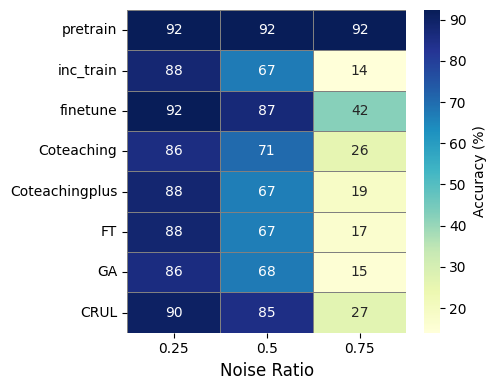

In [161]:
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
import numpy as np
import seaborn as sns

plt.style.use("default")

file_path = './results_cvpr/sensitivity/flower-102_sym.csv'
heatmap_data = pd.read_csv(file_path, index_col=0)
heatmap_data.index

# # Creating a heatmap for Pet-37 dataset across different noise ratios
# heatmap_data = pd.DataFrame({
#     'Noise Ratio 0.25': [91.61, 85.64, 89.94, 87.74, 85.72, 85.17, 89.59, 90.43],
#     'Noise Ratio 0.5': [91.61, 60.53, 86.15, 80.92, 65.85, 53.69, 66.86, 89.67],
#     'Noise Ratio 0.75': [91.61, 20.44, 71.27, 47.78, 29.11, 13.68, 23.33, 62.44]
# },
#     index=['pretrain', 'inc_train', 'finetune', 'Coteaching', 'Coteachingplus', 'FT', 'GA', 'CRUL']
# )

# plt.figure(figsize=(10, 6))
plt.figure(figsize=(5, 4))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Accuracy (%)'})
# plt.title('Heatmap of Accuracy Across Noise Ratios for Pet-37 Dataset', fontsize=16)
plt.xlabel('Noise Ratio', fontsize=12)
# plt.ylabel('Methods', fontsize=12)
plt.tight_layout()
plt.show()


### pet-37

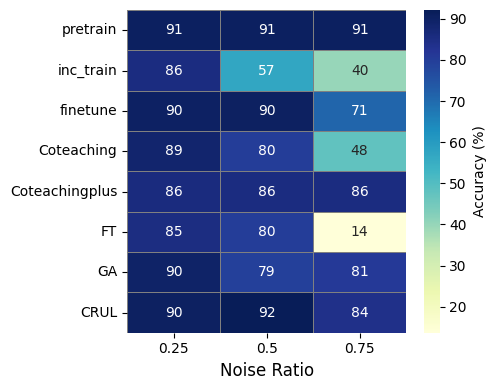

In [162]:
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
import numpy as np
import seaborn as sns

plt.style.use("default")

file_path = './results_cvpr/sensitivity/pet-37_asym.csv'
heatmap_data = pd.read_csv(file_path, index_col=0)
heatmap_data.index

# # Creating a heatmap for Pet-37 dataset across different noise ratios
# heatmap_data = pd.DataFrame({
#     'Noise Ratio 0.25': [91.61, 85.64, 89.94, 87.74, 85.72, 85.17, 89.59, 90.43],
#     'Noise Ratio 0.5': [91.61, 60.53, 86.15, 80.92, 65.85, 53.69, 66.86, 89.67],
#     'Noise Ratio 0.75': [91.61, 20.44, 71.27, 47.78, 29.11, 13.68, 23.33, 62.44]
# },
#     index=['pretrain', 'inc_train', 'finetune', 'Coteaching', 'Coteachingplus', 'FT', 'GA', 'CRUL']
# )

# plt.figure(figsize=(10, 6))
plt.figure(figsize=(5, 4))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Accuracy (%)'})
# plt.title('Heatmap of Accuracy Across Noise Ratios for Pet-37 Dataset', fontsize=16)
plt.xlabel('Noise Ratio', fontsize=12)
# plt.ylabel('Methods', fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
def visualize(results_file_path, type="cls"):
    data = pd.read_csv(results_file_path, index_col=0)
    plt.figure(figsize=(4, 4))
    # fig, ax = plt.subplots(figsize=(4, 5))
    ax = plt.gca()
    ax.set_facecolor("#EAEAF2")
    # color_list = ['#696969', '#2799B2', '#4DA764']

    lw = 2
    ms = 10  # marker_size
    tfs = 12  # tick font size

    plt.plot(
        data.columns,
        data.loc["raw"],
        label="raw",
        color="#696969",
        linestyle="--",
        linewidth=lw,
        marker="o",
        markersize=ms,
    )  # Grey dashed line
    plt.plot(
        data.columns,
        data.loc["Coteaching"],
        label="coteaching",
        color="#2799B2",
        linewidth=lw,
        marker="^",
        markersize=ms,
    )  # Blue solid line
    plt.plot(
        data.columns,
        data.loc["contra"],
        label="contra",
        color="#4DA764",
        linewidth=lw,
        marker="s",
        markersize=ms,
    )  # Green solid line

    # for i, label in enumerate(data.index):
    #     plt.plot(data.columns, data.loc[label], label=label, color=color_list[i])

    if type == "cls":

        # plt.yticks(np.arange(0.75, 0.96, 0.05), [''] * len(np.arange(0.75, 0.96, 0.05)), fontsize=tfs, rotation=90, va='center', fontfamily="serif", weight="bold")
        plt.yticks(
            np.arange(0.25, 0.95, 0.2),
            fontsize=tfs,
            rotation=90,
            va="center",
            fontfamily="serif",
            weight="bold",
        )
    else:
        plt.yticks(
            np.arange(0.5, 0.95, 0.15),
            fontsize=tfs,
            rotation=90,
            va="center",
            fontfamily="serif",
            weight="bold",
        )

    plt.xticks(fontsize=tfs, fontfamily="serif", weight="bold")
    # plt.title('Performance Comparison')
    # plt.xlabel('Epoch')
    # plt.ylabel('Accuracy')
    # plt.legend()
    plt.grid(True, color="white")

    # plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0)

    # plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
    # plt.axis('off')
    # plt.margins(0,0)
    # plt.tight_layout()

    plt.show()

Visualizing ./results_sensitivity/nr_0.1/pet-37_cls.csv


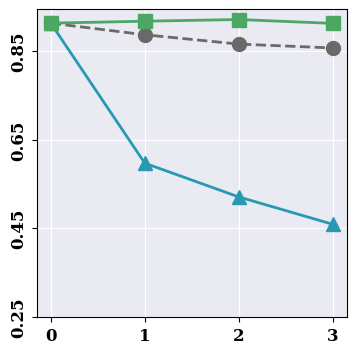

Visualizing ./results_sensitivity/nr_0.3/pet-37_cls.csv


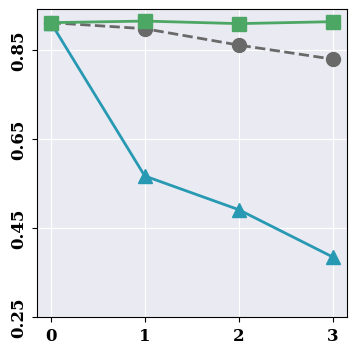

Visualizing ./results_sensitivity/nr_0.5/pet-37_cls.csv


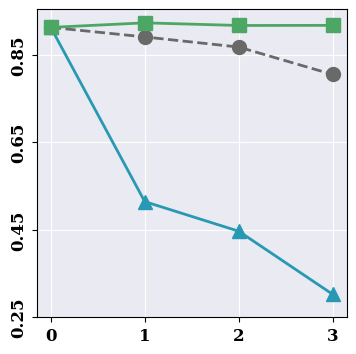

Visualizing ./results_sensitivity/nr_0.1/pet-37_rtv.csv


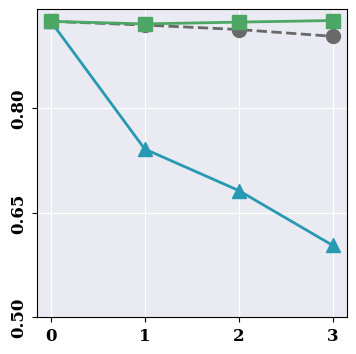

Visualizing ./results_sensitivity/nr_0.3/pet-37_rtv.csv


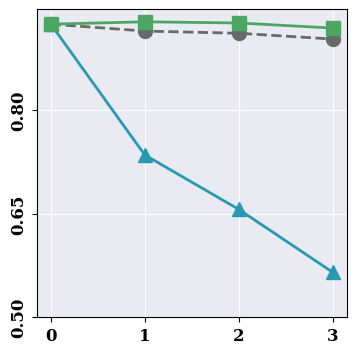

Visualizing ./results_sensitivity/nr_0.5/pet-37_rtv.csv


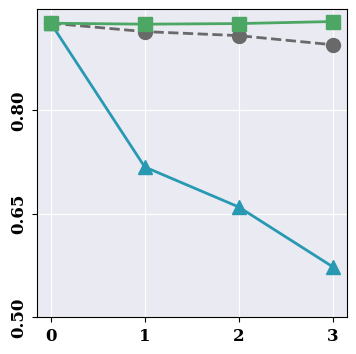

In [28]:
# results_file_path = f'./results_sensitivity/nr_0.1/pet-37_cls.csv'
# visualize(results_file_path)
for noise_ratio in [0.1, 0.3, 0.5]:
    results_file_path = f"./results_sensitivity/nr_{noise_ratio}/pet-37_cls.csv"
    print(f"Visualizing {results_file_path}")
    visualize(results_file_path)


for noise_ratio in [0.1, 0.3, 0.5]:
    results_file_path = f"./results_sensitivity/nr_{noise_ratio}/pet-37_rtv.csv"
    print(f"Visualizing {results_file_path}")
    visualize(results_file_path, type="rtv")

# 3、消融实验


## 表：Flower-102-sym


In [38]:
import warnings

warnings.filterwarnings("ignore")

import os
import sys

# 添加项目根目录到 sys.path
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(project_root)

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from core_model.custom_model import ClassifierWrapper, load_custom_model
from configs import settings
import logging

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up logging for better visibility
logging.basicConfig(
    level=logging.INFO,
    format="\033[1;36m%(asctime)s - %(levelname)s - %(message)s\033[0m",
)
logger = logging.getLogger(__name__)


def get_test_acc(test_loader, model, device):
    """
    Evaluate the test accuracy of a given model using a test dataset.
    """
    criterion = nn.CrossEntropyLoss()
    model.eval().to(device)
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        with tqdm(total=len(test_loader), desc=f"Testing") as pbar:
            for test_inputs, test_targets in test_loader:
                test_inputs, test_targets = test_inputs.to(device), test_targets.to(
                    device
                )
                test_outputs = model(test_inputs)
                loss = criterion(test_outputs, test_targets)
                _, predicted_test = torch.max(test_outputs, 1)
                total_test += test_targets.size(0)
                correct_test += (predicted_test == test_targets).sum().item()

                # Update progress bar
                pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
                pbar.update(1)

    test_accuracy = 100 * correct_test / total_test
    # logger.info(f"Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy


class BaseTensorDataset(Dataset):
    def __init__(self, data, labels, transforms=None, device=None):
        self.data = torch.as_tensor(data, device=device)
        self.labels = torch.as_tensor(labels, device=device)
        self.transforms = transforms
        logger.info(
            f"Dataset initialized with data shape: {data.shape} and labels shape: {labels.shape}"
        )

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        if self.transforms is not None:
            self.transforms(data)

        return data, self.labels[index]


def get_model_path(
    dataset_name, model_name, method, noise_ratio=0.5, noise_type="symmetric", suffix='restore'
):

    # TODO-241105 [sunzekun] 新的参数读取路径规则，先做初步测试用，对各个数据集需要分别根据文档的设定手写case（主要变的是noise_ratio)
    base_ckpt_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_{noise_ratio}_nt_{noise_type}_cvpr"
    return os.path.join(base_ckpt_path, method, f"{model_name}_{suffix}.pth")


def eva_test_acc_ablation(
    dataset_name,
    model_name,
    noise_type="symmetric",
    noise_ratio=0.5,
    methods=None,
    suffixs = ['restore'],
    results_dir=None,
    device="cuda",
):
    """
    Evaluate test accuracy for a specified dataset and set of methods.
    """
    assert methods is not None, "Please specify the methods to evaluate."
    assert results_dir is not None, "Please specify the directory to save the results."
    os.makedirs(results_dir, exist_ok=True)

    num_classes = settings.num_classes_dict[dataset_name]
    logger.info(
        f"Currently testing dataset: {dataset_name} with {num_classes} classes."
    )

    # Load test dataset
    batch_size = 64
    test_data_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_data.npy"
    test_label_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_label.npy"

    try:
        logger.info(f"Loading test data from: {test_data_path}")
        test_data = np.load(test_data_path)
        test_labels = np.load(test_label_path)
        logger.info(
            f"Test data loaded with shape: {test_data.shape}, Test labels loaded with shape: {test_labels.shape}"
        )
        test_dataset = BaseTensorDataset(test_data, test_labels, device=device)
        test_dataloader = DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, num_workers=0
        )
    except FileNotFoundError as e:
        logger.error(f"Error loading test dataset: {e}")
        return

    df = pd.DataFrame(index=methods, columns=suffixs)

    for method in methods:
        for suffix in suffixs:
            model_path = get_model_path(
                dataset_name, model_name, method, noise_ratio, noise_type, suffix
            )
            logger.info(f"Evaluating model from path: {model_path}")

            # Load model architecture and weights
            model = load_custom_model(model_name, num_classes, load_pretrained=False)
            model = ClassifierWrapper(model, num_classes)
            try:
                checkpoint = torch.load(model_path, map_location=device)
                logger.info(f"Loaded model checkpoint from {model_path}")
            except FileNotFoundError:
                logger.error(f"Cannot find the weight file at {model_path}. Skipping.")
                continue
            model.load_state_dict(checkpoint, strict=False)

            # Evaluate the model
            logger.info(f"Starting evaluation for method: {method}")
            test_acc = get_test_acc(test_dataloader, model, device)

            logger.info(f"Test Accuracy for {method}: {test_acc:.2f}%")
            # TODO-241105 [sunzkeun] 更换为：行为acc，列为方法。方便和最后的总表对齐
            df.loc[method, suffix] = test_acc

    # Save results to CSV
    mission_type = "sym" if noise_type == "symmetric" else "asym"
    results_file_name = f"{dataset_name}_{mission_type}.csv"
    results_file_dir = os.path.join(results_dir, results_file_name)
    df.to_csv(results_file_dir)
    logger.info(f"Results saved to {results_file_dir}")


# Example usage
if __name__ == "__main__":
    dataset_name = "flower-102"
    model_name = "wideresnet50"
    noise_type = "symmetric"
    noise_ratio = 0.5

    methods = [
        # 我们的方法
        "CRUL_lc",
        "CRUL_ul",
        "CRUL_ullc",
        "CRUL_full",
    ]

    results_dir = "./results_cvpr/ablation"
    # suffixs = ['restore'] # 24-11-07: 目前只测试: _restore.pth 这个模型的性能。如果要展示其它的参数可以更改这个    
    suffixs = ['restore', 'teacher_restore']

    eva_test_acc_ablation(
        dataset_name,
        model_name,
        noise_type,
        noise_ratio=noise_ratio,
        methods=methods,
        suffixs = suffixs,
        results_dir=results_dir,
    )

2024-11-07 12:11:09,428 - INFO - Currently testing dataset: flower-102 with 102 classes.
2024-11-07 12:11:09,429 - INFO - Loading test data from: /nvme/szh/code/tta-mr/data/flower-102/gen/test_data.npy
2024-11-07 12:11:09,633 - INFO - Test data loaded with shape: (1020, 3, 224, 224), Test labels loaded with shape: (1020,)
2024-11-07 12:11:09,674 - INFO - Dataset initialized with data shape: (1020, 3, 224, 224) and labels shape: (1020,)
2024-11-07 12:11:09,676 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/flower-102/nr_0.5_nt_symmetric_cvpr/CRUL_lc/wideresnet50_restore.pth
2024-11-07 12:11:10,508 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/flower-102/nr_0.5_nt_symmetric_cvpr/CRUL_lc/wideresnet50_restore.pth
2024-11-07 12:11:10,541 - INFO - Starting evaluation for method: CRUL_lc
Testing: 100%|██████████| 16/16 [00:00<00:00, 30.97it/s, Loss=1.8172]
2024-11-07 12:11:11,092 - INFO - Test Accuracy for CRUL_lc: 57.06%
2024-11-07 12:11:11,093 - INFO - Ev

## 表：PET-37

In [17]:
import warnings

warnings.filterwarnings("ignore")

import os
import sys

# 添加项目根目录到 sys.path
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(project_root)

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from core_model.custom_model import ClassifierWrapper, load_custom_model
from configs import settings
import logging

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up logging for better visibility
logging.basicConfig(
    level=logging.INFO,
    format="\033[1;36m%(asctime)s - %(levelname)s - %(message)s\033[0m",
)
logger = logging.getLogger(__name__)


def get_test_acc(test_loader, model, device):
    """
    Evaluate the test accuracy of a given model using a test dataset.
    """
    criterion = nn.CrossEntropyLoss()
    model.eval().to(device)
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        with tqdm(total=len(test_loader), desc=f"Testing") as pbar:
            for test_inputs, test_targets in test_loader:
                test_inputs, test_targets = test_inputs.to(device), test_targets.to(
                    device
                )
                test_outputs = model(test_inputs)
                loss = criterion(test_outputs, test_targets)
                _, predicted_test = torch.max(test_outputs, 1)
                total_test += test_targets.size(0)
                correct_test += (predicted_test == test_targets).sum().item()

                # Update progress bar
                pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
                pbar.update(1)

    test_accuracy = 100 * correct_test / total_test
    # logger.info(f"Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy


class BaseTensorDataset(Dataset):
    def __init__(self, data, labels, transforms=None, device=None):
        self.data = torch.as_tensor(data, device=device)
        self.labels = torch.as_tensor(labels, device=device)
        self.transforms = transforms
        logger.info(
            f"Dataset initialized with data shape: {data.shape} and labels shape: {labels.shape}"
        )

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        if self.transforms is not None:
            self.transforms(data)

        return data, self.labels[index]


def get_model_path(
    dataset_name, model_name, method, noise_ratio=0.5, noise_type="symmetric", suffix='restore'
):

    # TODO-241105 [sunzekun] 新的参数读取路径规则，先做初步测试用，对各个数据集需要分别根据文档的设定手写case（主要变的是noise_ratio)
    base_ckpt_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_{noise_ratio}_nt_{noise_type}_cvpr"
    return os.path.join(base_ckpt_path, method, f"{model_name}_{suffix}.pth")


def eva_test_acc_ablation(
    dataset_name,
    model_name,
    noise_type="symmetric",
    noise_ratio=0.5,
    methods=None,
    suffixs = ['restore'],
    results_dir=None,
    device="cuda",
):
    """
    Evaluate test accuracy for a specified dataset and set of methods.
    """
    assert methods is not None, "Please specify the methods to evaluate."
    assert results_dir is not None, "Please specify the directory to save the results."
    os.makedirs(results_dir, exist_ok=True)

    num_classes = settings.num_classes_dict[dataset_name]
    logger.info(
        f"Currently testing dataset: {dataset_name} with {num_classes} classes."
    )

    # Load test dataset
    batch_size = 64
    test_data_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_data.npy"
    test_label_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_label.npy"

    try:
        logger.info(f"Loading test data from: {test_data_path}")
        test_data = np.load(test_data_path)
        test_labels = np.load(test_label_path)
        logger.info(
            f"Test data loaded with shape: {test_data.shape}, Test labels loaded with shape: {test_labels.shape}"
        )
        test_dataset = BaseTensorDataset(test_data, test_labels, device=device)
        test_dataloader = DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, num_workers=0
        )
    except FileNotFoundError as e:
        logger.error(f"Error loading test dataset: {e}")
        return

    df = pd.DataFrame(index=methods, columns=suffixs)

    for method in methods:
        for suffix in suffixs:
            model_path = get_model_path(
                dataset_name, model_name, method, noise_ratio, noise_type, suffix
            )
            logger.info(f"Evaluating model from path: {model_path}")

            # Load model architecture and weights
            model = load_custom_model(model_name, num_classes, load_pretrained=False)
            model = ClassifierWrapper(model, num_classes)
            try:
                checkpoint = torch.load(model_path, map_location=device)
                logger.info(f"Loaded model checkpoint from {model_path}")
            except FileNotFoundError:
                logger.error(f"Cannot find the weight file at {model_path}. Skipping.")
                continue
            model.load_state_dict(checkpoint, strict=False)

            # Evaluate the model
            logger.info(f"Starting evaluation for method: {method}")
            test_acc = get_test_acc(test_dataloader, model, device)

            logger.info(f"Test Accuracy for {method}: {test_acc:.2f}%")
            # TODO-241105 [sunzkeun] 更换为：行为acc，列为方法。方便和最后的总表对齐
            df.loc[method, suffix] = test_acc

    # Save results to CSV
    mission_type = "sym" if noise_type == "symmetric" else "asym"
    results_file_name = f"{dataset_name}_{mission_type}.csv"
    results_file_dir = os.path.join(results_dir, results_file_name)
    df.to_csv(results_file_dir)
    logger.info(f"Results saved to {results_file_dir}")


# Example usage
if __name__ == "__main__":
    dataset_name = "pet-37"
    model_name = "wideresnet50"
    noise_type = "asymmetric"
    noise_ratio = 0.5

    methods = [
        # 我们的方法
        "CRUL_lc",
        "CRUL_ul",
        "CRUL_ullc",
        "CRUL_full",
    ]


    results_dir = "./results_cvpr/ablation"
    # suffixs = ['restore'] # 24-11-07: 目前只测试: _restore.pth 这个模型的性能。如果要展示其它的参数可以更改这个

    
    suffixs = ['restore', 'teacher_restore']

    eva_test_acc_ablation(
        dataset_name,
        model_name,
        noise_type,
        noise_ratio=noise_ratio,
        methods=methods,
        suffixs = suffixs,
        results_dir=results_dir,
    )

2024-11-09 17:07:31,101 - INFO - Currently testing dataset: pet-37 with 37 classes.
2024-11-09 17:07:31,103 - INFO - Loading test data from: /nvme/szh/code/tta-mr/data/pet-37/gen/test_data.npy
2024-11-09 17:07:31,586 - INFO - Test data loaded with shape: (3669, 3, 224, 224), Test labels loaded with shape: (3669,)
2024-11-09 17:07:31,783 - INFO - Dataset initialized with data shape: (3669, 3, 224, 224) and labels shape: (3669,)
2024-11-09 17:07:31,786 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_cvpr/CRUL_lc/wideresnet50_restore.pth
2024-11-09 17:07:32,627 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_cvpr/CRUL_lc/wideresnet50_restore.pth
2024-11-09 17:07:32,662 - INFO - Starting evaluation for method: CRUL_lc
Testing: 100%|██████████| 58/58 [00:01<00:00, 31.63it/s, Loss=0.5854]
2024-11-09 17:07:34,529 - INFO - Test Accuracy for CRUL_lc: 86.48%
2024-11-09 17:07:34,529 - INFO - Evaluating model 

## 图

In [18]:

!pwd

/nvme/szh/code/tta-mr/result_analysis


已知文件：

1. 使用 flower102 数据集 训练 CRUL 完整方法，下方文件记录了训练过程的history：

    文件1：../ckpt/flower-102/nr_0.5_nt_symmetric_cvpr/CRUL_full/wideresnet50_history.pth

2. 使用 flower102 数据集 训练 CRUL without unlearning module 方法， 下方文件记录了训练过程的history：

    文件2：../ckpt/flower-102/nr_0.5_nt_symmetric_cvpr/CRUL_ul/wideresnet50_history.pth

3. 使用 pet37  数据集 训练 CRUL 完整方法，下方文件记录了训练过程的history：

    文件3：../ckpt/pet-37/nr_0.25_nt_asymmetric_cvpr/CRUL_full/wideresnet50_history.pth

4. 使用 pet37 数据集 训练 CRUL without unlearning module 方法，下方文件记录了训练过程的history：

    文件4：../ckpt/pet-37/nr_0.25_nt_asymmetric_cvpr/CRUL_ul/wideresnet50_history.pth


读取文件：

1. 分别读取上述文件的history，并画出loss曲线，并保存为图片。
2. 其中，文件1和文件2绘制在一张图片a上，文件3和文件4绘制在一张图片b上。
3. 将上述图片保存为一张横向的图片，左边为图片a，右边为图片b。



In [19]:
import torch

# Path to the .pth file you want to inspect
file_path = "../ckpt/flower-102/nr_0.5_nt_symmetric_cvpr/CRUL_full/wideresnet50_history.pth"

# Load the .pth file
data = torch.load(file_path)

# Function to recursively print structure
def explore_structure(data, level=0):
    indent = "  " * level
    if isinstance(data, dict):
        print(f"{indent}Dictionary with keys: {list(data.keys())}")
        for key, value in data.items():
            print(f"{indent}Key: '{key}' - Type: {type(value)}")
            explore_structure(value, level + 1)
    elif isinstance(data, list):
        print(f"{indent}List with {len(data)} elements")
        if len(data) > 0:
            explore_structure(data[0], level + 1)
    elif isinstance(data, torch.Tensor):
        print(f"{indent}Tensor with shape: {data.shape}")
    else:
        print(f"{indent}Type: {type(data)}, Value: {data}")

# Explore the structure of the data
explore_structure(data)


List with 3 elements
  Type: <class 'float'>, Value: 0.5411764705882353


In [20]:
import torch


# Load the .pth file
file_paths = [
    "../ckpt/flower-102/nr_0.5_nt_symmetric_cvpr/CRUL_full/wideresnet50_history.pth",
    "../ckpt/flower-102/nr_0.5_nt_symmetric_cvpr/CRUL_ul/wideresnet50_history.pth",
    "../ckpt/pet-37/nr_0.5_nt_asymmetric_cvpr/CRUL_full/wideresnet50_history.pth",
    "../ckpt/pet-37/nr_0.5_nt_asymmetric_cvpr/CRUL_ul/wideresnet50_history.pth"
    ]

for file_path in file_paths:
    data = torch.load(file_path)

    print(f"current_file is: ", file_path)
    # Check if the data is a list and print individual values
    if isinstance(data, list):
        for i, value in enumerate(data):
            print(f"Element {i}: {value}")
    else:
        print("The data is not a list. Please check the structure again.")


current_file is:  ../ckpt/flower-102/nr_0.5_nt_symmetric_cvpr/CRUL_full/wideresnet50_history.pth
Element 0: 0.5411764705882353
Element 1: 0.6235294117647059
Element 2: 0.6754901960784314
current_file is:  ../ckpt/flower-102/nr_0.5_nt_symmetric_cvpr/CRUL_ul/wideresnet50_history.pth
Element 0: 0.5176470588235295
Element 1: 0.6411764705882353
Element 2: 0.6852941176470588
current_file is:  ../ckpt/pet-37/nr_0.5_nt_asymmetric_cvpr/CRUL_full/wideresnet50_history.pth
Element 0: 0.9095121286454074
Element 1: 0.9122376669392205
Element 2: 0.9097846824747887
Element 3: 0.8986099754701553
Element 4: 0.8986099754701553
Element 5: 0.8994276369582993
Element 6: 0.8956118833469611
Element 7: 0.8947942218588171
Element 8: 0.8893431452711911
Element 9: 0.8841646225129463
current_file is:  ../ckpt/pet-37/nr_0.5_nt_asymmetric_cvpr/CRUL_ul/wideresnet50_history.pth
Element 0: 0.913600436086127
Element 1: 0.91632597437994
Element 2: 0.8953393295175798
Element 3: 0.8980648678113927
Element 4: 0.898064867811

<ipython-input-5-dd777a5187a9>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  histories = {key: torch.load(path) for key, path in file_paths.items()}


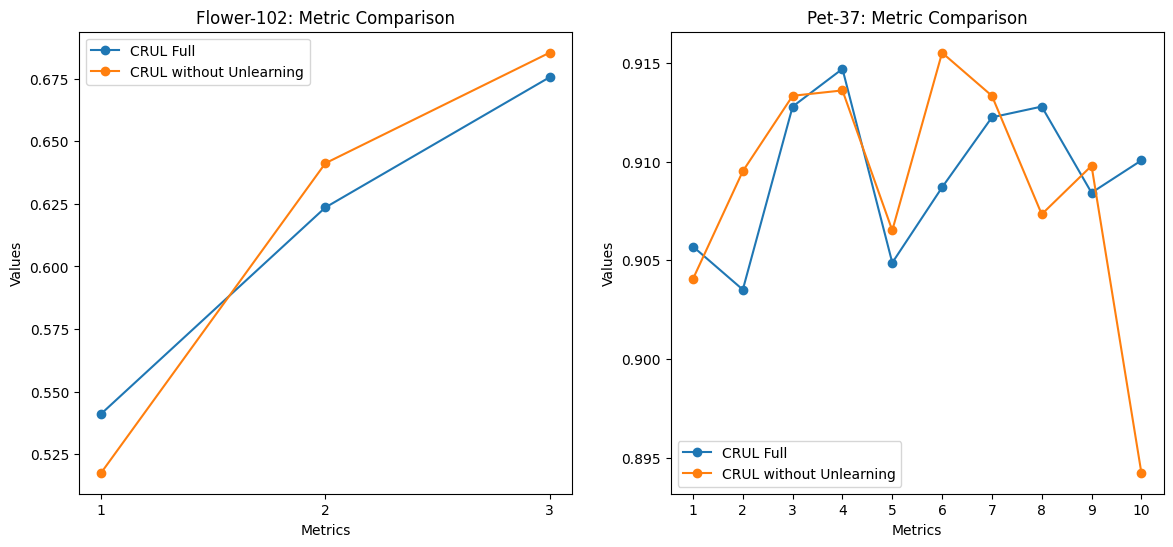

In [5]:
import torch
import matplotlib.pyplot as plt
plt.style.use("default")
# Define paths for each history file
file_paths = {
    "flower_full": "../ckpt/flower-102/nr_0.5_nt_symmetric_cvpr/CRUL_full/wideresnet50_history.pth",
    "flower_without_ul": "../ckpt/flower-102/nr_0.5_nt_symmetric_cvpr/CRUL_ul/wideresnet50_history.pth",
    "pet_full": "../ckpt/pet-37/nr_0.5_nt_asymmetric_cvpr/CRUL_full/wideresnet50_history.pth",
    "pet_without_ul": "../ckpt/pet-37/nr_0.5_nt_asymmetric_cvpr/CRUL_ul/wideresnet50_history.pth",
}

# Load the data from each file
histories = {key: torch.load(path) for key, path in file_paths.items()}

# Plot for Flower-102 dataset (CRUL Full vs CRUL without Unlearning)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(histories["flower_full"]) + 1), histories["flower_full"], 'o-', label="CRUL Full")
plt.plot(range(1, len(histories["flower_without_ul"]) + 1), histories["flower_without_ul"], 'o-', label="CRUL without Unlearning")
plt.xticks(range(1, len(histories["flower_full"]) + 1))
plt.title("Flower-102: Metric Comparison")
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.legend()

# Plot for Pet-37 dataset (CRUL Full vs CRUL without Unlearning)
plt.subplot(1, 2, 2)
plt.plot(range(1, len(histories["pet_full"]) + 1), histories["pet_full"], 'o-', label="CRUL Full")
plt.plot(range(1, len(histories["pet_without_ul"]) + 1), histories["pet_without_ul"], 'o-', label="CRUL without Unlearning")
plt.xticks(range(1, len(histories["pet_full"]) + 1))
plt.title("Pet-37: Metric Comparison")
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.legend()

# Save combined plot as a single image
plt.savefig("crul_loss_comparison.png", bbox_inches="tight")


# SEP ---------------------

# 附录

混淆矩阵：对比实验 -1

In [9]:
import torch
import numpy as np
import os


def predict_and_save_pet37(
    dataset_name,
    model_name,
    noise_type="asymmetric",
    noise_ratio=0.5,
    methods=None,
    steps=None,
    output_dir="predictions/",
):
    """
    使用 pet37 数据集对模型进行预测，并保存预测结果。
    """

    # 确保输出目录存在
    os.makedirs(output_dir, exist_ok=True)

    # 加载数据集相关参数
    case = settings.get_case(
        noise_ratio=noise_ratio, noise_type=noise_type, balanced=True
    )
    mean, std = None, None
    num_classes = settings.num_classes_dict[dataset_name]
    print(f"目前测试的数据集：{dataset_name}, case模式：{case}")

    # 读入测试数据集
    test_data, test_labels, test_dataloader = get_dataset_loader(
        dataset_name, "test", None, None, mean, std, batch_size=128, shuffle=False
    )

    assert methods is not None, "请指定要评估的方法"
    assert steps is not None, "请指定要评估的 step(实验组)"

    # 遍历每种方法和 step，进行预测
    for method in methods:
        for step in steps:
            # 构造模型路径
            base_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_{noise_ratio}_nt_{noise_type}_balanced/step_{step}/{method}"

            # 根据文件名模式确定模型文件名
            if method == "contra":
                if step == 0:
                    model_file_name = "wideresnet50_worker_restore.pth"
                else:
                    model_file_name = "wideresnet50_worker_tta.pth"
            elif method in [
                "Coteaching",
                "Coteachingplus",
                "JoCoR",
                "cotta",
                "plf",
                "raw",
                "replay",
            ]:
                model_file_name = "wideresnet50_worker_restore.pth"
            else:
                print(f"Unknown method: {method}, skipping...")
                continue

            # 完整模型路径
            model_repair_save_path = os.path.join(base_path, model_file_name)
            print(f"Evaluating {model_repair_save_path}")

            # 尝试加载模型
            if not os.path.exists(model_repair_save_path):
                print(
                    f"Cannot find the weight file at {model_repair_save_path}. Just SKIP."
                )
                continue

            model = load_custom_model(model_name, num_classes, load_pretrained=False)
            model = ClassifierWrapper(model, num_classes)

            checkpoint = torch.load(model_repair_save_path)
            model.load_state_dict(checkpoint, strict=False)
            model.eval()

            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device)

            # 进行预测
            all_predictions = []

            with torch.no_grad():
                for inputs, _ in test_dataloader:
                    inputs = inputs.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    all_predictions.append(preds.cpu().numpy())

            # 将所有预测结果拼接并保存
            all_predictions = np.concatenate(all_predictions, axis=0)
            output_file = os.path.join(
                output_dir, f"{method}_step_{step}_predictions.npy"
            )
            np.save(output_file, all_predictions)
            print(f"Predictions saved to {output_file}")


# 使用示例
dataset_name = "pet-37"
model_name = "wideresnet50"
methods = [
    "contra",
    "Coteaching",
    "Coteachingplus",
    "JoCoR",
    "cotta",
    "plf",
    "raw",
    "replay",
]  # 需要评估的方法
steps = [0, 1, 2, 3]  # 评估的 steps
output_dir = "predictions_pet37"

predict_and_save_pet37(
    dataset_name, model_name, methods=methods, steps=steps, output_dir=output_dir
)

目前测试的数据集：pet-37, case模式：nr_0.2_nt_asymmetric_balanced
Loading /nvme/szh/code/tta-mr/data/pet-37/gen/test_data.npy
Evaluating /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_0/contra/wideresnet50_worker_restore.pth


/tmp/ipykernel_93863/3031640693.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Predictions saved to predictions_pet37/contra_step_0_predictions.npy
Evaluating /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_1/contra/wideresnet50_worker_tta.pth
Predictions saved to predictions_pet37/contra_step_1_predictions.npy
Evaluating /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_2/contra/wideresnet50_worker_tta.pth
Predictions saved to predictions_pet37/contra_step_2_predictions.npy
Evaluating /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_3/contra/wideresnet50_worker_tta.pth
Predictions saved to predictions_pet37/contra_step_3_predictions.npy
Evaluating /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_0/Coteaching/wideresnet50_worker_restore.pth
Predictions saved to predictions_pet37/Coteaching_step_0_predictions.npy
Evaluating /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_1/Coteaching/wideresnet50_worker_restore.pth
Predictions saved to predictions_pet37/Coteaching_

/tmp/ipykernel_93863/160249716.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


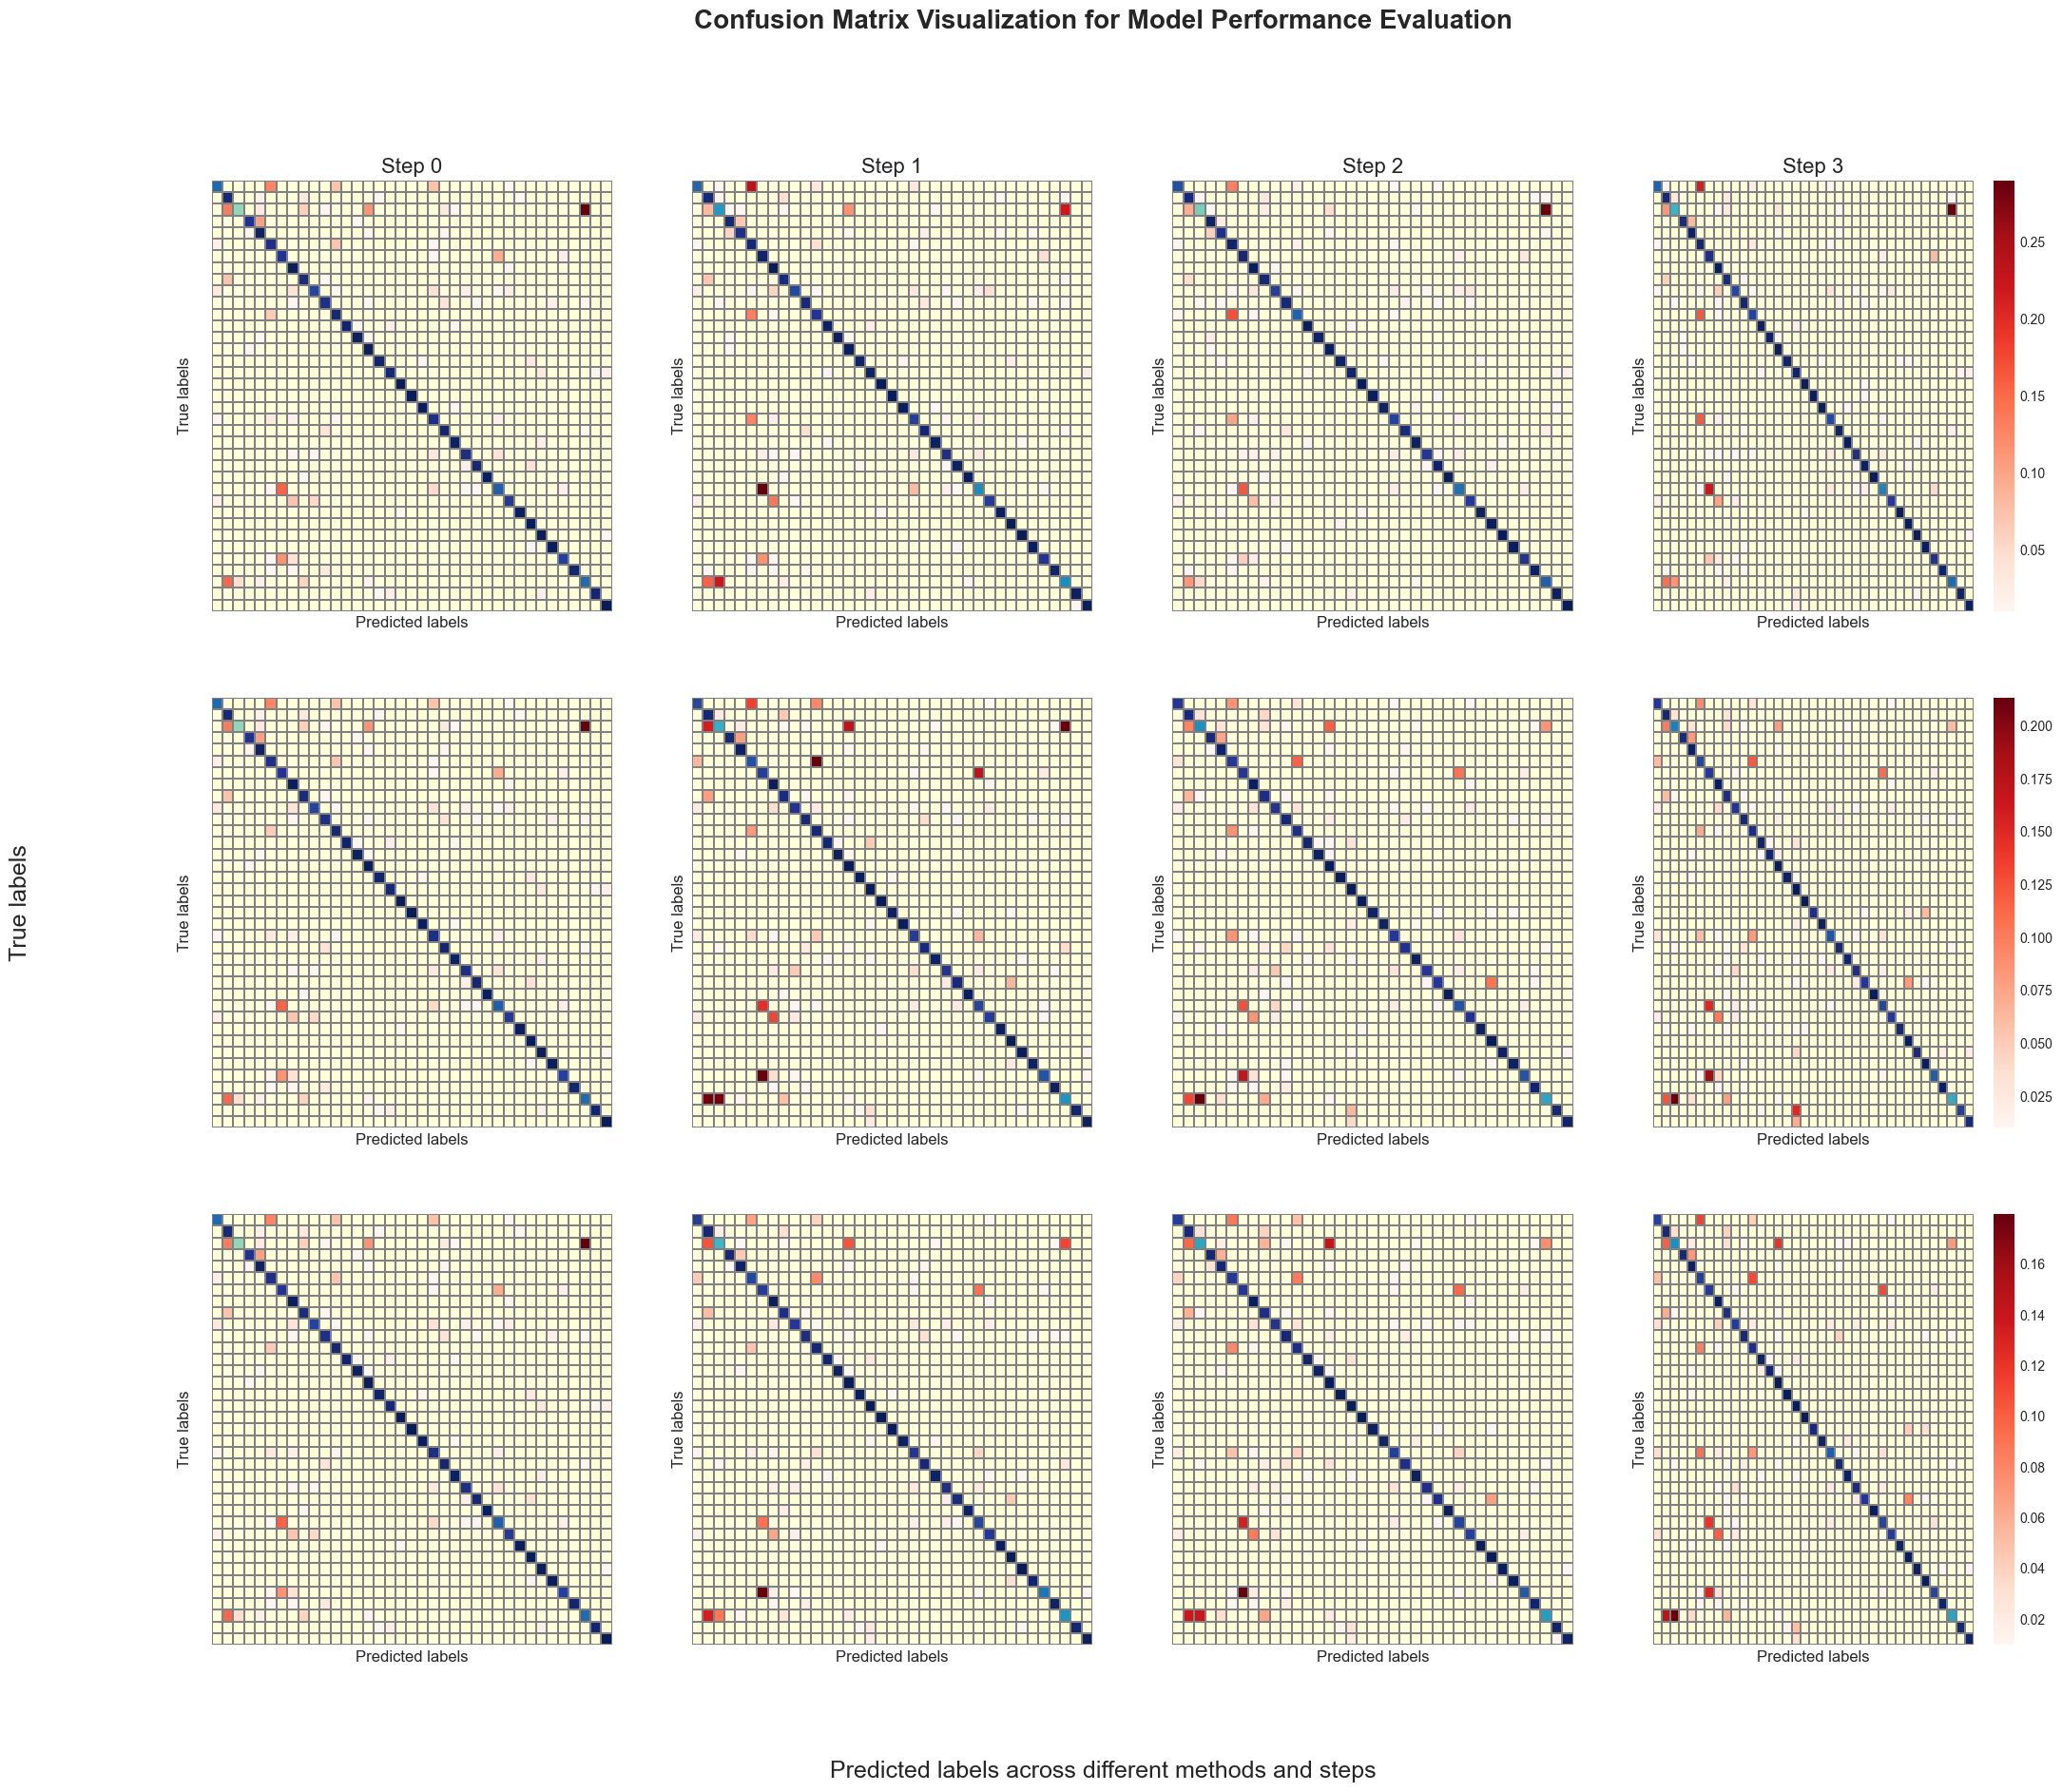

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 加载真实标签
true_labels_path = "/nvme/szh/code/tta-mr/data/pet-37/gen/test_label.npy"
true_labels = np.load(true_labels_path)

# 定义预测文件路径和方法
methods = ["contra", "Coteaching", "JoCoR"]
steps = [0, 1, 2, 3]
labels_order = list(range(37))  # 标签类别顺序（0 到 36）

# 设置绘图风格
plt.style.use("seaborn-white")

# 创建一个大画布
fig, axes = plt.subplots(len(methods), len(steps), figsize=(25, 20))

# 遍历每个方法和步骤
for method_idx, method in enumerate(methods):
    for step_idx, step in enumerate(steps):
        # 加载预测标签
        predictions_path = f"predictions_pet37/{method}_step_{step}_predictions.npy"
        predicted_labels = np.load(predictions_path)

        # 计算混淆矩阵（归一化到真实标签上）
        cm = confusion_matrix(
            true_labels, predicted_labels, labels=labels_order, normalize="true"
        )

        # 创建新的矩阵以区分对视线和非对视线部分
        cm_diag = np.zeros_like(cm)
        cm_off_diag = np.zeros_like(cm)

        # 分离对视线和非对视线部分
        for i in range(len(labels_order)):
            for j in range(len(labels_order)):
                if i == j:
                    cm_diag[i, j] = cm[i, j]  # 对视线部分
                else:
                    cm_off_diag[i, j] = cm[i, j]  # 非对视线部分

        # 在对应的子图上绘制对视线部分（正确分类）
        ax = axes[method_idx, step_idx]
        sns.heatmap(
            cm_diag,
            annot=False,
            cmap="YlGnBu",  # 对视线部分使用浅色调，表示正确分类
            cbar=False,
            xticklabels=labels_order,
            yticklabels=labels_order,
            ax=ax,
            linewidths=0.1,
            linecolor="gray",
        )

        # 绘制非对视线部分（错误分类）以增强误分类展示效果
        sns.heatmap(
            cm_off_diag,
            annot=False,
            cmap="Reds",  # 非对视线部分使用醒目的红色调，表示误分类
            cbar=(step_idx == len(steps) - 1),  # 最后一列添加颜色条
            xticklabels=labels_order,
            yticklabels=labels_order,
            ax=ax,
            mask=(cm_off_diag == 0),  # 隐藏没有误分类的部分
            linewidths=0.1,
            linecolor="gray",
        )

        # 设置标题、标签
        if step_idx == 0:
            ax.set_ylabel(f"{method}", fontsize=16, labelpad=15)
        if method_idx == 0:
            ax.set_title(f"Step {step}", fontsize=16)
        ax.set_xlabel("Predicted labels", fontsize=12)
        ax.set_ylabel("True labels", fontsize=12)

        # 取消 x 和 y 的刻度，以减少杂乱
        ax.set_xticks([])
        ax.set_yticks([])

# # 调整整体布局
# plt.tight_layout(pad=3.0)
# plt.subplots_adjust(top=0.92)
# fig.suptitle("Confusion Matrices Across Methods and Steps", fontsize=24)

# 添加图注
fig.text(
    0.5,
    0.04,
    "Predicted labels across different methods and steps",
    ha="center",
    fontsize=18,
)
fig.text(0.04, 0.5, "True labels", va="center", rotation="vertical", fontsize=18)
fig.text(
    0.5,
    0.96,
    "Confusion Matrix Visualization for Model Performance Evaluation",
    ha="center",
    fontsize=20,
    weight="bold",
)

# 保存为 PDF
plt.savefig("confusion_matrices_pet37.pdf", format="pdf")

# 显示结果
plt.show()

/tmp/ipykernel_93863/4272119692.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


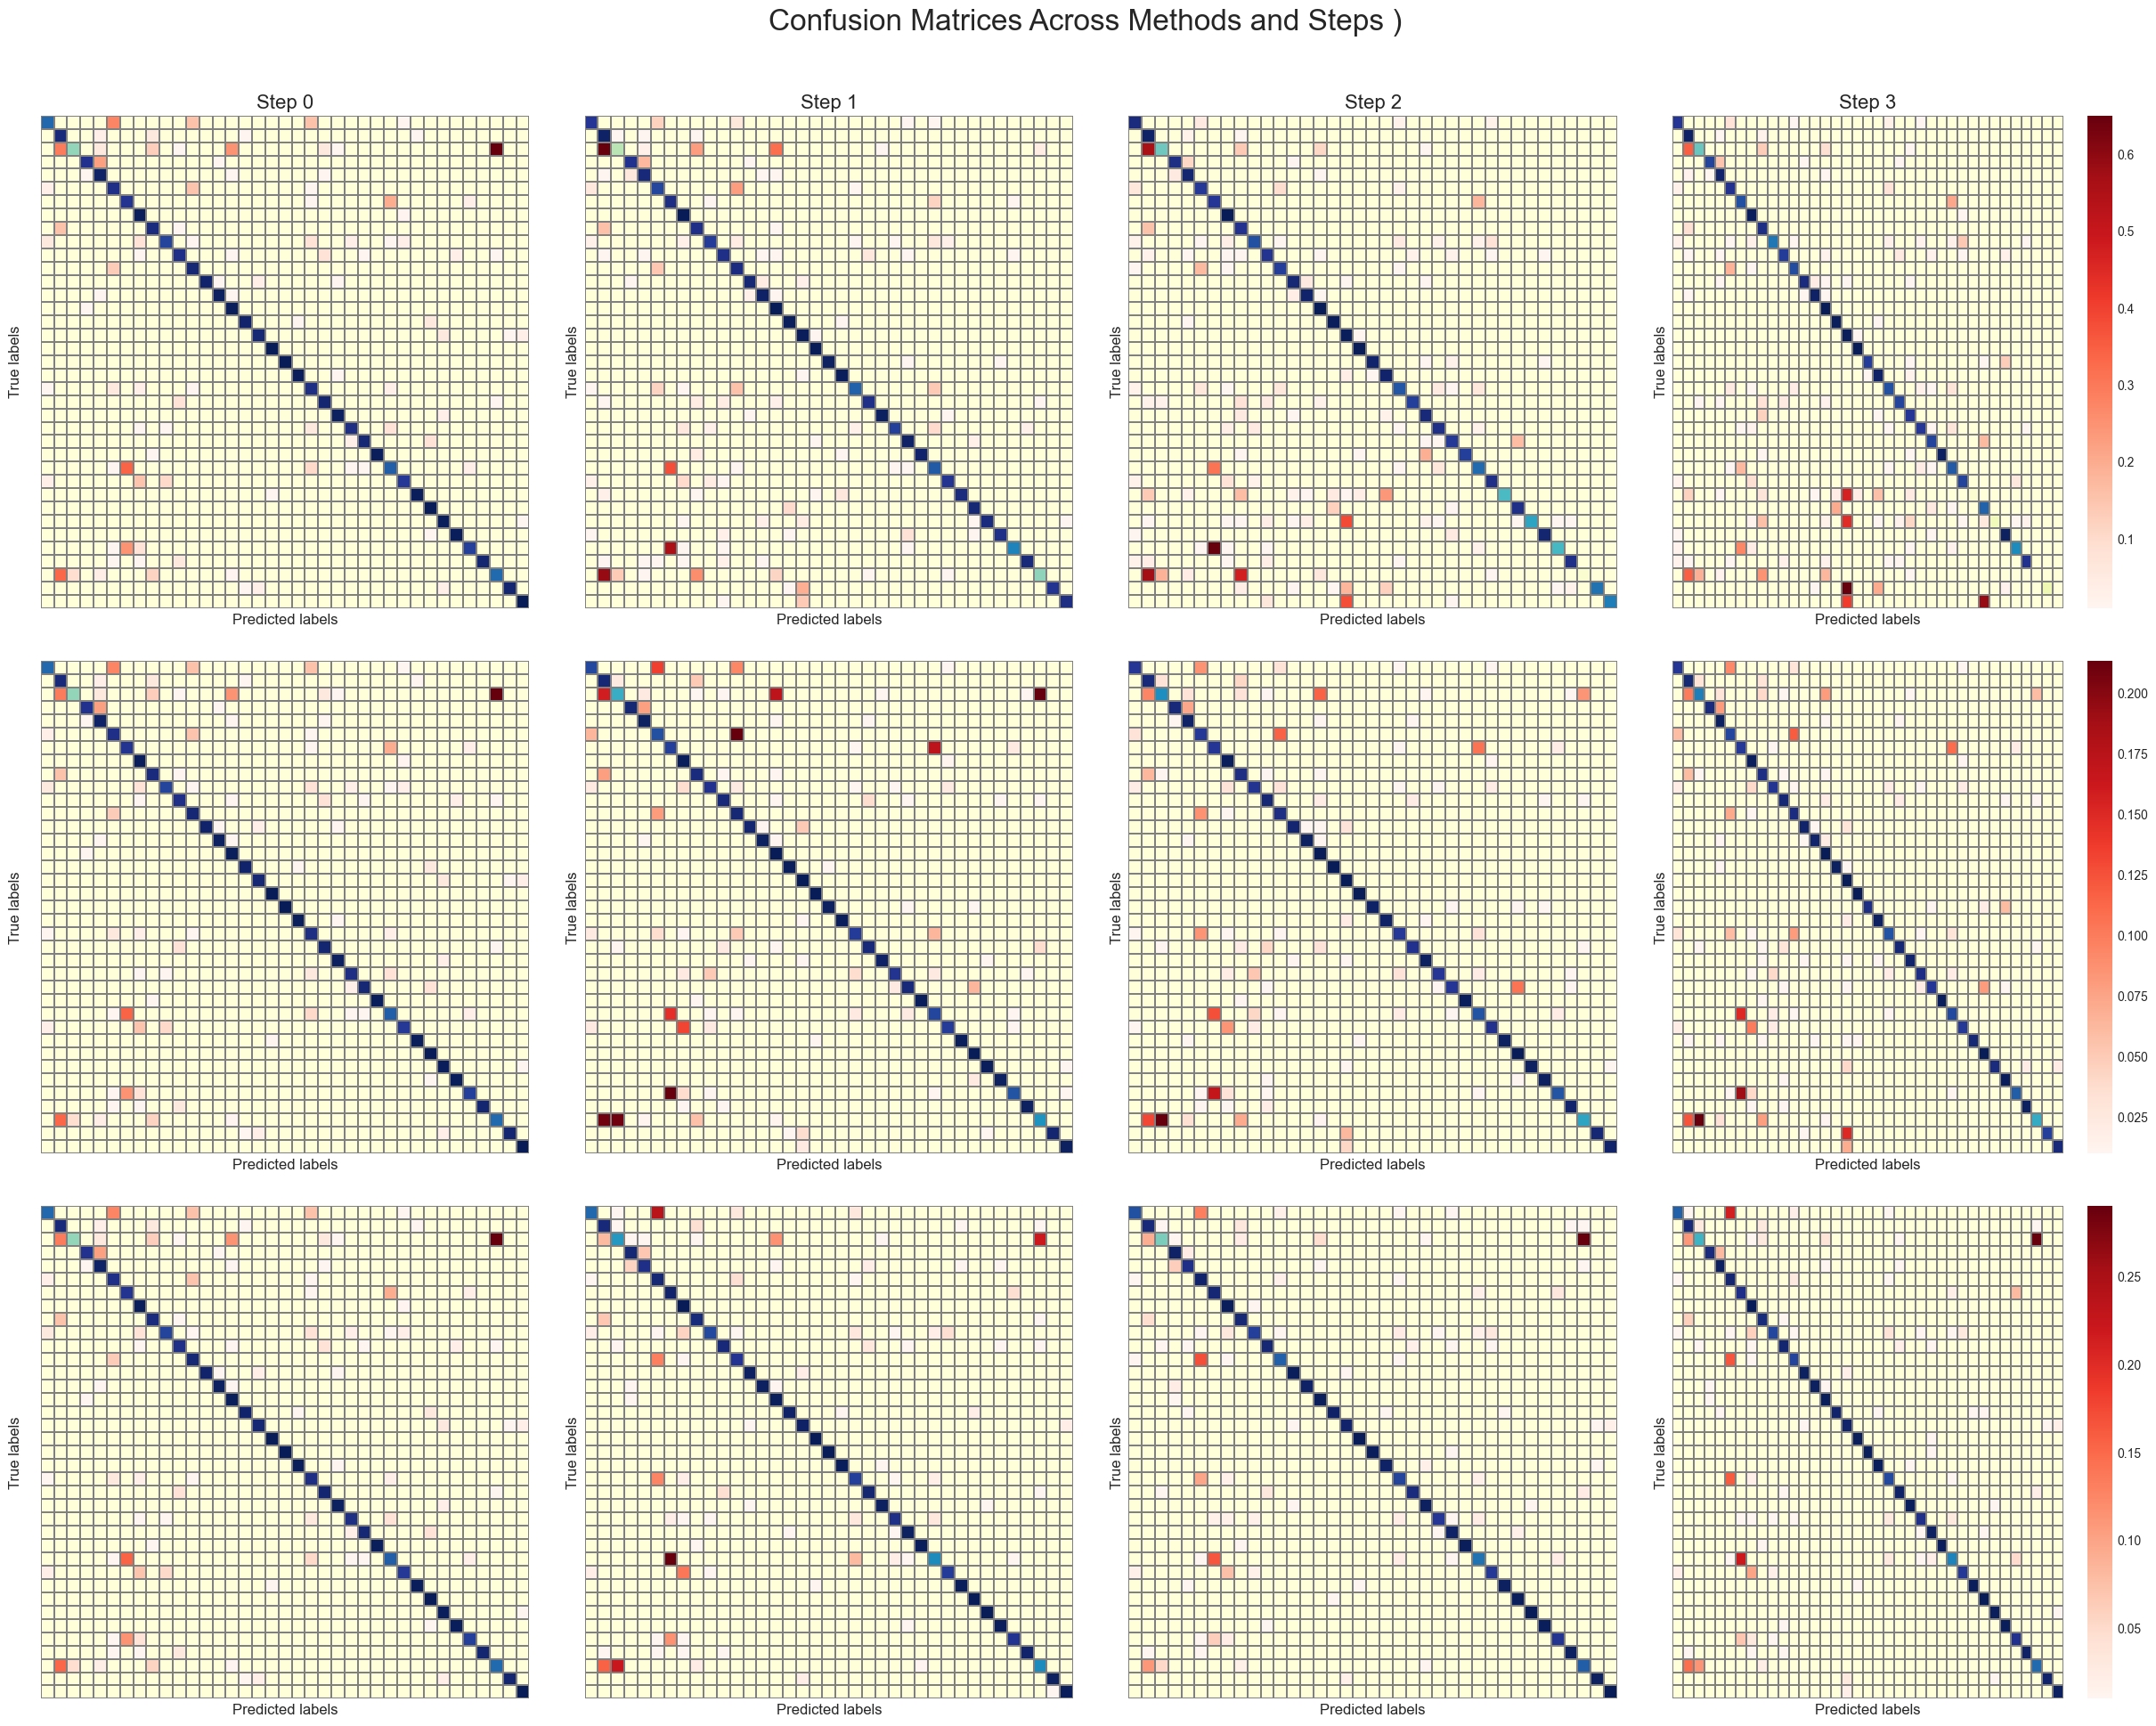

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 加载真实标签
true_labels_path = "/nvme/szh/code/tta-mr/data/pet-37/gen/test_label.npy"
true_labels = np.load(true_labels_path)

# 定义预测文件路径和方法
methods = ["raw", "Coteaching", "contra"]
# methods = ["contra", "Coteaching", "Coteachingplus", "JoCoR", "cotta", "plf", "raw", "replay"]  # 需要评估的方法

steps = [0, 1, 2, 3]
labels_order = list(range(37))  # 标签类别顺序（0 到 36）

# 设置绘图风格
plt.style.use("seaborn-white")

# 创建一个大画布
fig, axes = plt.subplots(len(methods), len(steps), figsize=(25, 20))

# 遍历每个方法和步骤
for method_idx, method in enumerate(methods):
    for step_idx, step in enumerate(steps):
        # 加载预测标签
        predictions_path = f"predictions_pet37/{method}_step_{step}_predictions.npy"
        predicted_labels = np.load(predictions_path)

        # 计算混淆矩阵（归一化到真实标签上）
        cm = confusion_matrix(
            true_labels, predicted_labels, labels=labels_order, normalize="true"
        )

        # 创建新的矩阵以区分对角线和非对角线部分
        cm_diag = np.zeros_like(cm)
        cm_off_diag = np.zeros_like(cm)

        # 分离对角线和非对角线部分
        for i in range(len(labels_order)):
            for j in range(len(labels_order)):
                if i == j:
                    cm_diag[i, j] = cm[i, j]  # 对角线部分
                else:
                    cm_off_diag[i, j] = cm[i, j]  # 非对角线部分

        # 在对应的子图上绘制对角线部分（正确分类）
        ax = axes[method_idx, step_idx]
        sns.heatmap(
            cm_diag,
            annot=False,
            cmap="YlGnBu",  # 对角线部分使用浅色调，表示正确分类
            cbar=False,
            xticklabels=labels_order,
            yticklabels=labels_order,
            ax=ax,
            linewidths=0.1,
            linecolor="gray",
        )

        # 绘制非对角线部分（错误分类）以增强误分类展示效果
        sns.heatmap(
            cm_off_diag,
            annot=False,
            cmap="Reds",  # 非对角线部分使用醒目的红色调，表示误分类
            cbar=(step_idx == len(steps) - 1),  # 最后一列添加颜色条
            xticklabels=labels_order,
            yticklabels=labels_order,
            ax=ax,
            mask=(cm_off_diag == 0),  # 隐藏没有误分类的部分
            linewidths=0.1,
            linecolor="gray",
        )

        # 设置标题、标签
        if step_idx == 0:
            ax.set_ylabel(f"{method}", fontsize=16, labelpad=15)
        if method_idx == 0:
            ax.set_title(f"Step {step}", fontsize=16)
        ax.set_xlabel("Predicted labels", fontsize=12)
        ax.set_ylabel("True labels", fontsize=12)

        # 取消 x 和 y 的刻度，以减少杂乱
        ax.set_xticks([])
        ax.set_yticks([])

# 调整整体布局
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.92)
fig.suptitle("Confusion Matrices Across Methods and Steps )", fontsize=24)

# 显示结果
plt.show()

/tmp/ipykernel_93863/1834694111.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


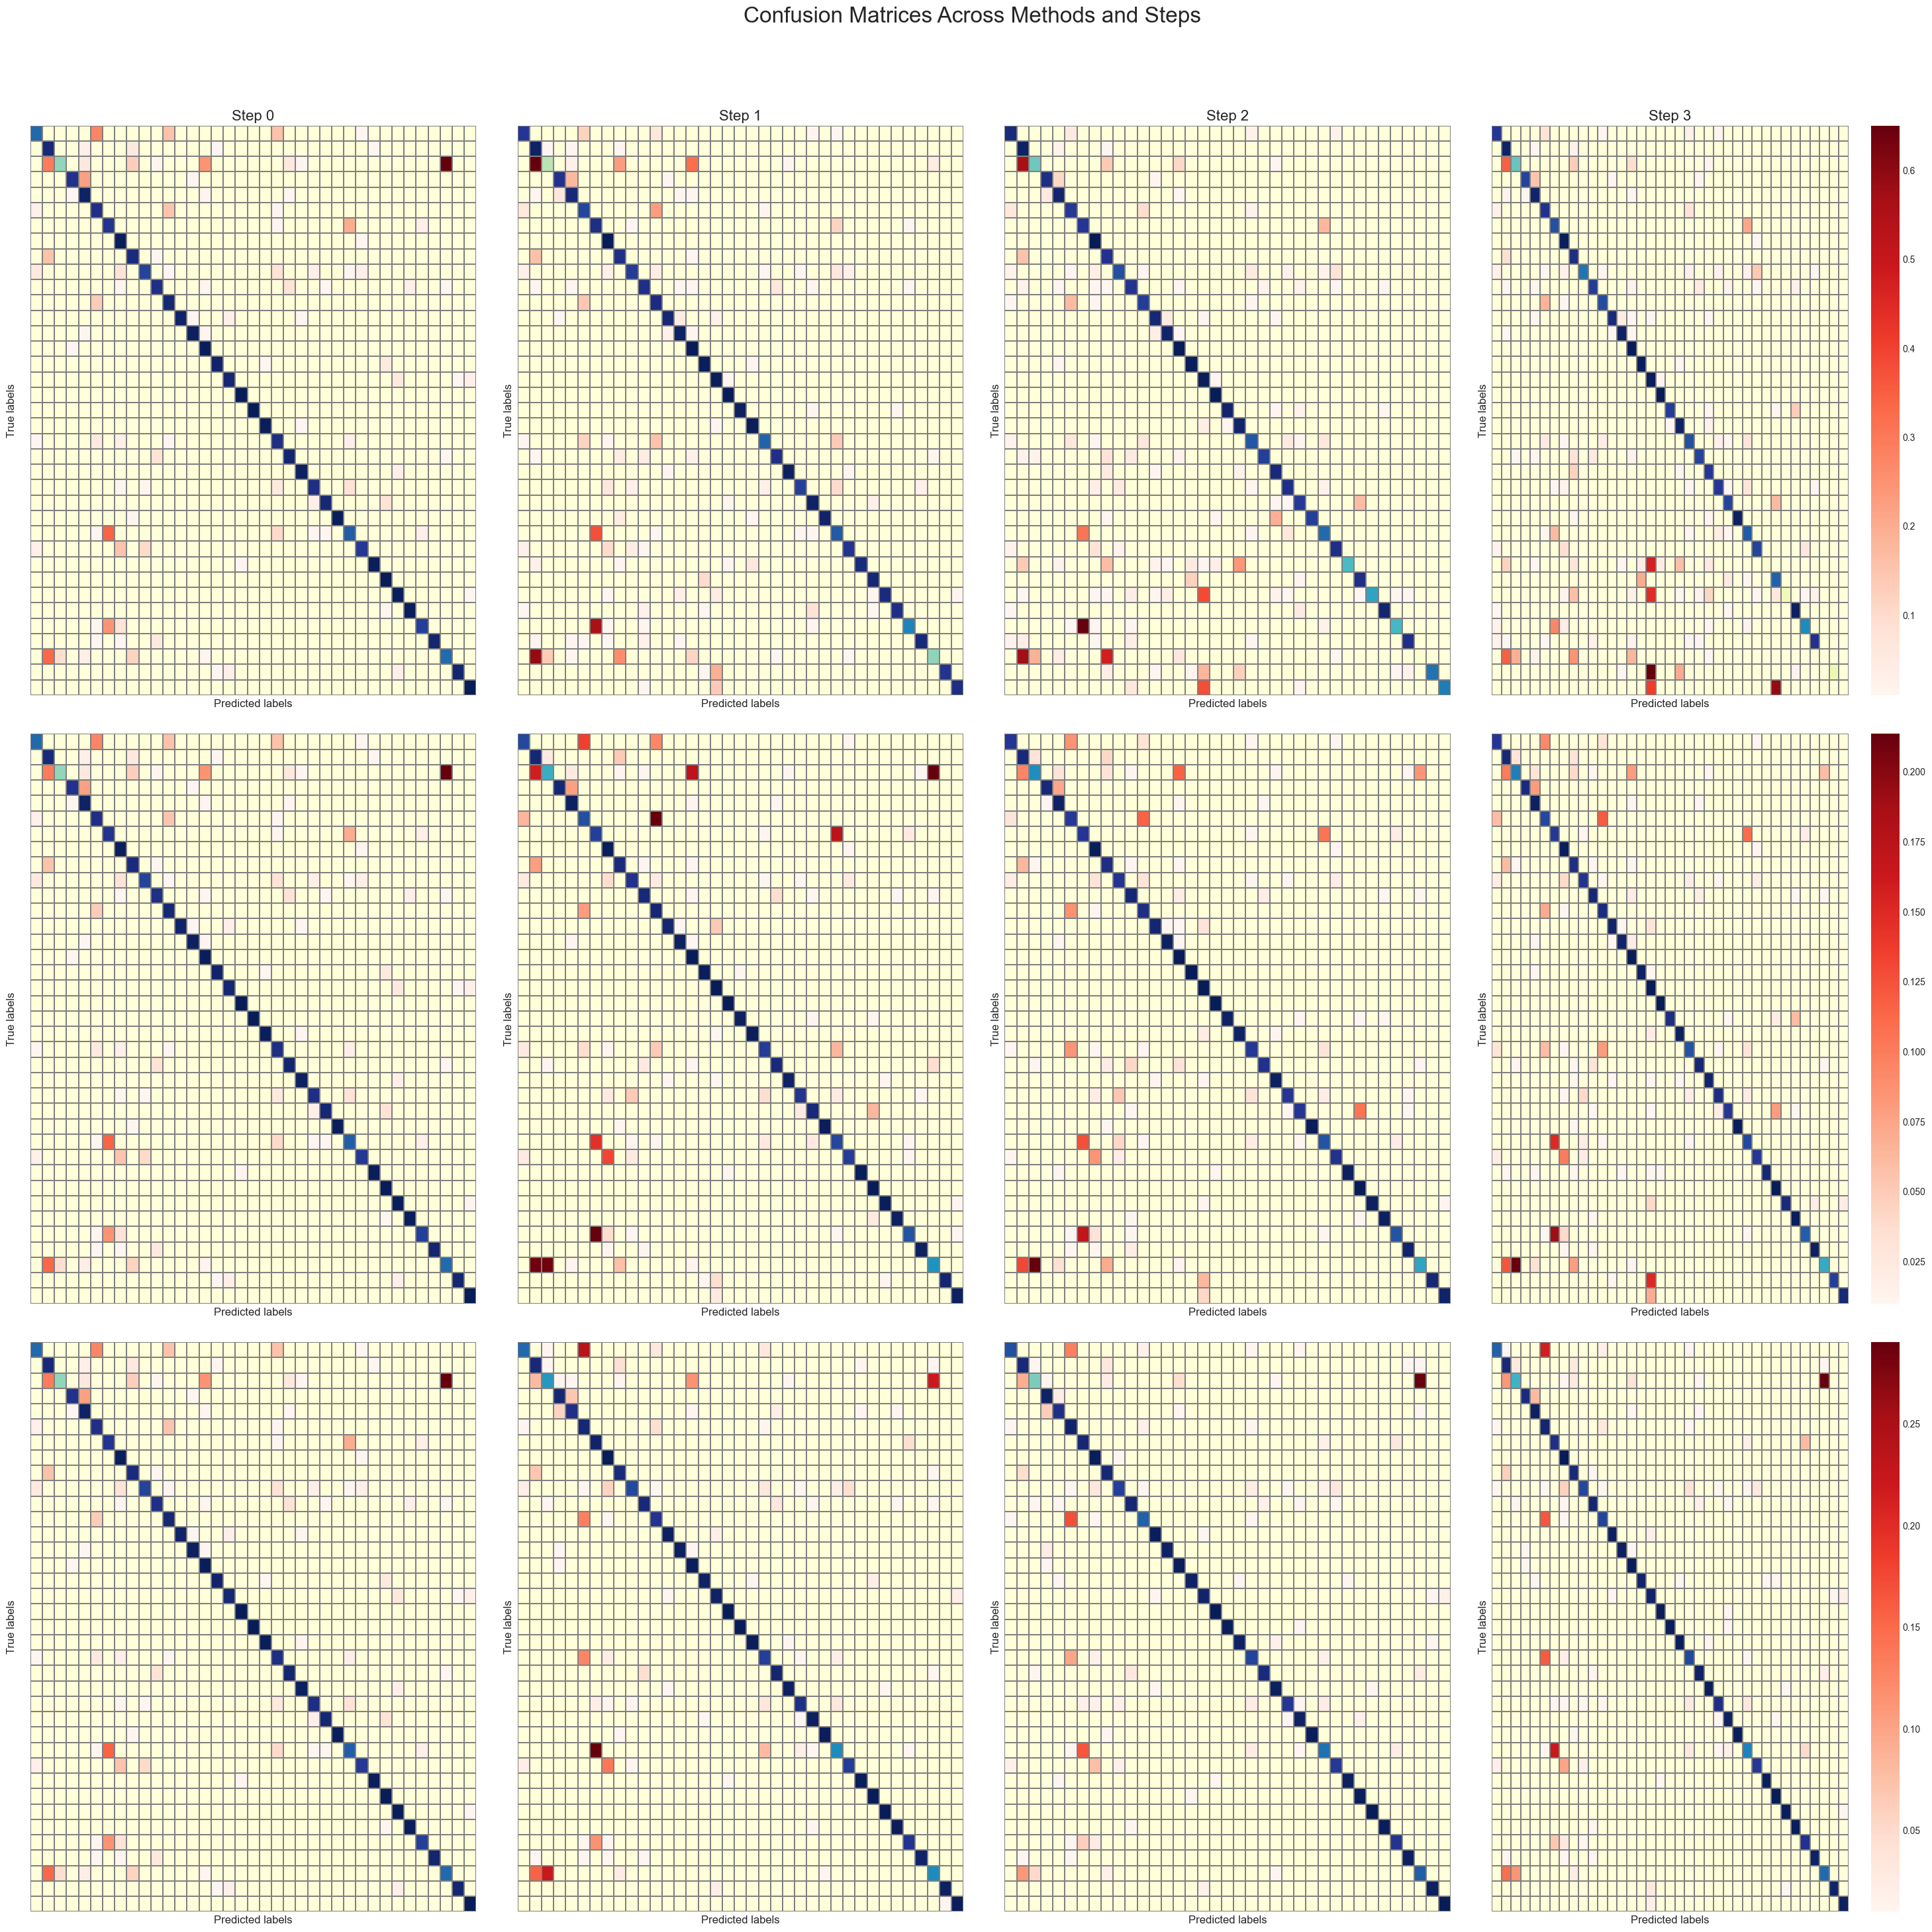

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 加载真实标签
true_labels_path = "/nvme/szh/code/tta-mr/data/pet-37/gen/test_label.npy"
true_labels = np.load(true_labels_path)

# 定义预测文件路径和方法
methods = ["raw", "Coteaching", "contra"]
steps = [0, 1, 2, 3]
labels_order = list(range(37))  # 标签类别顺序（0 到 36）

# 设置绘图风格
plt.style.use("seaborn-white")

# 创建一个大画布
fig, axes = plt.subplots(len(methods), len(steps), figsize=(30, 30))

# 遍历每个方法和步骤
method_labels = ["Standard", "Coteaching", "Contra"]
for method_idx, method in enumerate(methods):
    for step_idx, step in enumerate(steps):
        # 加载预测标签
        predictions_path = f"predictions_pet37/{method}_step_{step}_predictions.npy"
        predicted_labels = np.load(predictions_path)

        # 计算混淆矩阵（归一化到真实标签上）
        cm = confusion_matrix(
            true_labels, predicted_labels, labels=labels_order, normalize="true"
        )

        # 创建新的矩阵以区分对视线和非对视线部分
        cm_diag = np.zeros_like(cm)
        cm_off_diag = np.zeros_like(cm)

        # 分离对视线和非对视线部分
        for i in range(len(labels_order)):
            for j in range(len(labels_order)):
                if i == j:
                    cm_diag[i, j] = cm[i, j]  # 对视线部分
                else:
                    cm_off_diag[i, j] = cm[i, j]  # 非对视线部分

        # 在对应的子图上绘制对视线部分（正确分类）
        ax = axes[method_idx, step_idx]
        sns.heatmap(
            cm_diag,
            annot=False,
            cmap="YlGnBu",  # 对视线部分使用浅色调，表示正确分类
            cbar=False,
            xticklabels=labels_order,
            yticklabels=labels_order,
            ax=ax,
            linewidths=0.1,
            linecolor="gray",
        )

        # 绘制非对视线部分（错误分类）以增强误分类展示效果
        sns.heatmap(
            cm_off_diag,
            annot=False,
            cmap="Reds",  # 非对视线部分使用醒目的红色调，表示误分类
            cbar=(step_idx == len(steps) - 1),  # 最后一列添加颜色条
            xticklabels=labels_order,
            yticklabels=labels_order,
            ax=ax,
            mask=(cm_off_diag == 0),  # 隐藏没有误分类的部分
            linewidths=0.1,
            linecolor="gray",
        )

        # 设置标题、标签
        if step_idx == 0:
            ax.set_ylabel(method_labels[method_idx], fontsize=16, labelpad=15)
        if method_idx == 0:
            ax.set_title(f"Step {step}", fontsize=16)
        ax.set_xlabel("Predicted labels", fontsize=12)
        ax.set_ylabel("True labels", fontsize=12)

        # 取消 x 和 y 的刻度，以减少杂乱
        ax.set_xticks([])
        ax.set_yticks([])

# 调整整体布局
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.92)
fig.suptitle("Confusion Matrices Across Methods and Steps", fontsize=24)

# # 添加图注
# fig.text(0.5, 0.04, 'Predicted labels across different methods and steps', ha='center', fontsize=18)
# fig.text(0.04, 0.5, 'True labels', va='center', rotation='vertical', fontsize=18)
# fig.text(0.5, 0.96, 'Confusion Matrix Visualization for Model Performance Evaluation', ha='center', fontsize=20, weight='bold')

# 保存为 PDF
plt.savefig("confusion_matrices_pet37.pdf", format="pdf")

# 保存为 PDF
plt.savefig("confusion_matrices_pet37.pdf", format="pdf")

# 显示结果
plt.show()

混淆矩阵：消融实验 -2


In [ ]:
## step 1 pth files are:
# restore pth is:
# /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_1/contra_tta_only/wideresnet50_worker_restore.pth

# tta-only pth is:
# /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_1/contra_tta_only/wideresnet50_worker_tta.pth

# contra tta pth is:
# /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_1/contra/wideresnet50_worker_tta.pth

## step 2 and step 3 pth files are similar to step 1.

In [11]:
import torch
import numpy as np
import os


def predict_and_save_pet37(
    dataset_name,
    model_name,
    noise_type="asymmetric",
    noise_ratio=0.5,
    methods=None,
    steps=None,
    output_dir="predictions/",
):
    """
    使用 pet37 数据集对模型进行预测，并保存预测结果。
    """

    # 确保输出目录存在
    os.makedirs(output_dir, exist_ok=True)

    # 加载数据集相关参数
    case = settings.get_case(
        noise_ratio=noise_ratio, noise_type=noise_type, balanced=True
    )
    mean, std = None, None
    num_classes = settings.num_classes_dict[dataset_name]
    print(f"目前测试的数据集：{dataset_name}, case模式：{case}")

    # 读入测试数据集
    test_data, test_labels, test_dataloader = get_dataset_loader(
        dataset_name, "test", None, None, mean, std, batch_size=128, shuffle=False
    )

    assert methods is not None, "请指定要评估的方法"
    assert steps is not None, "请指定要评估的 step(实验组)"

    # 增加初始模型（step_0）的预测
    base_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_{noise_ratio}_nt_{noise_type}_balanced/step_0/contra"
    model_file_name = "wideresnet50_worker_restore.pth"
    model_repair_save_path = os.path.join(base_path, model_file_name)
    print(f"Evaluating initial model from {model_repair_save_path}")

    # 尝试加载初始模型
    if not os.path.exists(model_repair_save_path):
        print(f"Cannot find the weight file at {model_repair_save_path}. Just SKIP.")
    else:
        model = load_custom_model(model_name, num_classes, load_pretrained=False)
        model = ClassifierWrapper(model, num_classes)

        checkpoint = torch.load(model_repair_save_path)
        model.load_state_dict(checkpoint, strict=False)
        model.eval()

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        # 进行初始模型的预测
        all_predictions = []

        with torch.no_grad():
            for inputs, _ in test_dataloader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                all_predictions.append(preds.cpu().numpy())

        # 将所有预测结果拼接并保存
        all_predictions = np.concatenate(all_predictions, axis=0)
        output_file = os.path.join(output_dir, f"contra_step_0_predictions.npy")
        np.save(output_file, all_predictions)
        print(f"Predictions saved to {output_file}")

    # 遍历每种方法和 step，进行预测
    for method in methods:
        for step in steps:
            # 构造模型路径
            base_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_{noise_ratio}_nt_{noise_type}_balanced/step_{step}"

            # 根据步骤和方法确定模型文件名
            if step == 1:
                if method == "restore":
                    model_file_name = "contra_tta_only/wideresnet50_worker_restore.pth"
                elif method == "tta_only":
                    model_file_name = "contra_tta_only/wideresnet50_worker_tta.pth"
                elif method == "contra_tta":
                    model_file_name = "contra/wideresnet50_worker_tta.pth"
                else:
                    print(f"Unknown method: {method}, skipping...")
                    continue
            elif step in [2, 3]:
                if method == "restore":
                    model_file_name = "contra_tta_only/wideresnet50_worker_restore.pth"
                elif method == "tta_only":
                    model_file_name = "contra_tta_only/wideresnet50_worker_tta.pth"
                elif method == "contra_tta":
                    model_file_name = "contra/wideresnet50_worker_tta.pth"
                else:
                    print(f"Unknown method: {method}, skipping...")
                    continue
            else:
                print(f"Step {step} is not supported for method {method}, skipping...")
                continue

            # 完整模型路径
            model_repair_save_path = os.path.join(base_path, model_file_name)
            print(f"Evaluating {model_repair_save_path}")

            # 尝试加载模型
            if not os.path.exists(model_repair_save_path):
                print(
                    f"Cannot find the weight file at {model_repair_save_path}. Just SKIP."
                )
                continue

            model = load_custom_model(model_name, num_classes, load_pretrained=False)
            model = ClassifierWrapper(model, num_classes)

            checkpoint = torch.load(model_repair_save_path)
            model.load_state_dict(checkpoint, strict=False)
            model.eval()

            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device)

            # 进行预测
            all_predictions = []

            with torch.no_grad():
                for inputs, _ in test_dataloader:
                    inputs = inputs.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    all_predictions.append(preds.cpu().numpy())

            # 将所有预测结果拼接并保存
            all_predictions = np.concatenate(all_predictions, axis=0)
            output_file = os.path.join(
                output_dir, f"{method}_step_{step}_predictions.npy"
            )
            np.save(output_file, all_predictions)
            print(f"Predictions saved to {output_file}")


# 使用示例
dataset_name = "pet-37"
model_name = "wideresnet50"
methods = ["restore", "tta_only", "contra_tta"]  # 需要评估的消融实验方法
steps = [1, 2, 3]  # 评估的 steps
output_dir = "predictions_pet37_ablation"

predict_and_save_pet37(
    dataset_name, model_name, methods=methods, steps=steps, output_dir=output_dir
)

目前测试的数据集：pet-37, case模式：nr_0.2_nt_asymmetric_balanced
Loading /nvme/szh/code/tta-mr/data/pet-37/gen/test_data.npy
Evaluating initial model from /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_0/contra/wideresnet50_worker_restore.pth


/tmp/ipykernel_220892/3454949625.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Predictions saved to predictions_pet37_ablation/contra_step_0_predictions.npy
Evaluating /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_1/contra_tta_only/wideresnet50_worker_restore.pth


/tmp/ipykernel_220892/3454949625.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Predictions saved to predictions_pet37_ablation/restore_step_1_predictions.npy
Evaluating /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_2/contra_tta_only/wideresnet50_worker_restore.pth
Predictions saved to predictions_pet37_ablation/restore_step_2_predictions.npy
Evaluating /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_3/contra_tta_only/wideresnet50_worker_restore.pth
Predictions saved to predictions_pet37_ablation/restore_step_3_predictions.npy
Evaluating /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_1/contra_tta_only/wideresnet50_worker_tta.pth
Predictions saved to predictions_pet37_ablation/tta_only_step_1_predictions.npy
Evaluating /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_2/contra_tta_only/wideresnet50_worker_tta.pth
Predictions saved to predictions_pet37_ablation/tta_only_step_2_predictions.npy
Evaluating /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_3/contra_tt

/tmp/ipykernel_220892/1421016584.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


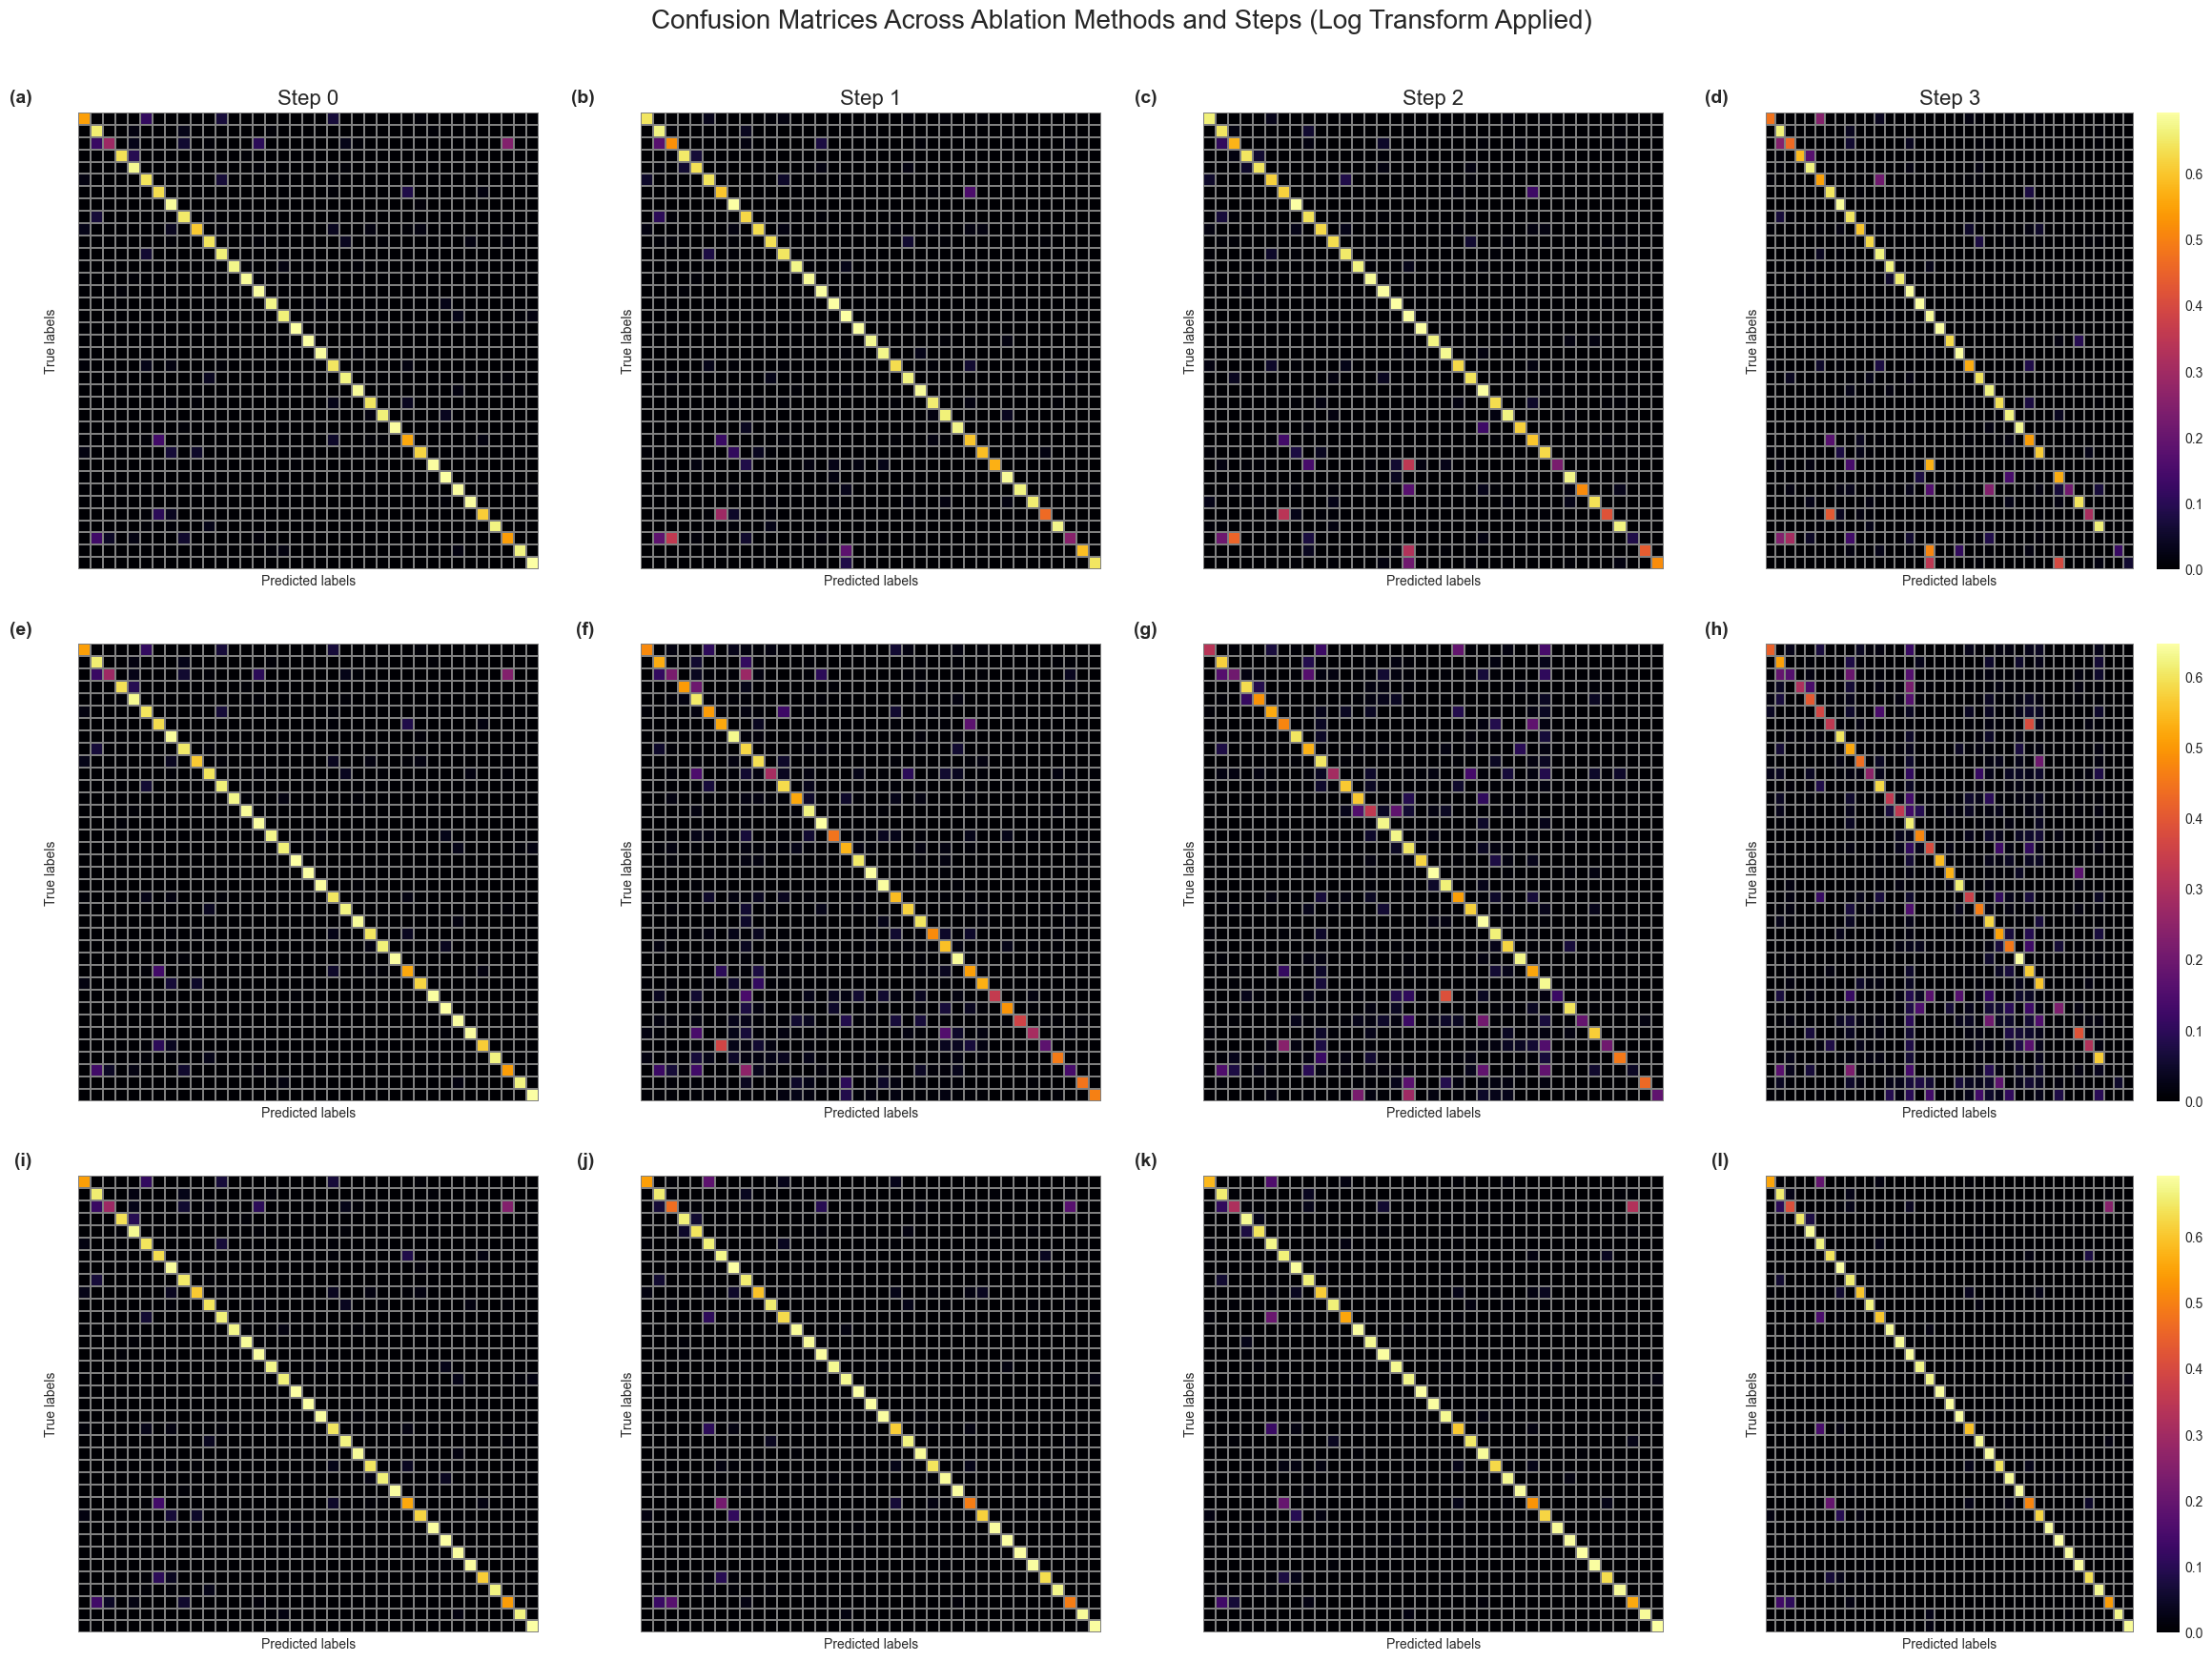

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 加载真实标签
true_labels_path = "/nvme/szh/code/tta-mr/data/pet-37/gen/test_label.npy"
true_labels = np.load(true_labels_path)

# 定义预测文件路径和方法
methods = ["restore", "tta_only", "contra_tta"]
steps = [0, 1, 2, 3]  # 包括 step_0
labels_order = list(range(37))  # 标签类别顺序（0 到 36）

# 设置绘图风格
plt.style.use("seaborn-white")

# 创建一个3x4的大画布
fig, axes = plt.subplots(len(methods), len(steps), figsize=(24, 18))

# 方法的友好名称映射
method_names = {
    "restore": "Only Restoration",
    "tta_only": "Only Adaptation",
    "contra_tta": "Restoration + Adaptation",
}

# 子图编号的初始值
subplot_idx = 0

# 遍历每个方法和步骤
for method_idx, method in enumerate(methods):
    for step_idx, step in enumerate(steps):
        # 加载预测标签
        if step == 0:
            # step_0 的文件名和路径固定
            predictions_path = (
                "./predictions_pet37_ablation/contra_step_0_predictions.npy"
            )
        else:
            predictions_path = (
                f"./predictions_pet37_ablation/{method}_step_{step}_predictions.npy"
            )

        try:
            predicted_labels = np.load(predictions_path)
        except FileNotFoundError:
            print(f"File not found: {predictions_path}, skipping...")
            continue

        # 计算混淆矩阵（归一化到真实标签上）
        cm = confusion_matrix(
            true_labels, predicted_labels, labels=labels_order, normalize="true"
        )

        # 对混淆矩阵进行对数变换，使得小数值更加显著
        cm_log = np.log1p(cm)  # 使用 log(1 + x) 避免 log(0)

        # 在对应的子图上绘制混淆矩阵
        ax = axes[method_idx, step_idx]
        sns.heatmap(
            cm_log,
            annot=False,
            cmap="inferno",  # 使用高对比度的颜色图
            xticklabels=labels_order,
            yticklabels=labels_order,
            ax=ax,
            cbar=(step_idx == len(steps) - 1),  # 最后一列添加颜色条
            linewidths=0.1,
            linecolor="gray",
        )

        # 设置标题、标签
        if step_idx == 0:
            ax.set_ylabel(f"{method_names[method]}", fontsize=16, labelpad=15)
        if method_idx == 0:
            ax.set_title(f"Step {step}", fontsize=16)
        ax.set_xlabel("Predicted labels", fontsize=10)
        ax.set_ylabel("True labels", fontsize=10)

        # 添加子图编号
        subplot_idx += 1
        ax.text(
            -0.1,
            1.05,
            f"({chr(96 + subplot_idx)})",
            transform=ax.transAxes,
            fontsize=14,
            fontweight="bold",
            va="top",
            ha="right",
        )

        # 取消 x 和 y 的刻度，以减少杂乱
        ax.set_xticks([])
        ax.set_yticks([])

# 调整整体布局
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.92)
fig.suptitle(
    "Confusion Matrices Across Ablation Methods and Steps (Log Transform Applied)",
    fontsize=20,
)

# 显示结果
plt.show()

/tmp/ipykernel_116696/2336562829.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


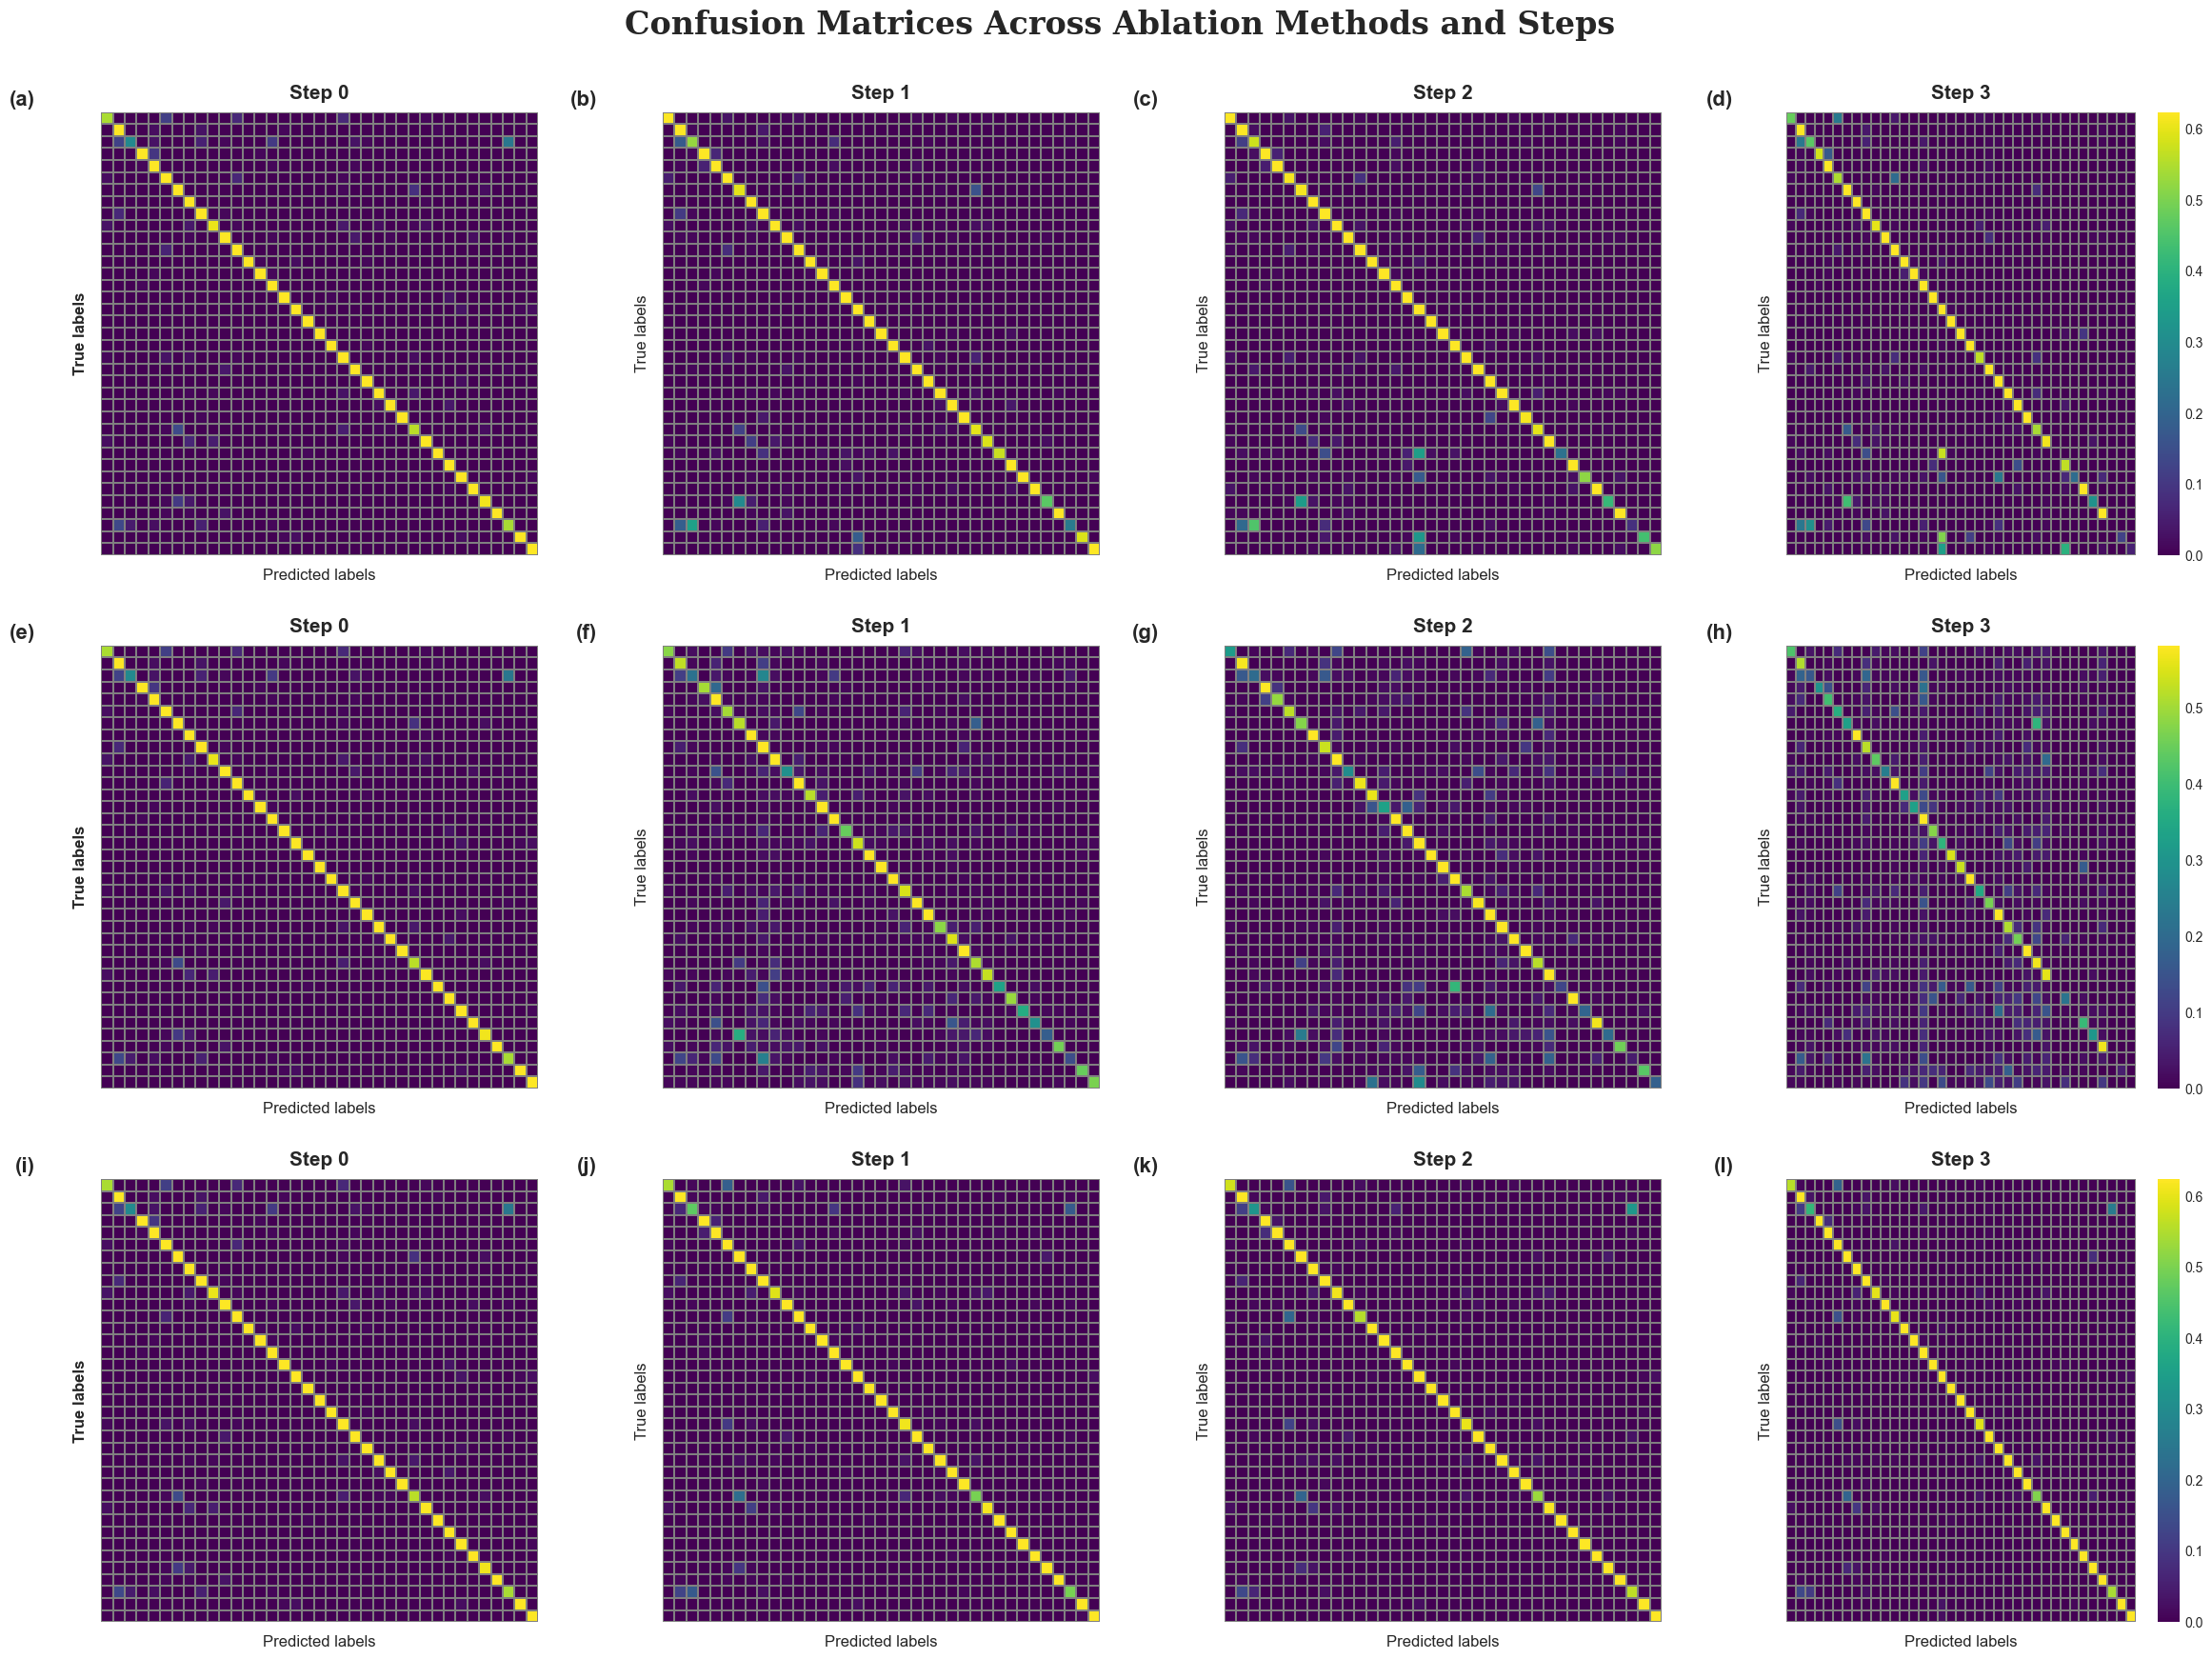

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 加载真实标签
true_labels_path = "/nvme/szh/code/tta-mr/data/pet-37/gen/test_label.npy"
true_labels = np.load(true_labels_path)

# 定义预测文件路径和方法
methods = ["restore", "tta_only", "contra_tta"]
steps = [0, 1, 2, 3]  # 包括 step_0
labels_order = list(range(37))  # 标签类别顺序（0 到 36）

# 设置绘图风格
plt.style.use("seaborn-white")

# 创建一个3x4的大画布
fig, axes = plt.subplots(len(methods), len(steps), figsize=(24, 18))

# 方法的友好名称映射
method_names = {
    "restore": "Only Restoration",
    "tta_only": "Only Adaptation",
    "contra_tta": "Restoration + Adaptation",
}

# 子图编号的初始值
subplot_idx = 0

# 遍历每个方法和步骤
for method_idx, method in enumerate(methods):
    for step_idx, step in enumerate(steps):
        # 加载预测标签
        if step == 0:
            # step_0 的文件名和路径固定
            predictions_path = (
                "./predictions_pet37_ablation/contra_step_0_predictions.npy"
            )
        else:
            predictions_path = (
                f"./predictions_pet37_ablation/{method}_step_{step}_predictions.npy"
            )

        try:
            predicted_labels = np.load(predictions_path)
        except FileNotFoundError:
            print(f"File not found: {predictions_path}, skipping...")
            continue

        # 计算混淆矩阵（归一化到真实标签上）
        cm = confusion_matrix(
            true_labels, predicted_labels, labels=labels_order, normalize="true"
        )

        # 对混淆矩阵进行对数变换，使得小数值更加显著
        cm_log = np.log1p(cm)  # 使用 log(1 + x) 避免 log(0)

        # 在对应的子图上绘制混淆矩阵
        ax = axes[method_idx, step_idx]
        sns.heatmap(
            cm_log,
            annot=False,
            cmap="viridis",  # 使用对比度更高的 "viridis" 颜色图
            xticklabels=labels_order,
            yticklabels=labels_order,
            ax=ax,
            cbar=(step_idx == len(steps) - 1),  # 最后一列添加颜色条
            linewidths=0.3,
            linecolor="gray",
            vmin=0,
            vmax=np.max(cm_log) * 0.9,  # 调整颜色条的范围以增强对比度
        )

        # 设置标题、标签和字体
        ax.set_title(f"Step {step}", fontsize=15, fontweight="bold", pad=10)
        if step_idx == 0:
            ax.set_ylabel(
                f"{method_names[method]}", fontsize=15, fontweight="bold", labelpad=15
            )
        ax.set_xlabel("Predicted labels", fontsize=12, labelpad=10)
        ax.set_ylabel("True labels", fontsize=12, labelpad=10)

        # 添加子图编号
        subplot_idx += 1
        ax.text(
            -0.15,
            1.05,
            f"({chr(96 + subplot_idx)})",
            transform=ax.transAxes,
            fontsize=16,
            fontweight="bold",
            va="top",
            ha="right",
        )

        # 取消 x 和 y 的刻度以减少杂乱
        ax.set_xticks([])
        ax.set_yticks([])

# 调整整体布局
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.92)
fig.suptitle(
    "Confusion Matrices Across Ablation Methods and Steps",
    fontsize=24,
    fontweight="bold",
    fontfamily="serif",
)

# 显示结果
plt.show()

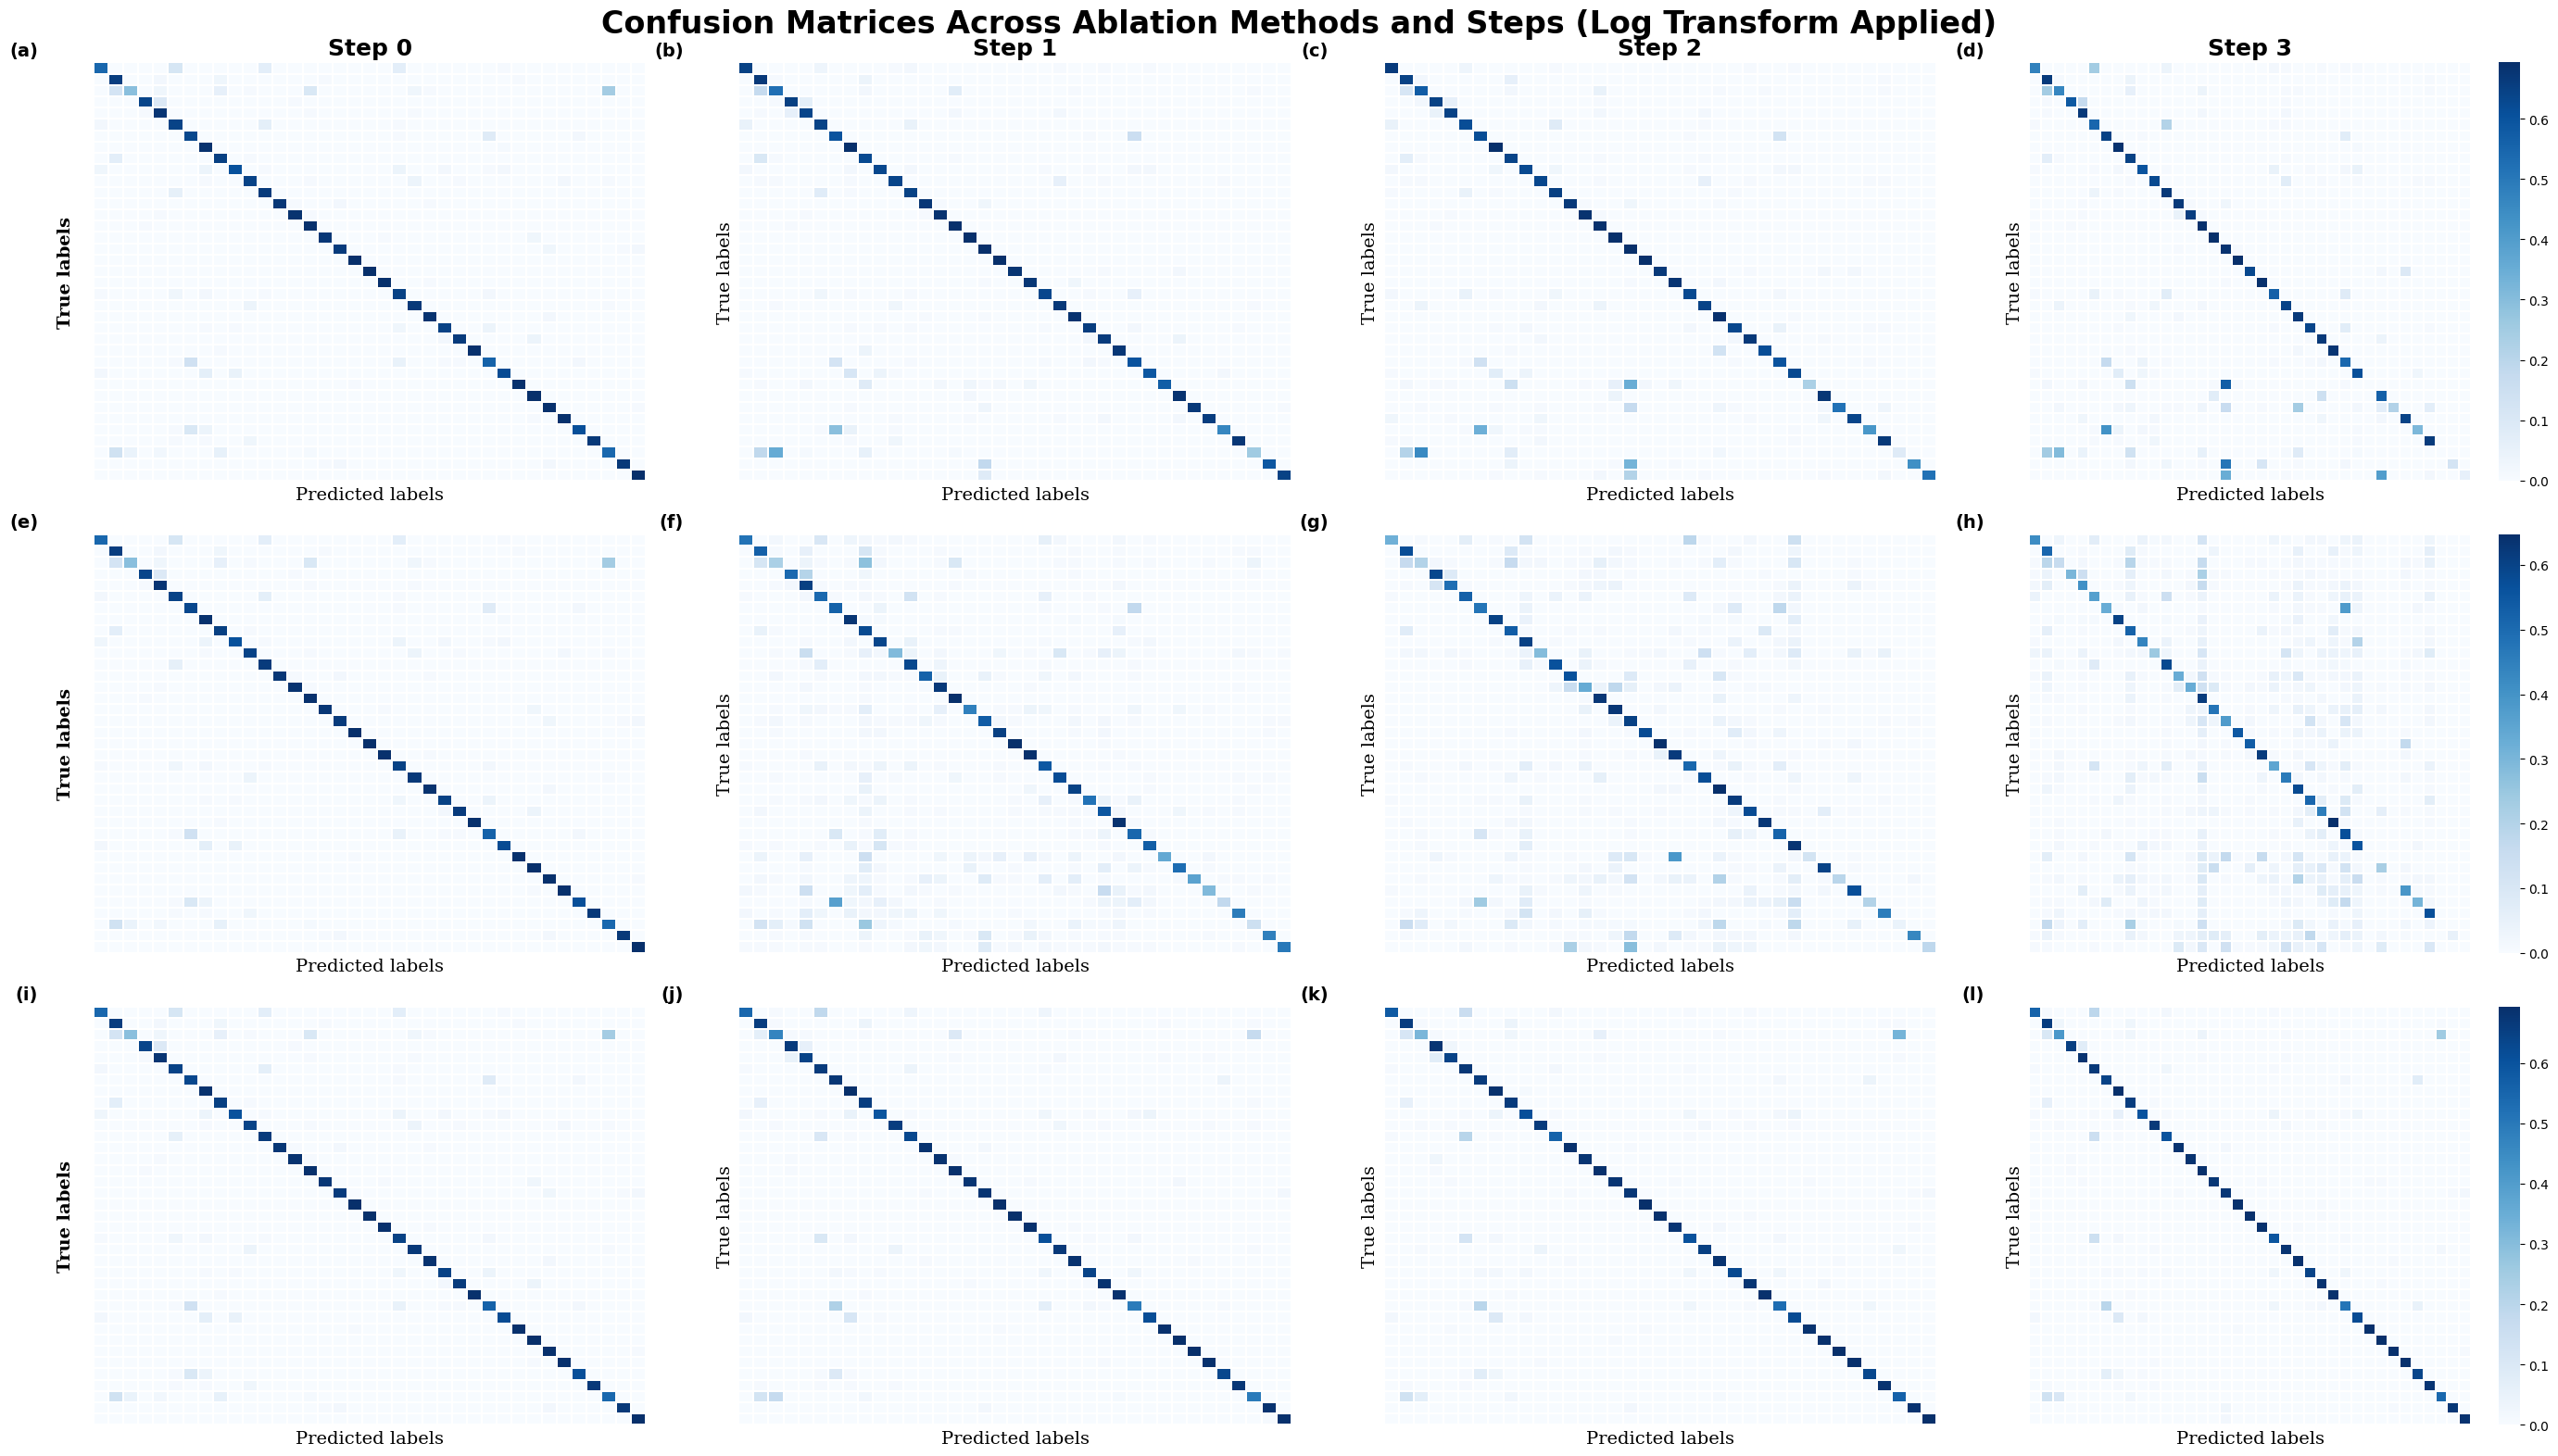

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 加载真实标签
true_labels_path = "/nvme/szh/code/tta-mr/data/pet-37/gen/test_label.npy"
true_labels = np.load(true_labels_path)

# 定义预测文件路径和方法
methods = ["restore", "tta_only", "contra_tta"]
steps = [0, 1, 2, 3]  # 包括 step_0
labels_order = list(range(37))  # 标签类别顺序（0 到 36）

# 方法的友好名称映射
method_names = {
    "restore": "Only Restoration",
    "tta_only": "Only Adaptation",
    "contra_tta": "Restoration + Adaptation",
}

# 设置绘图风格
plt.style.use("default")

# 创建一个3x4的大画布
fig, axes = plt.subplots(len(methods), len(steps), figsize=(28, 16))

# 设置标题字体大小
title_fs = 18
label_fs = 14

# 子图编号的初始值
subplot_idx = 0

# 遍历每个方法和步骤
for method_idx, method in enumerate(methods):
    for step_idx, step in enumerate(steps):
        # 加载预测标签
        if step == 0:
            # step_0 的文件名和路径固定
            predictions_path = (
                "./predictions_pet37_ablation/contra_step_0_predictions.npy"
            )
        else:
            predictions_path = (
                f"./predictions_pet37_ablation/{method}_step_{step}_predictions.npy"
            )

        try:
            predicted_labels = np.load(predictions_path)
        except FileNotFoundError:
            print(f"File not found: {predictions_path}, skipping...")
            continue

        # 计算混淆矩阵（归一化到真实标签上）
        cm = confusion_matrix(
            true_labels, predicted_labels, labels=labels_order, normalize="true"
        )

        # 对混淆矩阵进行对数变换，使得小数值更加显著
        cm_log = np.log1p(cm)  # 使用 log(1 + x) 避免 log(0)

        # 在对应的子图上绘制混淆矩阵
        ax = axes[method_idx, step_idx]
        sns.heatmap(
            cm_log,
            annot=False,
            cmap="Blues",  # 使用较为柔和的颜色图
            xticklabels=labels_order,
            yticklabels=labels_order,
            ax=ax,
            cbar=(step_idx == len(steps) - 1),  # 最后一列添加颜色条
            linewidths=0.3,
            linecolor="white",
        )

        # 设置标题、标签
        if step_idx == 0:
            ax.set_ylabel(
                f"{method_names[method]}",
                fontsize=title_fs,
                labelpad=15,
                fontfamily="serif",
                weight="bold",
            )
        if method_idx == 0:
            ax.set_title(f"Step {step}", fontsize=title_fs, fontweight="bold")

        ax.set_xlabel("Predicted labels", fontsize=label_fs, fontfamily="serif")
        ax.set_ylabel("True labels", fontsize=label_fs, fontfamily="serif")

        # 添加子图编号
        subplot_idx += 1
        ax.text(
            -0.1,
            1.05,
            f"({chr(96 + subplot_idx)})",
            transform=ax.transAxes,
            fontsize=label_fs,
            fontweight="bold",
            va="top",
            ha="right",
        )

        # 去掉x和y轴刻度，减少杂乱
        ax.set_xticks([])
        ax.set_yticks([])

# 调整整体布局
plt.subplots_adjust(
    left=0.05, right=0.95, top=0.93, bottom=0.05, wspace=0.25, hspace=0.3
)
fig.suptitle(
    "Confusion Matrices Across Ablation Methods and Steps (Log Transform Applied)",
    fontsize=24,
    fontweight="bold",
)
plt.tight_layout()

# 显示结果
plt.show()

/tmp/ipykernel_147780/900673951.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


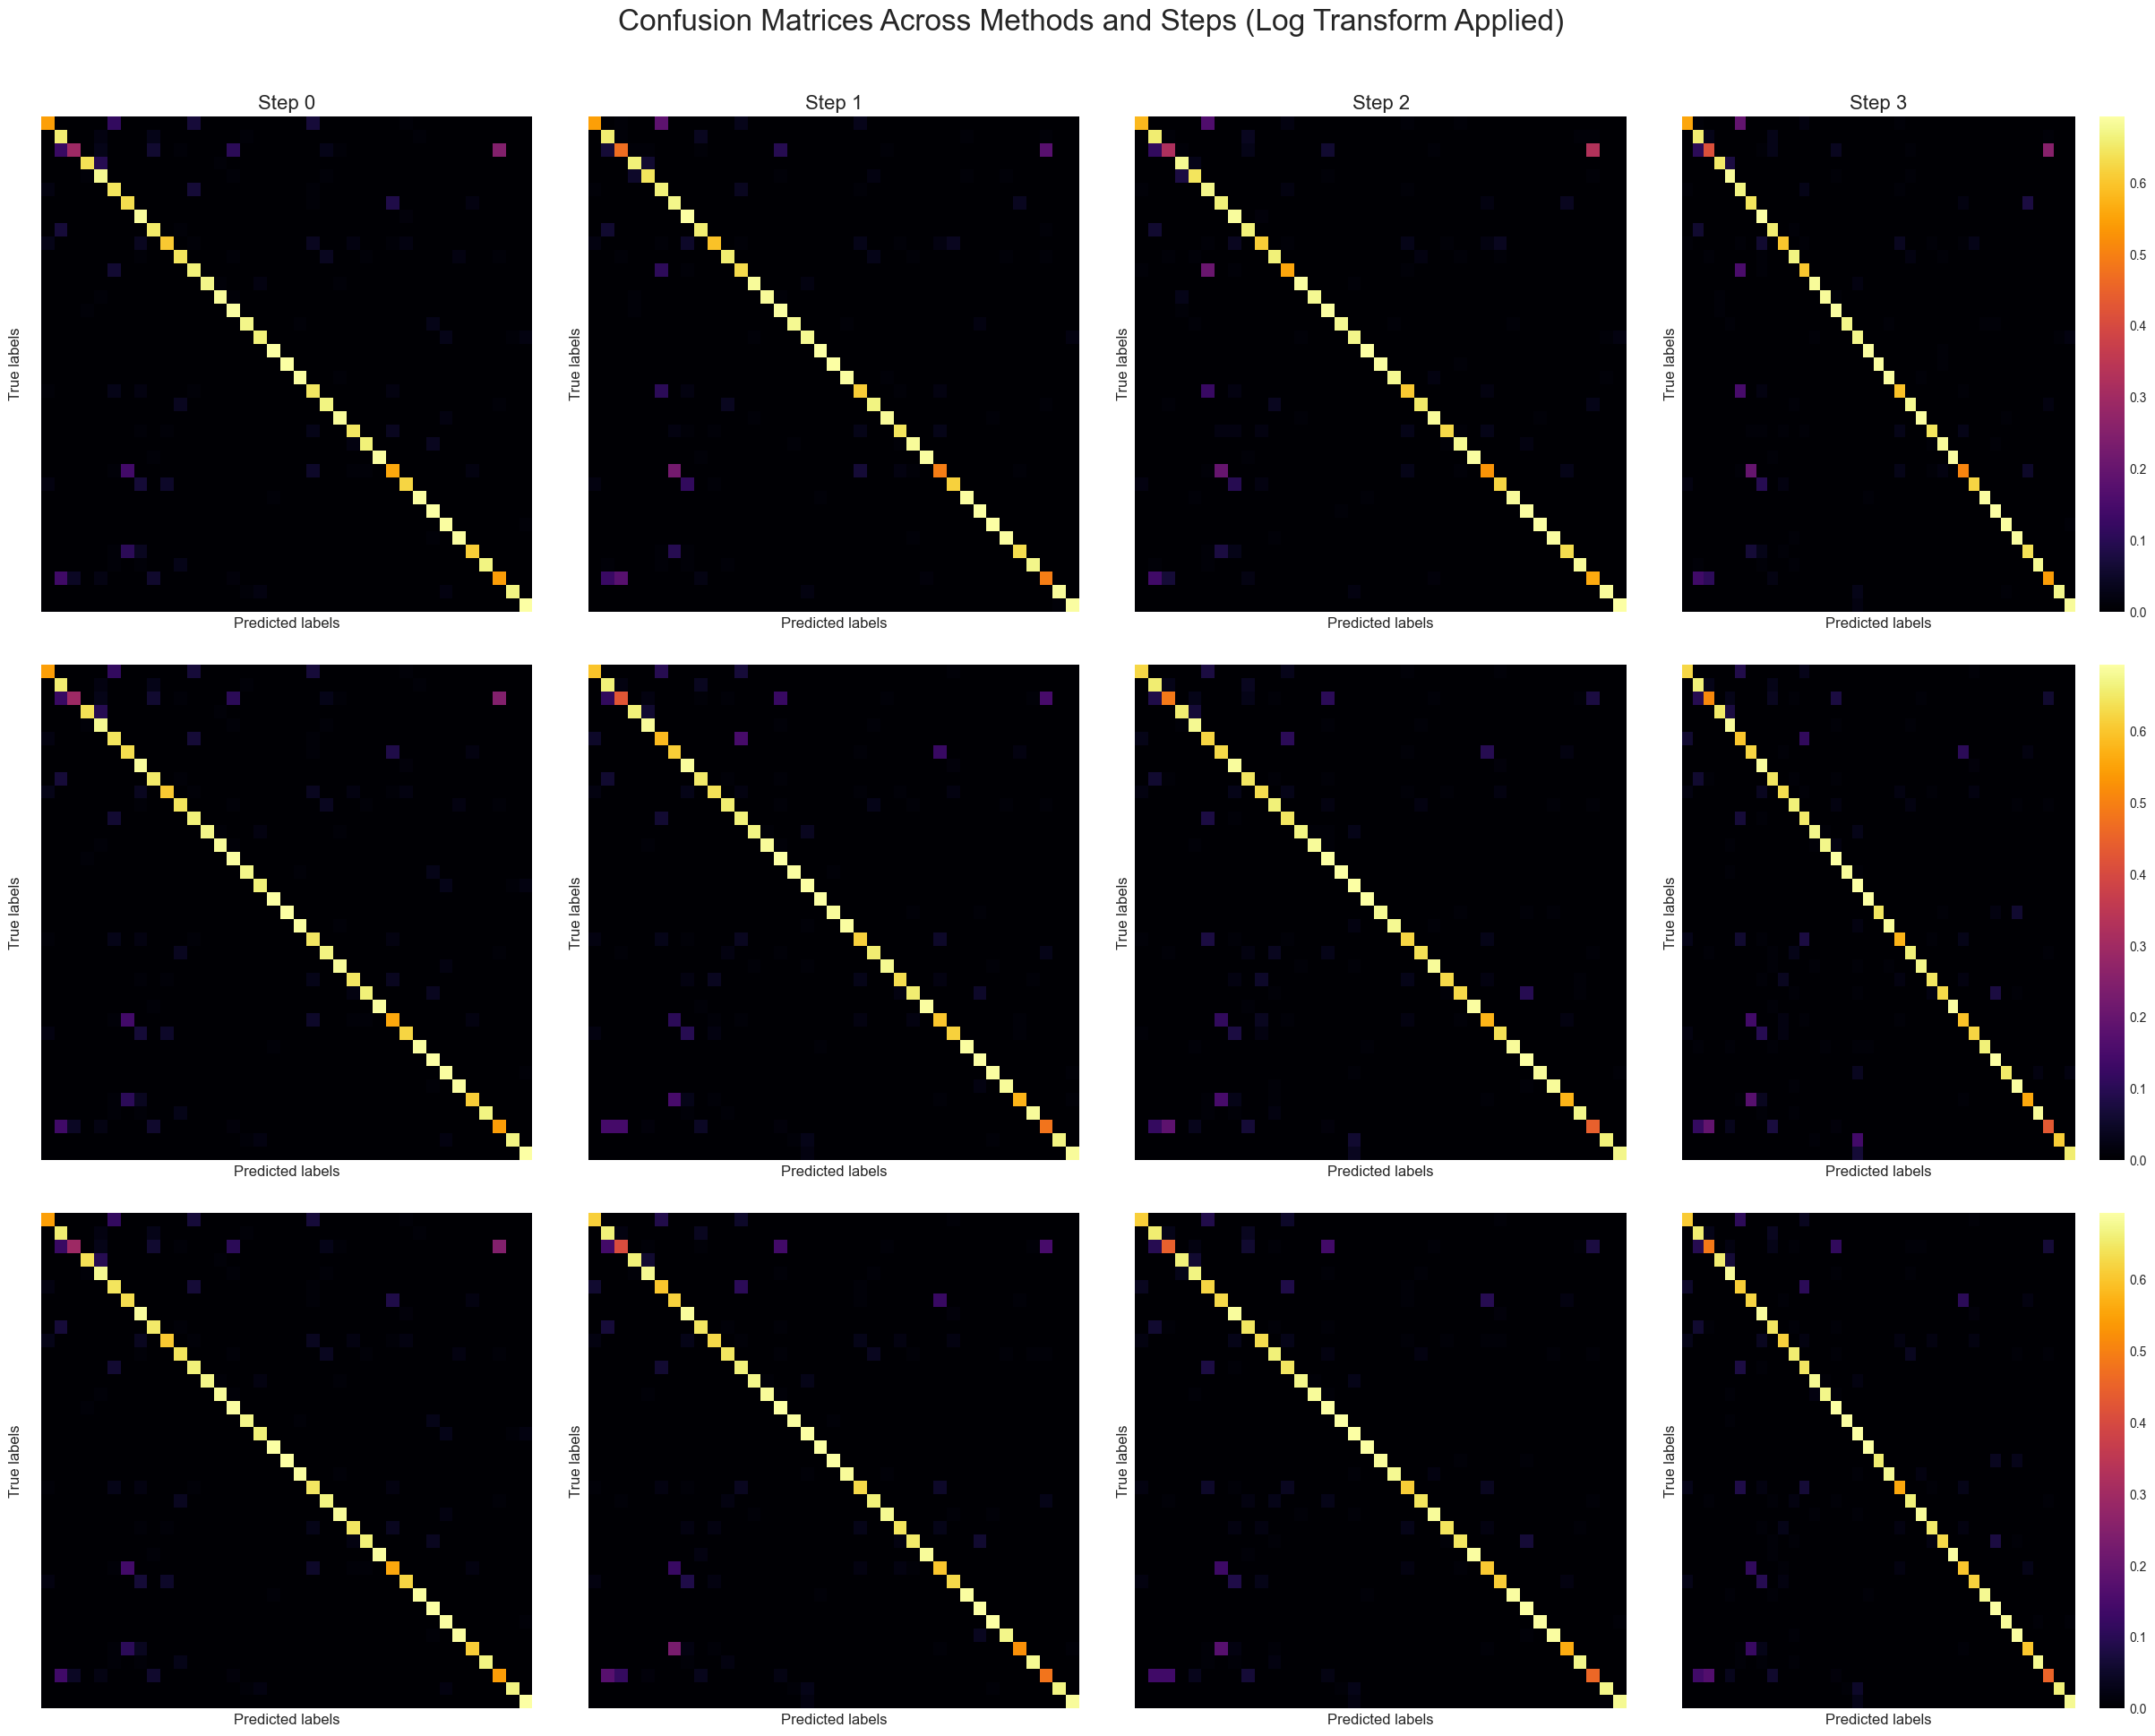

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 加载真实标签
true_labels_path = "/nvme/szh/code/tta-mr/data/pet-37/gen/test_label.npy"
true_labels = np.load(true_labels_path)

# 定义预测文件路径和方法
methods = ["contra", "Coteaching", "JoCoR"]
steps = [0, 1, 2, 3]
labels_order = list(range(37))  # 标签类别顺序（0 到 36）

# 设置绘图风格
plt.style.use("seaborn-white")

# 创建一个大画布
fig, axes = plt.subplots(len(methods), len(steps), figsize=(25, 20))

# 遍历每个方法和步骤
for method_idx, method in enumerate(methods):
    for step_idx, step in enumerate(steps):
        # 加载预测标签
        predictions_path = f"predictions_pet37/{method}_step_{step}_predictions.npy"
        predicted_labels = np.load(predictions_path)

        # 计算混淆矩阵（归一化到真实标签上）
        cm = confusion_matrix(
            true_labels, predicted_labels, labels=labels_order, normalize="true"
        )

        # 对混淆矩阵进行对数变换，使得小数值更加显著
        cm_log = np.log1p(cm)  # 使用 log(1 + x) 避免 log(0)

        # 在对应的子图上绘制混淆矩阵
        ax = axes[method_idx, step_idx]
        sns.heatmap(
            cm_log,
            annot=False,
            cmap="inferno",  # 使用高对比度的颜色图
            xticklabels=labels_order,
            yticklabels=labels_order,
            ax=ax,
            cbar=(step_idx == len(steps) - 1),  # 最后一列添加颜色条
        )

        # 设置标题、标签
        if step_idx == 0:
            ax.set_ylabel(f"{method}", fontsize=16, labelpad=15)
        if method_idx == 0:
            ax.set_title(f"Step {step}", fontsize=16)
        ax.set_xlabel("Predicted labels", fontsize=12)
        ax.set_ylabel("True labels", fontsize=12)

        # 取消 x 和 y 的刻度，以减少杂乱
        ax.set_xticks([])
        ax.set_yticks([])

# 调整整体布局
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.92)
fig.suptitle(
    "Confusion Matrices Across Methods and Steps (Log Transform Applied)", fontsize=24
)

# 显示结果
plt.show()

# ICDE


执行环境导入

检索任务

## ICDE_Task: Cifar-100 检索

> 计算 mAP（test_acc 仅供参考）


In [10]:
import warnings
warnings.filterwarnings("ignore")

import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from core_model.custom_model import ClassifierWrapper, load_custom_model
from configs import settings
import logging

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 设置日志输出格式
logging.basicConfig(
    level=logging.INFO,
    format="\033[1;36m%(asctime)s - %(levelname)s - %(message)s\033[0m",
)
logger = logging.getLogger(__name__)

def get_test_acc(test_loader, model, device):
    """
    计算模型在测试集上的准确率。
    """
    criterion = nn.CrossEntropyLoss()
    model.eval().to(device)
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        with tqdm(total=len(test_loader), desc="Testing") as pbar:
            for test_inputs, test_targets in test_loader:
                test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)
                test_outputs = model(test_inputs)
                loss = criterion(test_outputs, test_targets)
                _, predicted_test = torch.max(test_outputs, 1)
                total_test += test_targets.size(0)
                correct_test += (predicted_test == test_targets).sum().item()

                # 更新进度条
                pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
                pbar.update(1)

    test_accuracy = 100 * correct_test / total_test
    return test_accuracy

class BaseTensorDataset(Dataset):
    def __init__(self, data, labels, transforms=None, device=None):
        self.data = torch.as_tensor(data, device=device)
        self.labels = torch.as_tensor(labels, device=device)
        self.transforms = transforms
        logger.info(f"Dataset initialized with data shape: {data.shape} and labels shape: {labels.shape}")

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        if self.transforms is not None:
            self.transforms(data)
        return data, self.labels[index]

def get_model_path(dataset_name, model_name, method, noise_ratio, noise_type="asymmetric"):
    """
    根据数据集名称、模型名称、方法、噪声比例和类型生成模型路径。
    """
    mission_type = "symmetric" if noise_type == "symmetric" else "asymmetric"
    base_ckpt_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_{noise_ratio}_nt_{mission_type}_cvpr"

    # 根据不同的方法选择不同的路径
    if method == "pretrain":
        path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/pretrain/{model_name}_pretrain.pth"
    elif method == "inc_train":
        path = os.path.join(base_ckpt_path, f"{model_name}_inc_train.pth")
    else:
        path = os.path.join(base_ckpt_path, method, f"{model_name}_restore.pth")

    if not os.path.exists(path):
        logger.warning(f"Expected file at {path} not found.")
    return path

def eva_test_acc(dataset_name, model_name, noise_type="asymmetric", noise_ratio=0.5, methods=None, results_dir=None, device="cuda"):
    """
    评估指定数据集和方法的测试准确率。
    """
    assert methods is not None, "请指定要评估的方法。"
    assert results_dir is not None, "请指定保存结果的目录。"
    os.makedirs(results_dir, exist_ok=True)

    num_classes = settings.num_classes_dict[dataset_name]
    logger.info(f"Currently testing dataset: {dataset_name} with {num_classes} classes.")

    # 加载测试数据集
    batch_size = 64
    test_data_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_data.npy"
    test_label_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_label.npy"

    try:
        logger.info(f"Loading test data from: {test_data_path}")
        test_data = np.load(test_data_path)
        test_labels = np.load(test_label_path)
        logger.info(f"Test data loaded with shape: {test_data.shape}, Test labels loaded with shape: {test_labels.shape}")
        test_dataset = BaseTensorDataset(test_data, test_labels, device=device)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    except FileNotFoundError as e:
        logger.error(f"Error loading test dataset: {e}")
        return

    # 初始化结果 DataFrame
    df = pd.DataFrame(index=["accuracy"], columns=methods)

    for method in methods:
        # 跳过 finetune 方法
        if method == "finetune":
            continue

        model_path = get_model_path(dataset_name, model_name, method, noise_ratio, noise_type)
        logger.info(f"Evaluating model from path: {model_path}")

        # 加载模型结构和权重
        model = load_custom_model(model_name, num_classes, load_pretrained=False)
        model = ClassifierWrapper(model, num_classes)
        try:
            checkpoint = torch.load(model_path, map_location=device)
            logger.info(f"Loaded model checkpoint from {model_path}")
        except FileNotFoundError:
            logger.error(f"Cannot find the weight file at {model_path}. Skipping.")
            continue
        model.load_state_dict(checkpoint, strict=False)

        # 评估模型
        logger.info(f"Starting evaluation for method: {method}")
        test_acc = get_test_acc(test_dataloader, model, device)
        logger.info(f"Test Accuracy for {method}: {test_acc:.2f}%")
        df.loc["accuracy", method] = test_acc

    # 保存结果到 CSV
    mission_type = "sym" if noise_type == "symmetric" else "asym"
    results_file_name = f"{dataset_name}_nr{noise_ratio}_{mission_type}.csv"
    results_file_dir = os.path.join(results_dir, results_file_name)
    df.to_csv(results_file_dir)
    logger.info(f"Results saved to {results_file_dir}")

# # 示例用法
# if __name__ == "__main__":
#     dataset_name = "cifar-100"
#     model_name = "efficientnet_s"
#     noise_types = ["asymmetric"]
#     noise_ratios = [0.1, 0.25, 0.5, 0.75, 0.9]
#     methods = [
#         "pretrain",
#         "inc_train",
#         # LNL方法
#         "Coteaching",
#         "Coteachingplus",
#         "JoCoR",
#         "Decoupling",
#         "NegativeLearning",
#         "PENCIL",
#         # MU 方法
#         "GA",
#         "GA_l1",
#         "FT",
#         "wfisher",
#         "FT_prune",
#         "retrain",
#         "CRUL",
#     ]
#     results_dir = "./results_cvpr/main"

#     for noise_type in noise_types:
#         for noise_ratio in noise_ratios:
#             eva_test_acc(
#                 dataset_name,
#                 model_name,
#                 noise_type,
#                 noise_ratio,
#                 methods=methods,
#                 results_dir=results_dir,
#             )


In [11]:
dataset_name = "cifar-100"
model_name = "cifar-wideresnet40"
noise_type = "asymmetric"

# ------------------------------------------------------------- #
"""
实验区：手动指定要评估的组
methods: ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'cotta', 'plf', 'contra']
steps: [0, 1, 2, 3]
"""
# methods = ['contra']
# methods = ['raw']
# methods = ['cotta']
# methods = ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'cotta', 'plf', 'contra']
# methods = ['raw', 'replay', 'Coteaching', 'Coteachingplus', 'JoCoR', 'cotta', 'plf', 'contra']
# methods = ['raw', 'replay', 'Coteaching', 'JoCoR', 'cotta', 'contra']

methods = ["cotta", "plf"]
# methods = ['replay', 'contra']
steps = [i for i in range(4)]
# steps = [3]
# ------------------------------------------------------------- #
"""
指定结果存储的路径
"""
results_dir = "./results_main"
# ------------------------------------------------------------- #
eva_test_acc(
    dataset_name,
    model_name,
    noise_type,
    methods=methods,
    steps=steps,
    results_dir=results_dir,
)

# eva_map(dataset_name, model_name, noise_type,
#         methods=methods, steps=steps, results_dir=results_dir,
#         top_k=30)

TypeError: eva_test_acc() got an unexpected keyword argument 'steps'

> 图片检索


In [12]:
dataset_name = "cifar-100"
model_name = "cifar-wideresnet40"
noise_type = "asymmetric"

# ------------------------------------------------------------- #
"""
实验区：手动指定要评估的组
methods: ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'cotta', 'plf', 'contra']
steps: [0, 1, 2, 3]
"""

# methods = ['raw']
# methods = ['Coteaching']
# methods = ['JoCoR']
methods = ["contra"]

# methods = ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'cotta', 'plf', 'contra']
# methods = ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'contra']
# steps = [i for i in range(4)]
steps = [3]
# ------------------------------------------------------------- #

"""
检索用参数
"""
top_k = 5
query_indices = [333]
# ------------------------------------------------------------- #
# eva_retrieval(dataset_name, model_name, noise_type,
#               methods=methods, steps=steps,
#               top_k=top_k, query_indices=query_indices)

# 已经测试过一次的时候，用这个：
eva_retrieval(
    dataset_name,
    model_name,
    noise_type,
    methods=methods,
    steps=steps,
    top_k=top_k,
    query_indices=query_indices,
    use_cache=True,
)

# 322-flatfish
# 333， 334


# for i in range(331, 340):
#     query_indices = [i]
#     eva_retrieval(dataset_name, model_name, noise_type,
#                 methods=methods, steps=steps,
#                 top_k=top_k, query_indices=query_indices,
#                 use_cache=True)

TypeError: get_case() got an unexpected keyword argument 'balanced'

## ICDE_Task: Pet-37 检索

> 计算 mAP（test_acc 仅供参考）


In [13]:
dataset_name = "pet-37"
model_name = "wideresnet50"
noise_type = "asymmetric"

# ------------------------------------------------------------- #
"""
实验区：手动指定要评估的组
methods: ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'cotta', 'plf', 'contra']
steps: [0, 1, 2, 3]
"""
# methods = ["contra"]
# methods = ['raw']
# methods = ['raw', 'replay', 'Coteaching', 'Coteachingplus', 'JoCoR', 'cotta', 'plf', 'contra']
methods = ["raw", "replay", "Coteaching", "Coteachingplus", "JoCoR", "contra"]
# methods = ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'contra']
steps = [i for i in range(4)]
# steps = [0]
# ------------------------------------------------------------- #
"""
指定结果存储的路径
"""
results_dir = "./results_main"
# ------------------------------------------------------------- #
# eva_test_acc(dataset_name, model_name, noise_type,
#              methods=methods, steps=steps, results_dir=results_dir)
eva_map(
    dataset_name,
    model_name,
    noise_type,
    methods=methods,
    steps=steps,
    results_dir=results_dir,
)

TypeError: get_case() got an unexpected keyword argument 'balanced'

> 图片检索


In [14]:
dataset_name = "pet-37"
model_name = "wideresnet50"
noise_type = "asymmetric"

# ------------------------------------------------------------- #
"""
实验区：手动指定要评估的组
methods: ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'cotta', 'plf', 'contra']
steps: [0, 1, 2, 3]
"""
methods = ["contra"]
# methods = ['raw']
# methods = ['Coteaching']
# methods = ['JoCoR']
# methods = ['cotta']
# methods = ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'cotta', 'plf', 'contra']
# methods = ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'contra']
# steps = [i for i in range(4)]
steps = [3]
# ------------------------------------------------------------- #
"""
检索用参数
"""
top_k = 5
# query_indices = [3102] # Shiba Inu
# query_indices = [3102]


# query_indices = [2321] # Perisian
# query_indices = [444] # 币哥
# query_indices = [303] #

query_indices = [321]

# ------------------------------------------------------------- #
# eva_retrieval(dataset_name, model_name, noise_type,
#               methods=methods, steps=steps,
#               top_k=top_k, query_indices=query_indices)

# 已经计算过一次分数的时候，用这个：
eva_retrieval(
    dataset_name,
    model_name,
    noise_type,
    methods=methods,
    steps=steps,
    top_k=top_k,
    query_indices=query_indices,
    use_cache=True,
)


# # 303、304
# for i in range(321, 330):
#     query_indices = [i]
#     eva_retrieval(dataset_name, model_name, noise_type,
#                 methods=methods, steps=steps,
#                 top_k=top_k, query_indices=query_indices,
#                 use_cache=True)

TypeError: get_case() got an unexpected keyword argument 'balanced'

# CVPR-检索测试

## 原始的测试代码(from-ly)

In [ ]:
# 测试命令
# python ./result_analysis/evaluate_icde.py --dataset cifar-10 --model cifar-resnet18 --noise_ratio 0.25 --uni_name Coteaching --model_suffix restore



import warnings

warnings.filterwarnings("ignore")
import argparse
from args_paser import parse_args
import os
import sys

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from configs import settings
import logging
from configs import settings
from core_model.custom_model import ClassifierWrapper, load_custom_model
from core_model.dataset import get_dataset_loader
from core_model.train_test import model_forward
from core_model.dataset import BaseTensorDataset
from sklearn.metrics.pairwise import cosine_similarity

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def load_dataset(file_path, is_data=True):
    """
    加载数据集文件并返回 PyTorch 张量。
    :param subdir: 数据目录
    :param dataset_name: 数据集名称 (cifar-10, cifar-100, food-101, pet-37, flower-102)
    :param file_name: 数据文件名
    :param is_data: 是否为数据文件（True 表示数据文件，False 表示标签文件）
    :return: PyTorch 张量格式的数据
    """
    data = np.load(file_path)

    if is_data:
        # 对于数据文件，转换为 float32 类型
        data_tensor = torch.tensor(data, dtype=torch.float32)
    else:
        # 对于标签文件，转换为 long 类型
        data_tensor = torch.tensor(data, dtype=torch.long)

    return data_tensor


# def search(target_embeddings,query_embeddings,target_true_labels,target_labels,test_labels,k=5):
#     results=[]
#     i=0
#     for query in query_embeddings:
#         similarities=cosine_similarity([query],target_embeddings)[0]
#         top_k_indices=np.argsort(similarities)[-k:][::-1]
#         top_k_similarities=[(index,similarities[index],target_labels[index],target_true_labels[index])for index in top_k_indices]
#         top_k_similarities.insert(0,test_labels[i])
#         results.append(top_k_similarities)
#         i=i+1
#     # print(results[0])
#     print(len(results))#10000
#     print(len(results[0]))
#     print("search finish")
#     return results


def search(
    target_embeddings,
    query_embeddings,
    target_true_labels,
    target_labels,
    test_labels,
    k=5,
):
    results = []
    target_embeddings = torch.tensor(target_embeddings, dtype=torch.float64).to(device)
    query_embeddings = torch.tensor(query_embeddings, dtype=torch.float64).to(device)

    for i, query in enumerate(query_embeddings):
        distances = (
            torch.sqrt(torch.sum((target_embeddings - query) ** 2, dim=1)).cpu().numpy()
        )

        top_k_indices = np.argsort(distances)[:k]
        top_k_distances = [
            (index, distances[index], target_labels[index], target_true_labels[index])
            for index in top_k_indices
        ]

        top_k_distances.insert(0, test_labels[i])
        results.append(top_k_distances)

    print(len(results))  # 10000
    print(len(results[0]))
    print("search finish")
    return results


def recall_k(results, target_true_labels, counter, k=5):
    total_recall = 0
    for each in results:
        query_label = each[0]
        target_items = each[1:-1]
        temp_recall = 0
        top_k_items = target_items[:k]
        # 目标集中实际正类数量
        sum_target_true = counter[query_label]
        # 前k个预测中正确的正类数量
        sum_predict_true = sum(
            1 for _, _, _, true_label in top_k_items if true_label == query_label
        )
        temp_recall = sum_predict_true / sum_target_true
        total_recall = total_recall + temp_recall

    return total_recall / len(results)


def precision_k(results, k):
    total_precision = 0
    for each in results:
        query_label = each[0]
        target_items = each[1:-1]
        temp_precision = 0
        top_k_items = target_items[:k]
        sum_true = k
        # 前k个预测中正确的正类数量
        sum_predict_true = sum(
            1 for _, _, _, true_label in top_k_items if true_label == query_label
        )
        temp_precision = sum_predict_true / sum_true
        total_precision = total_precision + temp_precision

    return total_precision / len(results)


# def map_k(results,target_true_labels,k=50):
#     total_recall=0
#     for each in results:
#         query_label= each[0]
#         target_items=each[1:-1]
#         temp_recall=0
#         top_k_items=target_items[:k]
#         #目标集中实际正类数量
#         sum_target_true=sum(1 for label in target_true_labels if label==query_label)
#         #前k个预测中正确的正类数量
#         sum_predict_true=sum(1 for _,_,_,true_label in top_k_items if true_label==query_label)
#         temp_recall=sum_predict_true/sum_target_true
#         total_recall=total_recall+temp_recall

#     return total_recall/len(results)


def get_metrics(results, target_true_labels):
    # results[0]
    # [3, (1639, 0.9648188, 1, 2), (2193, 0.95367, 0, 3), (2409, 0.94515646, 9, 3), (2195, 0.941772, 3, 3), (2187, 0.934531, 9, 3)]
    # [query的class,(targetset的index，相似度，noisy_label，true_label),...]
    pass


def execute(args):
    case = settings.get_case(args.noise_ratio, args.noise_type)
    uni_names = args.uni_name
    uni_names = [uni_names] if uni_names is None else uni_names.split(",")
    num_classes = settings.num_classes_dict[args.dataset]

    test_data, test_labels, test_loader = get_dataset_loader(
        args.dataset,
        "test",
        None,
        batch_size=args.batch_size,
        shuffle=False,
    )
    # 得到target_data,target_true_labels,target_labels,target_loader

    dataset_name = args.dataset
    batch_size = args.batch_size

    all_data = True
    if all_data:
        train_clean_data = load_dataset(
            settings.get_dataset_path(dataset_name, case, "train_clean_data")
        )

        train_clean_labels = (
            np.load(settings.get_dataset_path(dataset_name, case, "train_clean_label"))
        ).astype(np.int64)

        train_noisy_data = load_dataset(
            settings.get_dataset_path(dataset_name, case, "train_noisy_data")
        )

        train_noisy_true_labels = (
            np.load(
                settings.get_dataset_path(dataset_name, case, "train_noisy_true_label")
            )
        ).astype(np.int64)
        train_noisy_labels = (
            np.load(settings.get_dataset_path(dataset_name, case, "train_noisy_label"))
        ).astype(np.int64)

        train_data = torch.concatenate([train_clean_data, train_noisy_data])
        train_labels = np.concatenate([train_clean_labels, train_noisy_labels])

        target_true_labels = np.concatenate(
            [train_clean_labels, train_noisy_true_labels]
        )
        target_labels = np.concatenate([train_clean_labels, train_noisy_labels])

        target_data = BaseTensorDataset(train_data, train_labels)
        target_loader = DataLoader(target_data, batch_size=batch_size, shuffle=False)
    else:
        train_noisy_data = load_dataset(
            settings.get_dataset_path(dataset_name, case, "train_noisy_data")
        )

        train_noisy_true_labels = (
            np.load(
                settings.get_dataset_path(dataset_name, case, "train_noisy_true_label")
            )
        ).astype(np.int64)
        train_noisy_labels = (
            np.load(settings.get_dataset_path(dataset_name, case, "train_noisy_label"))
        ).astype(np.int64)

        target_true_labels = train_noisy_true_labels
        target_labels = train_noisy_labels

        target_data = BaseTensorDataset(train_noisy_data, train_noisy_labels)
        target_loader = DataLoader(target_data, batch_size=batch_size, shuffle=False)

    loaded_model = load_custom_model(args.model, num_classes, load_pretrained=False)
    model = ClassifierWrapper(loaded_model, num_classes)

    model_ckpt_path = settings.get_ckpt_path(
        args.dataset,
        case,
        args.model,
        model_suffix=args.model_suffix,
        unique_name=uni_names[0],
    )

    print(f"Loading model from {model_ckpt_path}")
    checkpoint = torch.load(model_ckpt_path)
    model.load_state_dict(checkpoint, strict=False)

    _, _, query_embeddings, _ = model_forward(
        test_loader, model, device, output_embedding=True, output_targets=True
    )
    _, _, target_embeddings, _ = model_forward(
        target_loader, model, device, output_embedding=True, output_targets=True
    )

    from collections import Counter

    counter = Counter(target_true_labels)

    result_nums = 10  # 每个查询返回几个结果

    results = search(
        target_embeddings,
        query_embeddings,
        target_true_labels,
        target_labels,
        test_labels,
        result_nums,
    )
    print(results[0])
    print(len(results))
    # [query的label,(targetset的index，相似度，noisy_label，true_label),...]
    print(recall_k(results, target_true_labels, counter))


if __name__ == "__main__":
    try:
        pargs = parse_args()
        execute(pargs)
    except argparse.ArgumentError as e:
        print(f"Error parsing arguments: {e}")

# methods = [ # baseline方法，包括一些预训练，增量训练(raw, 仅在d1上训练) 和基础的baseline
#             # 'pretrain', 'inc_train', 'finetune',
#             #'pretrain', 'inc_train',
#             # LNL方法
#             # 'Coteaching', 'Coteachingplus', 'JoCoR', 'Decoupling', 'NegativeLearning', 'PENCIL',
#             'Coteaching',
#             # MU 方法
#             # 'raw', 'GA', 'GA_l1', 'FT', 'FT_l1', 'fisher_new', 'wfisher', 'FT_prune', 'FT_prune_bi', 'retrain', 'retrain_ls', 'retrain_sam',
#             #'wfisher',
#             # 我们的方法
#             #'CRUL'
#             ]

## 修改的测试代码(from-zh)

In [1]:
!pwd

/nvme/szh/code/tta-mr/result_analysis


In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from configs import settings
import logging
from core_model.custom_model import ClassifierWrapper, load_custom_model
from core_model.dataset import get_dataset_loader, BaseTensorDataset
from core_model.train_test import model_forward

# 设置设备和日志
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

def load_dataset(file_path, is_data=True):
    """
    加载数据或标签，返回相应的Tensor。
    """
    try:
        data = np.load(file_path)
        data_tensor = torch.tensor(data, dtype=torch.float32 if is_data else torch.long)
        return data_tensor
    except FileNotFoundError as e:
        logger.error(f"File not found: {file_path}")
        raise e

def search(target_embeddings, query_embeddings, target_true_labels, target_labels, test_labels, k=5):
    """
    执行Top-k检索并返回结果。
    """
    results = []
    target_embeddings = torch.tensor(target_embeddings, dtype=torch.float64).to(device)
    query_embeddings = torch.tensor(query_embeddings, dtype=torch.float64).to(device)

    for i, query in enumerate(query_embeddings):
        distances = torch.sqrt(torch.sum((target_embeddings - query) ** 2, dim=1)).cpu().numpy()
        top_k_indices = np.argsort(distances)[:k]
        top_k_distances = [
            (index, distances[index], target_labels[index], target_true_labels[index])
            for index in top_k_indices
        ]
        top_k_distances.insert(0, test_labels[i])  # 将查询标签添加到检索结果的第一个位置
        results.append(top_k_distances)

    return results

def recall_k(results, target_true_labels, counter, k=5):
    """
    计算Top-k召回率。
    """
    total_recall = 0
    for each in results:
        query_label = each[0]
        target_items = each[1:]
        sum_target_true = counter[query_label]
        sum_predict_true = sum(1 for _, _, _, true_label in target_items[:k] if true_label == query_label)
        temp_recall = sum_predict_true / sum_target_true
        total_recall += temp_recall
    return total_recall / len(results)

def precision_k(results, k=5):
    """
    计算Top-k精度。
    """
    total_precision = 0
    for each in results:
        query_label = each[0]
        target_items = each[1:]
        sum_true = k
        sum_predict_true = sum(1 for _, _, _, true_label in target_items[:k] if true_label == query_label)
        temp_precision = sum_predict_true / sum_true
        total_precision += temp_precision
    return total_precision / len(results)

def main():
    # 定义测试变量
    dataset = "cifar-10"
    model_name = "efficientnet_s"
    noise_ratio = 0.25
    uni_name = "Coteaching"
    model_suffix = "restore"
    batch_size = 64
    k = 5  # top-k 检索

    # 获取数据集和标签
    case = settings.get_case(noise_ratio, "symmetric")
    num_classes = settings.num_classes_dict[dataset]

    test_data, test_labels, test_loader = get_dataset_loader(dataset, "test", None, batch_size=batch_size, shuffle=False)

    # 构建目标数据集
    train_clean_data = load_dataset(settings.get_dataset_path(dataset, case, "train_clean_data"))
    train_clean_labels = np.load(settings.get_dataset_path(dataset, case, "train_clean_label")).astype(np.int64)

    train_noisy_data = load_dataset(settings.get_dataset_path(dataset, case, "train_noisy_data"))
    train_noisy_true_labels = np.load(settings.get_dataset_path(dataset, case, "train_noisy_true_label")).astype(np.int64)
    train_noisy_labels = np.load(settings.get_dataset_path(dataset, case, "train_noisy_label")).astype(np.int64)

    train_data = torch.cat([train_clean_data, train_noisy_data])
    train_labels = np.concatenate([train_clean_labels, train_noisy_labels])

    target_true_labels = np.concatenate([train_clean_labels, train_noisy_true_labels])
    target_labels = np.concatenate([train_clean_labels, train_noisy_labels])

    target_data = BaseTensorDataset(train_data, train_labels)
    target_loader = DataLoader(target_data, batch_size=batch_size, shuffle=False)

    # 加载模型
    loaded_model = load_custom_model(model_name, num_classes, load_pretrained=False)
    model = ClassifierWrapper(loaded_model, num_classes)

    model_ckpt_path = settings.get_ckpt_path(dataset, case, model_name, model_suffix=model_suffix, unique_name=uni_name)
    try:
        checkpoint = torch.load(model_ckpt_path)
        model.load_state_dict(checkpoint, strict=False)
    except FileNotFoundError as e:
        logger.error(f"Model checkpoint not found: {model_ckpt_path}")
        raise e

    # 获取查询和目标数据集的嵌入
    _, _, query_embeddings, _ = model_forward(test_loader, model, device, output_embedding=True, output_targets=True)
    _, _, target_embeddings, _ = model_forward(target_loader, model, device, output_embedding=True, output_targets=True)

    # 统计每个标签的数量
    counter = Counter(target_true_labels)

    # 检索并计算指标
    results = search(target_embeddings, query_embeddings, target_true_labels, target_labels, test_labels, k)
    print("检索结果示例:", results[0])

    # 计算召回率和精度
    recall = recall_k(results, target_true_labels, counter, k)
    precision = precision_k(results, k)
    print(f"Top-{k} Recall: {recall:.4f}")
    print(f"Top-{k} Precision: {precision:.4f}")

if __name__ == "__main__":
    main()


Loading /nvme/szh/code/tta-mr/data/cifar-10/gen/test_data.npy
检索结果示例: [3, (24793, 1.4631590262390397, 2, 3), (12025, 1.7102780512484517, 5, 5), (13014, 1.764585593255302, 5, 5), (1519, 1.8960013635692807, 0, 0), (26895, 1.9034584347701171, 6, 5)]
Top-5 Recall: 0.0008
Top-5 Precision: 0.4971


## 修改的完整代码 - 检索指标计算

In [7]:
import warnings

warnings.filterwarnings("ignore")

import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm
from collections import Counter
from configs import settings
import logging
from core_model.custom_model import ClassifierWrapper, load_custom_model
from core_model.dataset import get_dataset_loader, BaseTensorDataset
from core_model.train_test import model_forward

# 设置设备和日志
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)


def load_dataset(file_path, is_data=True):
    """
    加载数据或标签，返回相应的Tensor。
    """
    try:
        data = np.load(file_path)
        data_tensor = torch.tensor(data, dtype=torch.float32 if is_data else torch.long)
        return data_tensor
    except FileNotFoundError as e:
        logger.warning(f"File not found: {file_path}")
        return None


def get_model_path(dataset_name, model_name, noise_ratio, noise_type, method):
    """
    生成模型路径。
    """
    base_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}"
    mission_type = "symmetric" if noise_type == "symmetric" else "asymmetric"

    if method == "pretrain":
        return os.path.join(base_path, "pretrain", f"{model_name}_pretrain.pth")
    elif method == "inc_train":
        return os.path.join(
            base_path,
            f"nr_{noise_ratio}_nt_{mission_type}_cvpr",
            f"{model_name}_inc_train.pth",
        )
    else:
        return os.path.join(
            base_path,
            f"nr_{noise_ratio}_nt_{mission_type}_cvpr",
            method,
            f"{model_name}_restore.pth",
        )


def load_model(model_name, num_classes, model_path):
    """
    加载指定的模型权重。
    """
    try:
        loaded_model = load_custom_model(model_name, num_classes, load_pretrained=False)
        model = ClassifierWrapper(loaded_model, num_classes)
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint, strict=False)
        logger.info(f"Model loaded from {model_path}")
        return model
    except FileNotFoundError as e:
        logger.warning(f"Model checkpoint not found: {model_path}")
        return None


def search(
    target_embeddings,
    query_embeddings,
    target_true_labels,
    target_labels,
    test_labels,
    k=5,
):
    """
    执行Top-k检索并返回结果。
    """
    results = []
    target_embeddings = torch.tensor(target_embeddings, dtype=torch.float64).to(device)
    query_embeddings = torch.tensor(query_embeddings, dtype=torch.float64).to(device)

    for i, query in enumerate(query_embeddings):
        distances = (
            torch.sqrt(torch.sum((target_embeddings - query) ** 2, dim=1)).cpu().numpy()
        )
        top_k_indices = np.argsort(distances)[:k]
        top_k_distances = [
            (index, distances[index], target_labels[index], target_true_labels[index])
            for index in top_k_indices
        ]
        top_k_distances.insert(
            0, test_labels[i]
        )  # 将查询标签添加到检索结果的第一个位置
        results.append(top_k_distances)

    return results


def recall_k(results, target_true_labels, counter, k=5):
    """
    计算Top-k召回率。
    """
    total_recall = 0
    for each in results:
        query_label = each[0]
        target_items = each[1:]
        sum_target_true = counter[query_label]
        sum_predict_true = sum(
            1 for _, _, _, true_label in target_items[:k] if true_label == query_label
        )
        temp_recall = sum_predict_true / sum_target_true
        total_recall += temp_recall
    return total_recall / len(results)


def precision_k(results, k=5):
    """
    计算Top-k精度。
    """
    total_precision = 0
    for each in results:
        query_label = each[0]
        target_items = each[1:]
        sum_true = k
        sum_predict_true = sum(
            1 for _, _, _, true_label in target_items[:k] if true_label == query_label
        )
        temp_precision = sum_predict_true / sum_true
        total_precision += temp_precision
    return total_precision / len(results)


def evaluate_search_task(
    dataset_name,
    model_name,
    noise_ratios,
    noise_types,
    methods,
    k=5,
    batch_size=64,
    results_dir="./results",
):
    """
    针对不同的数据集、噪声比例、噪声类型和方法批量化进行检索任务评估。
    """
    num_classes = settings.num_classes_dict[dataset_name]
    results = []

    for noise_ratio in noise_ratios:
        for noise_type in noise_types:
            case = settings.get_case(noise_ratio, noise_type)

            # 加载测试集
            test_data, test_labels, test_loader = get_dataset_loader(
                dataset_name, "test", None, batch_size=batch_size, shuffle=False
            )

            # 构建目标数据集
            train_clean_data = load_dataset(
                settings.get_dataset_path(dataset_name, case, "train_clean_data")
            )
            train_clean_labels = np.load(
                settings.get_dataset_path(dataset_name, case, "train_clean_label")
            ).astype(np.int64)

            train_noisy_data = load_dataset(
                settings.get_dataset_path(dataset_name, case, "train_noisy_data")
            )
            train_noisy_true_labels = np.load(
                settings.get_dataset_path(dataset_name, case, "train_noisy_true_label")
            ).astype(np.int64)
            train_noisy_labels = np.load(
                settings.get_dataset_path(dataset_name, case, "train_noisy_label")
            ).astype(np.int64)

            if train_clean_data is None or train_noisy_data is None:
                logger.warning(
                    f"Data missing for {dataset_name} with noise_ratio={noise_ratio}, noise_type={noise_type}. Skipping..."
                )
                continue

            train_data = torch.cat([train_clean_data, train_noisy_data])
            train_labels = np.concatenate([train_clean_labels, train_noisy_labels])

            target_true_labels = np.concatenate(
                [train_clean_labels, train_noisy_true_labels]
            )
            target_labels = np.concatenate([train_clean_labels, train_noisy_labels])

            target_data = BaseTensorDataset(train_data, train_labels)
            target_loader = DataLoader(
                target_data, batch_size=batch_size, shuffle=False
            )

            # 执行各方法的评估
            for method in methods:
                model_path = get_model_path(
                    dataset_name, model_name, noise_ratio, noise_type, method
                )
                model = load_model(model_name, num_classes, model_path)

                if model is None:
                    logger.warning(
                        f"Skipping method {method} due to missing model for {model_path}"
                    )
                    continue

                # 获取查询和目标数据集的嵌入
                _, _, query_embeddings, _ = model_forward(
                    test_loader,
                    model,
                    device,
                    output_embedding=True,
                    output_targets=True,
                )
                _, _, target_embeddings, _ = model_forward(
                    target_loader,
                    model,
                    device,
                    output_embedding=True,
                    output_targets=True,
                )

                # 统计每个标签的数量
                counter = Counter(target_true_labels)

                # 检索并计算指标
                results_data = search(
                    target_embeddings,
                    query_embeddings,
                    target_true_labels,
                    target_labels,
                    test_labels,
                    k,
                )
                recall = recall_k(results_data, target_true_labels, counter, k)
                precision = precision_k(results_data, k)

                # 打印信息并添加到结果列表中
                logger.info(
                    f"Dataset: {dataset_name} | Noise Ratio: {noise_ratio} | Noise Type: {noise_type} | Method: {method}"
                )
                logger.info(
                    f"Top-{k} Recall: {recall:.4f} | Top-{k} Precision: {precision:.4f}"
                )
                results.append(
                    {
                        "dataset": dataset_name,
                        "noise_ratio": noise_ratio,
                        "noise_type": noise_type,
                        "method": method,
                        "top_k": k,
                        "recall": recall,
                        "precision": precision,
                    }
                )

    # 保存结果到 CSV 文件
    results_df = pd.DataFrame(results)
    os.makedirs(results_dir, exist_ok=True)
    results_path = os.path.join(results_dir, f"{dataset_name}_retrieval_results.csv")
    results_df.to_csv(results_path, index=False)
    logger.info(f"Results saved to {results_path}")


# 示例用法
if __name__ == "__main__":

    methods = [
        "pretrain",
        "inc_train",
        "Coteaching",
        "Coteachingplus",
        "JoCoR",
        "Decoupling",
        "NegativeLearning",
        "PENCIL",
        "GA",
        "GA_l1",
        "FT",
        "wfisher",
        "FT_prune",
        "retrain",
        "CRUL",
    ]
    evaluate_search_task(
        dataset_name, model_name, noise_ratios, noise_types, methods, k=5, batch_size=64
    )

    evaluate_search_task(
        "cifar-10",
        "efficientnet_s",
        [0.1, 0.25, 0.5, 0.75, 0.9],
        ["symmetric"],
        methods,
        k=5,
        batch_size=64,
    )
    evaluate_search_task(
        "cifar-100",
        "efficientnet_s",
        [0.1, 0.25, 0.5, 0.75, 0.9],
        ["asymmetric"],
        methods,
        k=5,
        batch_size=64,
    )
    evaluate_search_task(
        "flower-102",
        "wideresnet50",
        [0.1, 0.25, 0.5, 0.75, 0.9],
        ["asymmetric"],
        methods,
        k=5,
        batch_size=64,
    )
    evaluate_search_task(
        "pet-37",
        "wideresnet50",
        [0.1, 0.25, 0.5, 0.75, 0.9],
        ["asymmetric"],
        methods,
        k=5,
        batch_size=64,
    )

Loading /nvme/szh/code/tta-mr/data/cifar-10/gen/test_data.npy


2024-11-11 16:43:28,359 - INFO - Model loaded from /nvme/szh/code/tta-mr/ckpt/cifar-10/pretrain/efficientnet_s_pretrain.pth
2024-11-11 16:44:13,127 - INFO - Dataset: cifar-10 | Noise Ratio: 0.1 | Noise Type: symmetric | Method: pretrain
2024-11-11 16:44:13,129 - INFO - Top-5 Recall: 0.0013 | Top-5 Precision: 0.7917
2024-11-11 16:44:13,565 - INFO - Model loaded from /nvme/szh/code/tta-mr/ckpt/cifar-10/nr_0.1_nt_symmetric_cvpr/efficientnet_s_inc_train.pth
2024-11-11 16:44:57,841 - INFO - Dataset: cifar-10 | Noise Ratio: 0.1 | Noise Type: symmetric | Method: inc_train
2024-11-11 16:44:57,843 - INFO - Top-5 Recall: 0.0014 | Top-5 Precision: 0.8287
2024-11-11 16:44:58,250 - INFO - Model loaded from /nvme/szh/code/tta-mr/ckpt/cifar-10/nr_0.1_nt_symmetric_cvpr/Coteaching/efficientnet_s_restore.pth
2024-11-11 16:45:42,355 - INFO - Dataset: cifar-10 | Noise Ratio: 0.1 | Noise Type: symmetric | Method: Coteaching
2024-11-11 16:45:42,357 - INFO - Top-5 Recall: 0.0009 | Top-5 Precision: 0.5164
202

Loading /nvme/szh/code/tta-mr/data/cifar-10/gen/test_data.npy


FileNotFoundError: [Errno 2] No such file or directory: '/nvme/szh/code/tta-mr/data/cifar-10/gen/nr_0.1_nt_asymmetric_cvpr/train_clean_label.npy'

## 修改的完整代码 - 可视化检索效果

Loading /nvme/szh/code/tta-mr/data/cifar-10/gen/train_data.npy
Loading /nvme/szh/code/tta-mr/data/cifar-10/gen/test_data.npy
Evaluating /nvme/szh/code/tta-mr/ckpt/cifar-10/nr_0.1_nt_symmetric_cvpr/Coteaching/efficientnet_s_restore.pth


100%|██████████| 157/157 [00:03<00:00, 47.50it/s]


mAP for method Coteaching: 0.5761


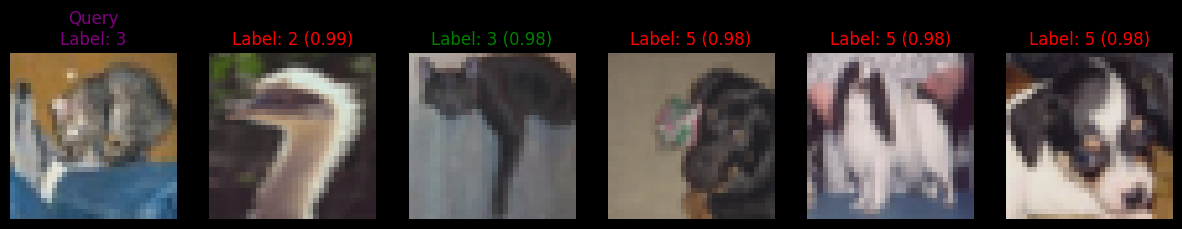

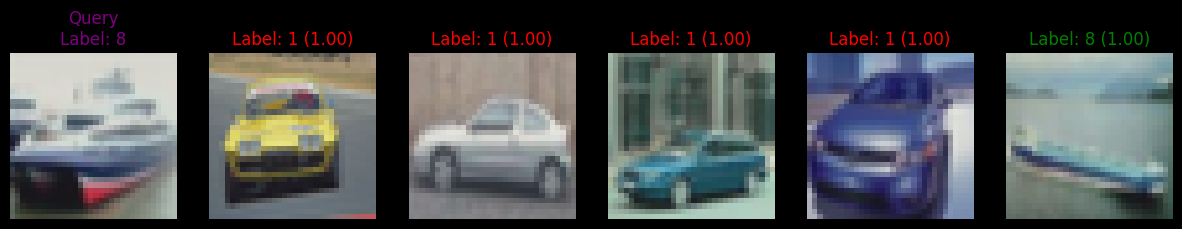

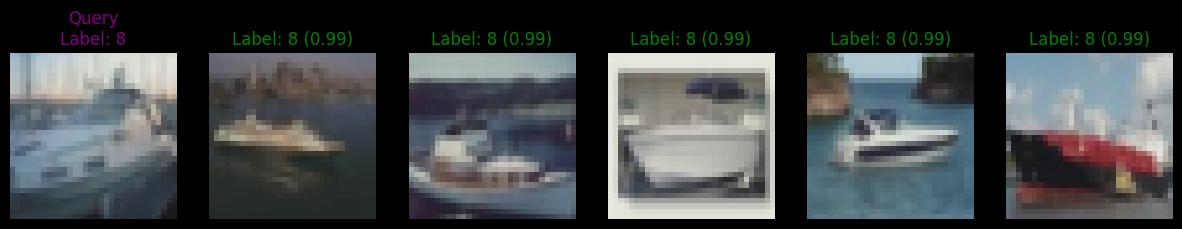

Evaluating /nvme/szh/code/tta-mr/ckpt/cifar-10/nr_0.1_nt_symmetric_cvpr/Coteachingplus/efficientnet_s_restore.pth


100%|██████████| 157/157 [00:03<00:00, 47.68it/s]


mAP for method Coteachingplus: 0.7673


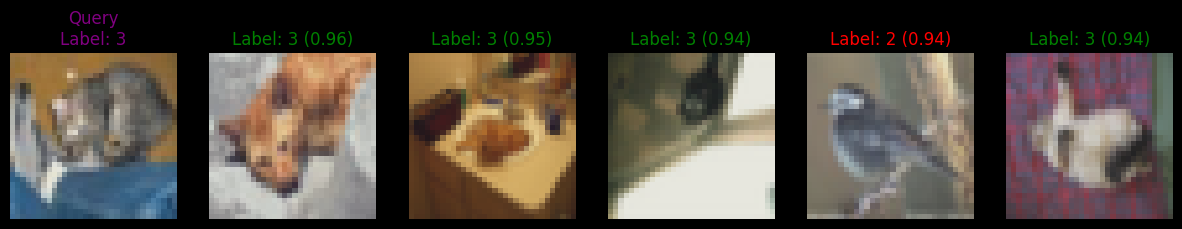

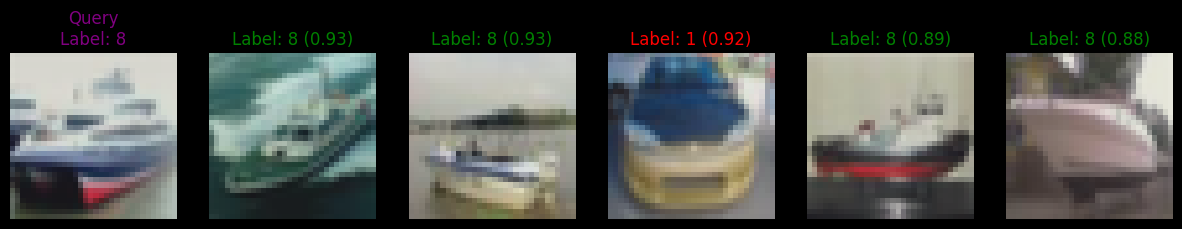

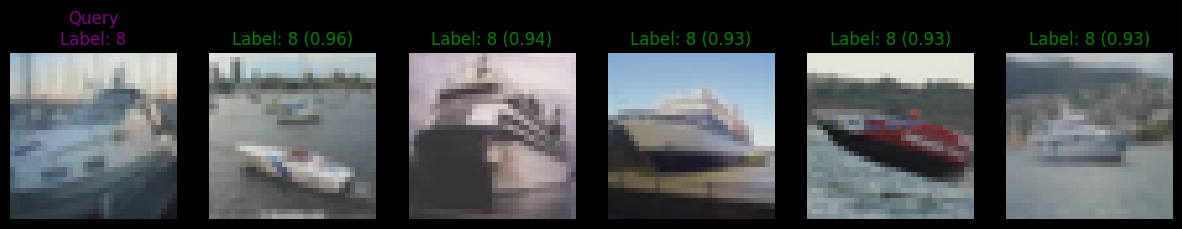

Evaluating /nvme/szh/code/tta-mr/ckpt/cifar-10/nr_0.1_nt_symmetric_cvpr/JoCoR/efficientnet_s_restore.pth


100%|██████████| 157/157 [00:03<00:00, 47.13it/s]


ValueError: Input contains NaN.

In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import DataLoader
from tqdm import tqdm
from configs import settings
import logging
from core_model.custom_model import ClassifierWrapper, load_custom_model
from core_model.dataset import get_dataset_loader, BaseTensorDataset
from core_model.train_test import model_forward

# 设置设备和日志
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

def extract_features(feature_extractor, data_loader):
    """
    提取数据的嵌入特征和标签。
    """
    features, labels = [], []
    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Extracting Features"):
            images = images.to(device)
            outputs = feature_extractor(images).view(images.size(0), -1)
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())
    try:
        return np.concatenate(features), np.concatenate(labels)
    except ValueError:
        logger.error("Error concatenating features or labels; check data loader and model output.")
        return None, None

def retrieve(gallery_feats, query_feats, top_k=10):
    """
    计算相似度并返回前 top-k 的索引。
    """
    try:
        sims = cosine_similarity(query_feats, gallery_feats)
        indices = np.argsort(-sims, axis=1)[:, :top_k]
        sim_scores = np.take_along_axis(sims, indices, axis=1)
        return indices, sim_scores
    except ValueError as e:
        logger.error(f"Error in similarity calculation: {e}")
        return None, None

def calculate_map(indices, gallery_labels, query_labels):
    """
    计算 mAP 值。
    """
    if indices is None:
        logger.warning("No indices to calculate mAP. Skipping.")
        return 0.0
    ap_list = []
    for i in range(len(query_labels)):
        query_label = query_labels[i]
        relevant = (gallery_labels[indices[i]] == query_label).astype(int)
        num_relevant = relevant.sum()
        if num_relevant == 0:
            ap_list.append(0)
            continue
        cumulative_precision = np.cumsum(relevant) / (np.arange(len(relevant)) + 1)
        ap = (cumulative_precision * relevant).sum() / num_relevant
        ap_list.append(ap)
    return np.mean(ap_list) if ap_list else 0.0

def visualize_retrieval(query_data, query_labels, gallery_data, gallery_labels, query_idx, retrieved_indices, sim_scores, dataset_name="cifar-10"):
    """
    可视化检索结果，将查询图像与检索结果并列显示。
    """
    if retrieved_indices is None or sim_scores is None:
        logger.warning("No retrieval results to display. Skipping visualization.")
        return
    
    fig, axs = plt.subplots(1, len(retrieved_indices) + 1, figsize=(15, 3))
    
    # 处理查询图像
    query_img = recover_img(query_data[query_idx], dataset_name)
    axs[0].imshow(np.transpose(query_img, (1, 2, 0)))
    axs[0].set_title(f"Query\nLabel: {query_labels[query_idx]}", color="purple")
    axs[0].axis("off")

    # 处理检索结果
    for i, idx in enumerate(retrieved_indices):
        img = recover_img(gallery_data[idx], dataset_name)
        label = gallery_labels[idx]
        axs[i + 1].imshow(np.transpose(img, (1, 2, 0)))
        axs[i + 1].set_title(f"Label: {label} ({sim_scores[i]:.2f})", color="green" if label == query_labels[query_idx] else "red")
        axs[i + 1].axis("off")

    plt.show()

def recover_img(img, dataset_name):
    """
    恢复归一化的图像，用于可视化。
    """
    if dataset_name == "cifar-10":
        means, stds = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis], np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis]
    elif dataset_name == "cifar-100":
        means, stds = np.array([0.5071, 0.4865, 0.4409])[:, np.newaxis, np.newaxis], np.array([0.2673, 0.2564, 0.2762])[:, np.newaxis, np.newaxis]
    elif dataset_name == "pet-37":
        means, stds = np.array([0.485, 0.456, 0.406])[:, np.newaxis, np.newaxis], np.array([0.229, 0.224, 0.225])[:, np.newaxis, np.newaxis]
    else:
        raise NotImplementedError(f"Normalization for dataset {dataset_name} not implemented.")
    return np.clip(img * stds + means, 0, 1)

def evaluate_image_retrieval(dataset_name, model_name, noise_ratio, noise_type="symmetric", methods=None, top_k=5, query_indices=None):
    """
    执行图像检索任务，包括 mAP 计算和检索结果的可视化。
    """
    assert methods is not None, "请指定方法列表"
    assert query_indices is not None, "请指定查询索引列表"

    case = settings.get_case(noise_ratio, noise_type)
    num_classes = settings.num_classes_dict[dataset_name]

    # 加载数据集
    train_data, train_labels, train_loader = get_dataset_loader(dataset_name, "train", None, None, batch_size=64, shuffle=False)
    test_data, test_labels, test_loader = get_dataset_loader(dataset_name, "test", None, None, batch_size=64, shuffle=False)

    for method in methods:
        model = load_custom_model(model_name, num_classes, load_pretrained=False)
        model = ClassifierWrapper(model, num_classes)

        # 加载模型权重
        model_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_{noise_ratio}_nt_{noise_type}_cvpr/{method}/{model_name}_restore.pth"
        try:
            checkpoint = torch.load(model_path, map_location=device)
            model.load_state_dict(checkpoint, strict=False)
            logger.info(f"Evaluating model at {model_path}")
        except FileNotFoundError:
            logger.warning(f"Model checkpoint {model_path} not found. Skipping method {method}.")
            continue

        # 提取特征
        feature_extractor = nn.Sequential(*list(model.children())[:-1]).to(device)
        g_features, g_labels = extract_features(feature_extractor, train_loader)
        q_features, q_labels = extract_features(feature_extractor, test_loader)

        if g_features is None or q_features is None:
            logger.warning("Feature extraction failed; skipping this method.")
            continue

        # 计算 mAP
        indices, sim_scores = retrieve(g_features, q_features, top_k)
        mAP = calculate_map(indices, g_labels, q_labels)
        logger.info(f"mAP for method {method}: {mAP:.4f}")

        # 可视化检索结果
        for query_idx in query_indices:
            retrieved_indices, sim_scores = retrieve(g_features, q_features[query_idx:query_idx+1], top_k)
            if retrieved_indices is not None and sim_scores is not None:
                visualize_retrieval(test_data, test_labels, train_data, train_labels, query_idx, retrieved_indices[0], sim_scores[0], dataset_name)

# 示例用法
if __name__ == "__main__":
    dataset_name = "cifar-10"
    model_name = "efficientnet_s"
    noise_ratio = 0.1
    noise_type = "symmetric"
    methods = ["Coteaching", "Coteachingplus", "JoCoR"]
    query_indices = [0, 1, 2]  # 测试图片索引
    evaluate_image_retrieval(dataset_name, model_name, noise_ratio, noise_type, methods=methods, top_k=5, query_indices=query_indices)
